# CIFAR-10 Object Recognition with CNN

## Setup and Data Extraction (No Visualizations Here)

In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tarfile

In [2]:
# Define paths
root_folder = "/Users/reecelance/Desktop/"
compressed_file_path = root_folder + "cifar-10-python.tar.gz"
extracted_folder = root_folder + "cifar-10-batches-py"

In [3]:
# Extract data if not already extracted
if not os.path.exists(extracted_folder):
    print("Extracting CIFAR-10 data...")
    try:
        with tarfile.open(compressed_file_path, "r:gz") as tar:
            tar.extractall(root_folder)
        print("Extraction complete.")
    except Exception as e:
        print(f"Error extracting data: {e}")
        exit()

## Data Loading, Preprocessing, and Visualization

In [4]:
# Set global style for all plots
plt.rcParams.update({
    'figure.facecolor': '#dff2f8',  # Set background color for figures
    'axes.facecolor': '#dff2f8',  # Set background color for axes
    'savefig.facecolor': '#dff2f8',  # Ensure saved figures retain background color
    'axes.prop_cycle': plt.cycler(color=['#007d9c', '#85cce2']),  # Set colors globally
    'axes.facecolor': '#dff2f8',  # Set background color
    'figure.facecolor': '#dff2f8',  # Set figure background color
    'grid.color': '#cccccc',  # Grid color
    'lines.linewidth': 2,  # Default line width
    'figure.dpi': 400 # DPI for all figures
})

In [5]:
def load_cifar10_batch(folder, batch_id):
    with open(os.path.join(folder, f"data_batch_{batch_id}"), 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(labels)

In [6]:
# Load data
x_train = []
y_train = []
for i in range(1, 6):
    data, labels = load_cifar10_batch(extracted_folder, i)
    x_train.append(data)
    y_train.append(labels)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

# Load test data
with open(os.path.join(extracted_folder, 'test_batch'), 'rb') as file:
    test_batch = pickle.load(file, encoding='bytes')
    x_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch[b'labels'])

# Split the training data into a training set (80%) and validation set (20%)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print dataset sizes after ensuring test data is loaded
print(f"Training set size: {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

# Load class labels
with open(os.path.join(extracted_folder, 'batches.meta'), 'rb') as file:
    meta = pickle.load(file, encoding='bytes')
    class_labels = [label.decode('utf-8') for label in meta[b'label_names']]


Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [7]:
# Metadata Output
print("CIFAR-10 Dataset Metadata:")
print(f"Number of training images: {len(x_train)}")
print(f"Number of test images: {len(x_test)}")
print(f"Image dimensions: {x_train.shape[1:]}")
print(f"Number of classes: {len(class_labels)}")
print("Classes:", class_labels)

unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))
print("\nTraining Set Class Distribution:")
for label, count in class_distribution_train.items():
    print(f"{class_labels[label].title()}: {count}")

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))
print("\nTest Set Class Distribution:")
for label, count in class_distribution_test.items():
    print(f"{class_labels[label].title()}: {count}")

CIFAR-10 Dataset Metadata:
Number of training images: 40000
Number of test images: 10000
Image dimensions: (32, 32, 3)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Training Set Class Distribution:
Airplane: 4027
Automobile: 4021
Bird: 3970
Cat: 3977
Deer: 4067
Dog: 3985
Frog: 4004
Horse: 4006
Ship: 3983
Truck: 3960

Test Set Class Distribution:
Airplane: 1000
Automobile: 1000
Bird: 1000
Cat: 1000
Deer: 1000
Dog: 1000
Frog: 1000
Horse: 1000
Ship: 1000
Truck: 1000


## Data Visualisation:
Example Images, Class Distribution (Bar Chart), and a few images before and after normalisation

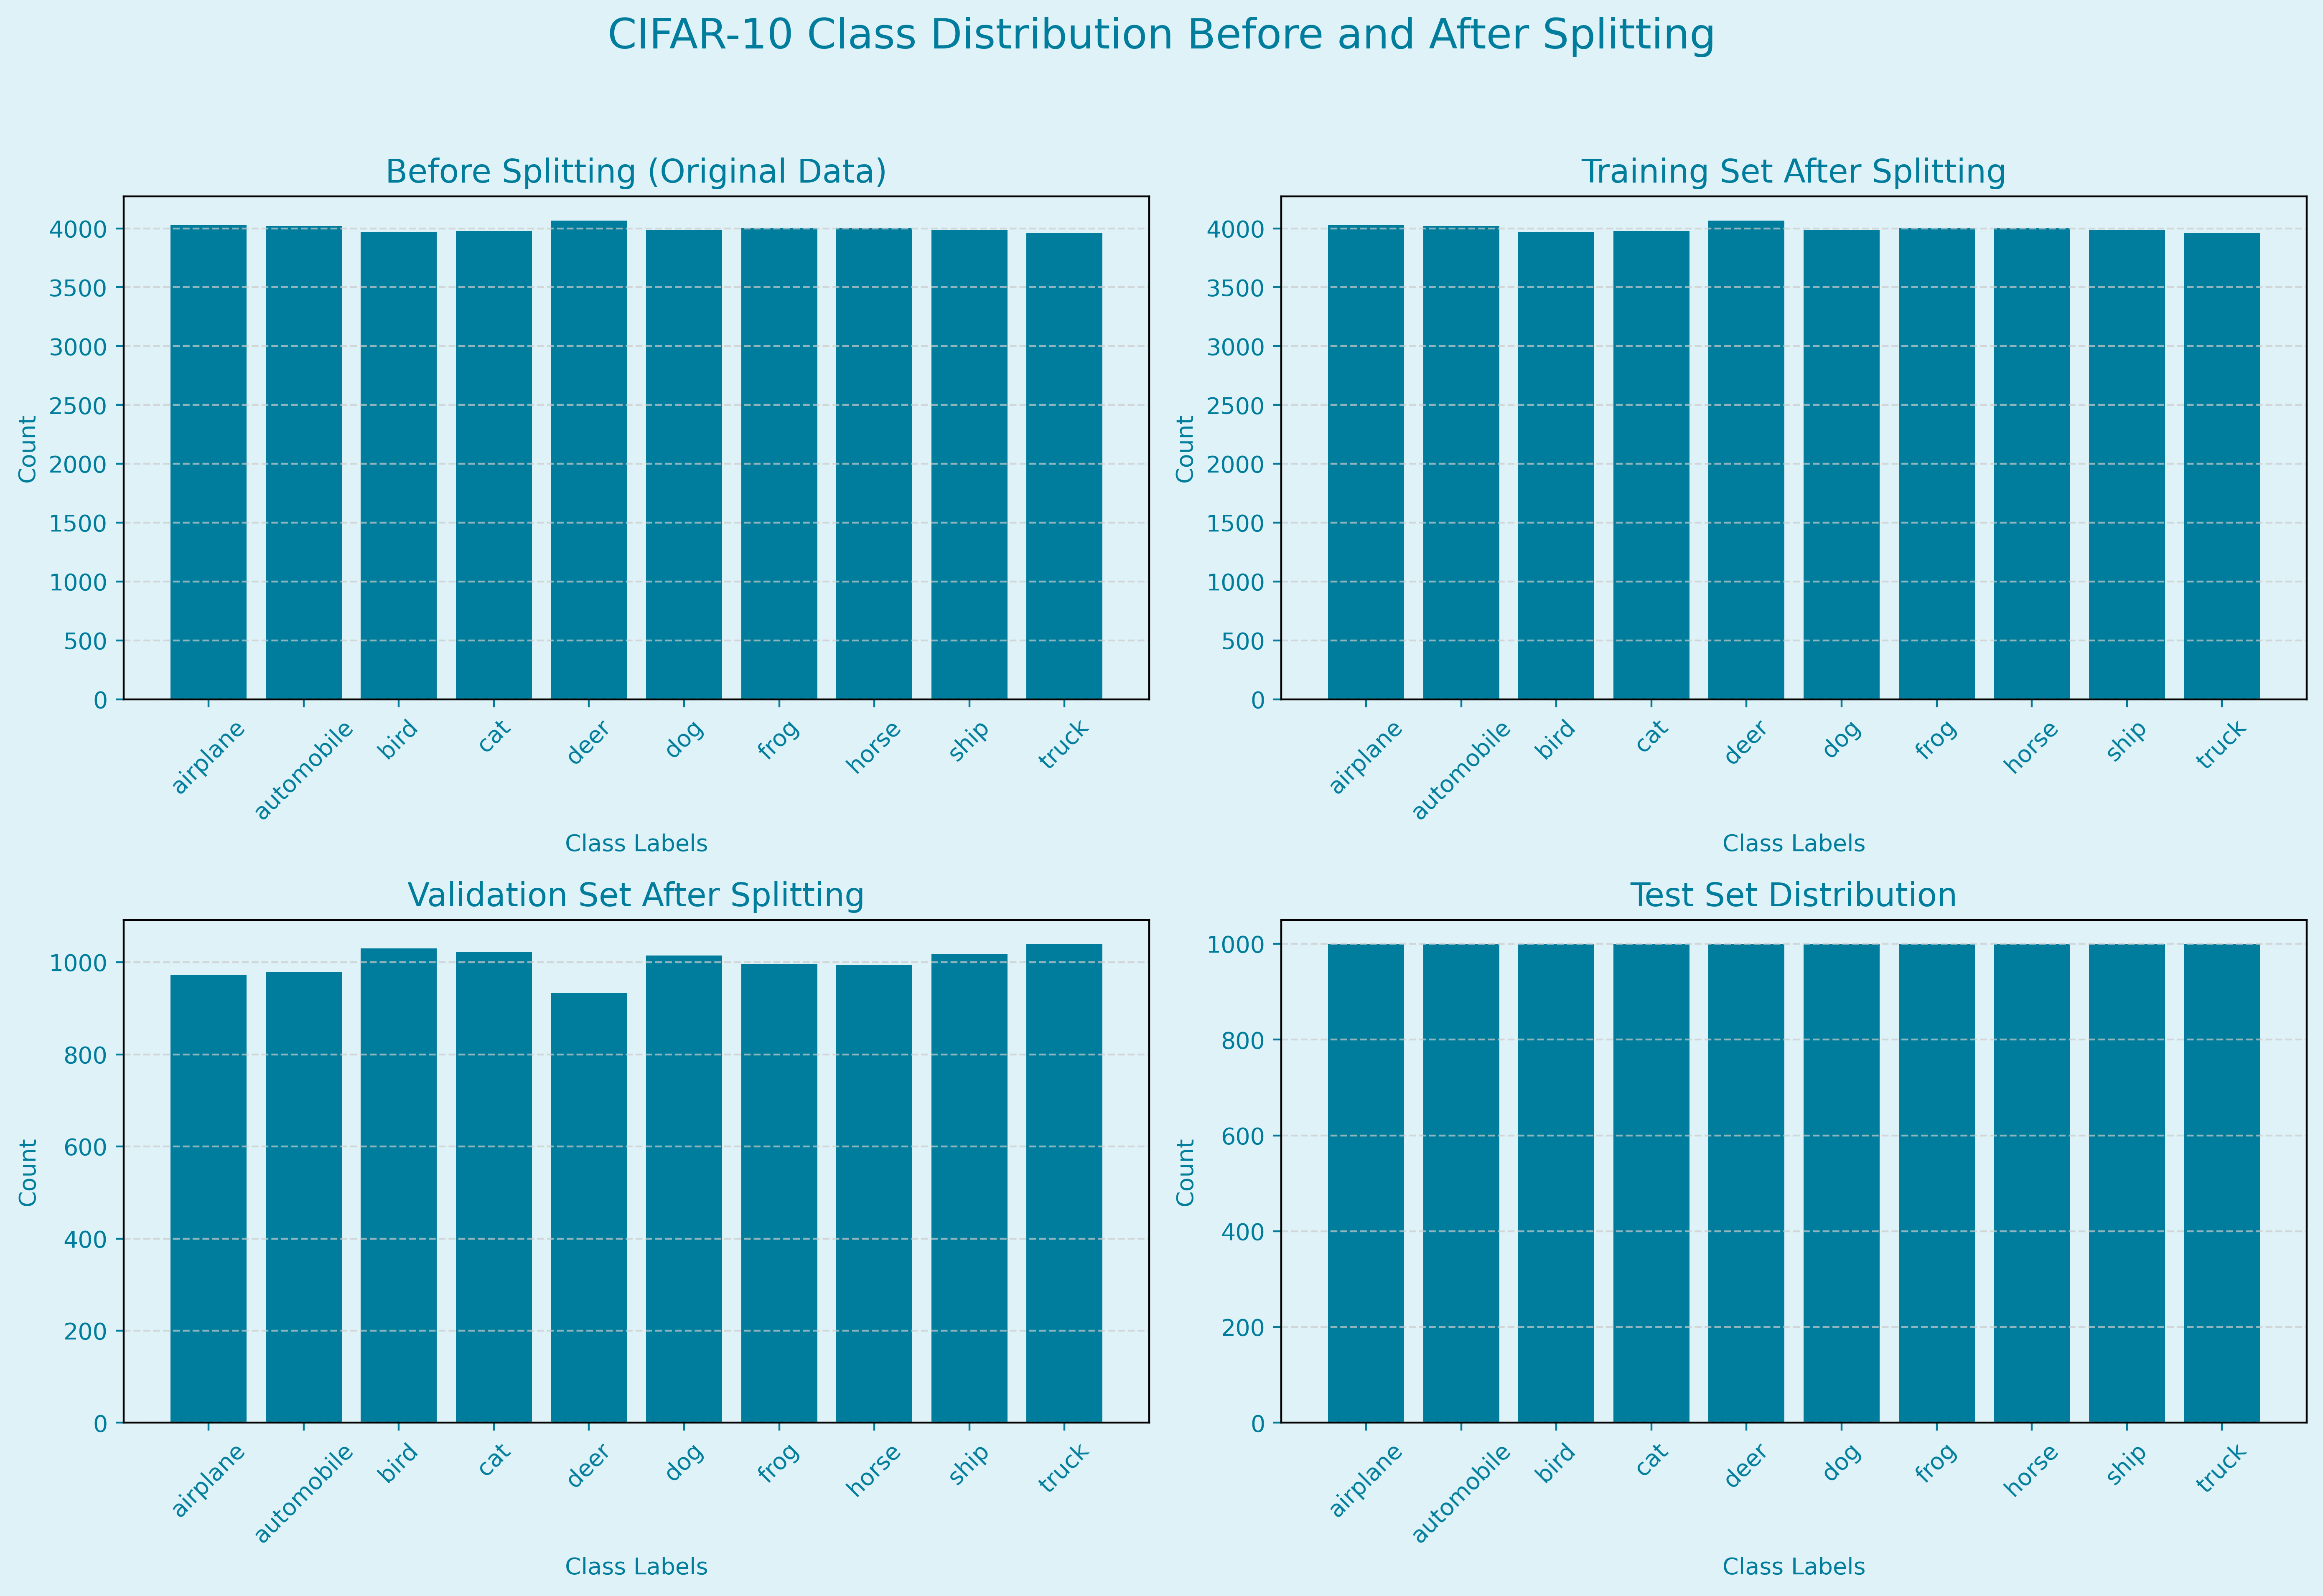

In [8]:
# Function to plot class distribution
def plot_class_distribution(ax, y_data, title, color):
    class_counts = np.bincount(y_data)
    ax.bar(class_labels, class_counts, color=color)
    ax.set_xlabel('Class Labels', fontsize=10, color='#007d9c')
    ax.set_ylabel('Count', fontsize=10, color='#007d9c')
    ax.set_title(title, fontsize=14, color='#007d9c')
    ax.tick_params(axis='x', rotation=45, colors='#007d9c')
    ax.tick_params(axis='y', colors='#007d9c')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Create a figure with 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.patch.set_facecolor('#dff2f8')  # Set background color

# Plot the class distributions
plot_class_distribution(axes[0, 0], y_train, "Before Splitting (Original Data)", '#007d9c')
plot_class_distribution(axes[0, 1], y_train, "Training Set After Splitting", '#007d9c')
plot_class_distribution(axes[1, 0], y_val, "Validation Set After Splitting", '#007d9c')
plot_class_distribution(axes[1, 1], y_test, "Test Set Distribution", '#007d9c')

# Adjust layout for better spacing
plt.suptitle("CIFAR-10 Class Distribution Before and After Splitting", fontsize=18, color='#007d9c')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


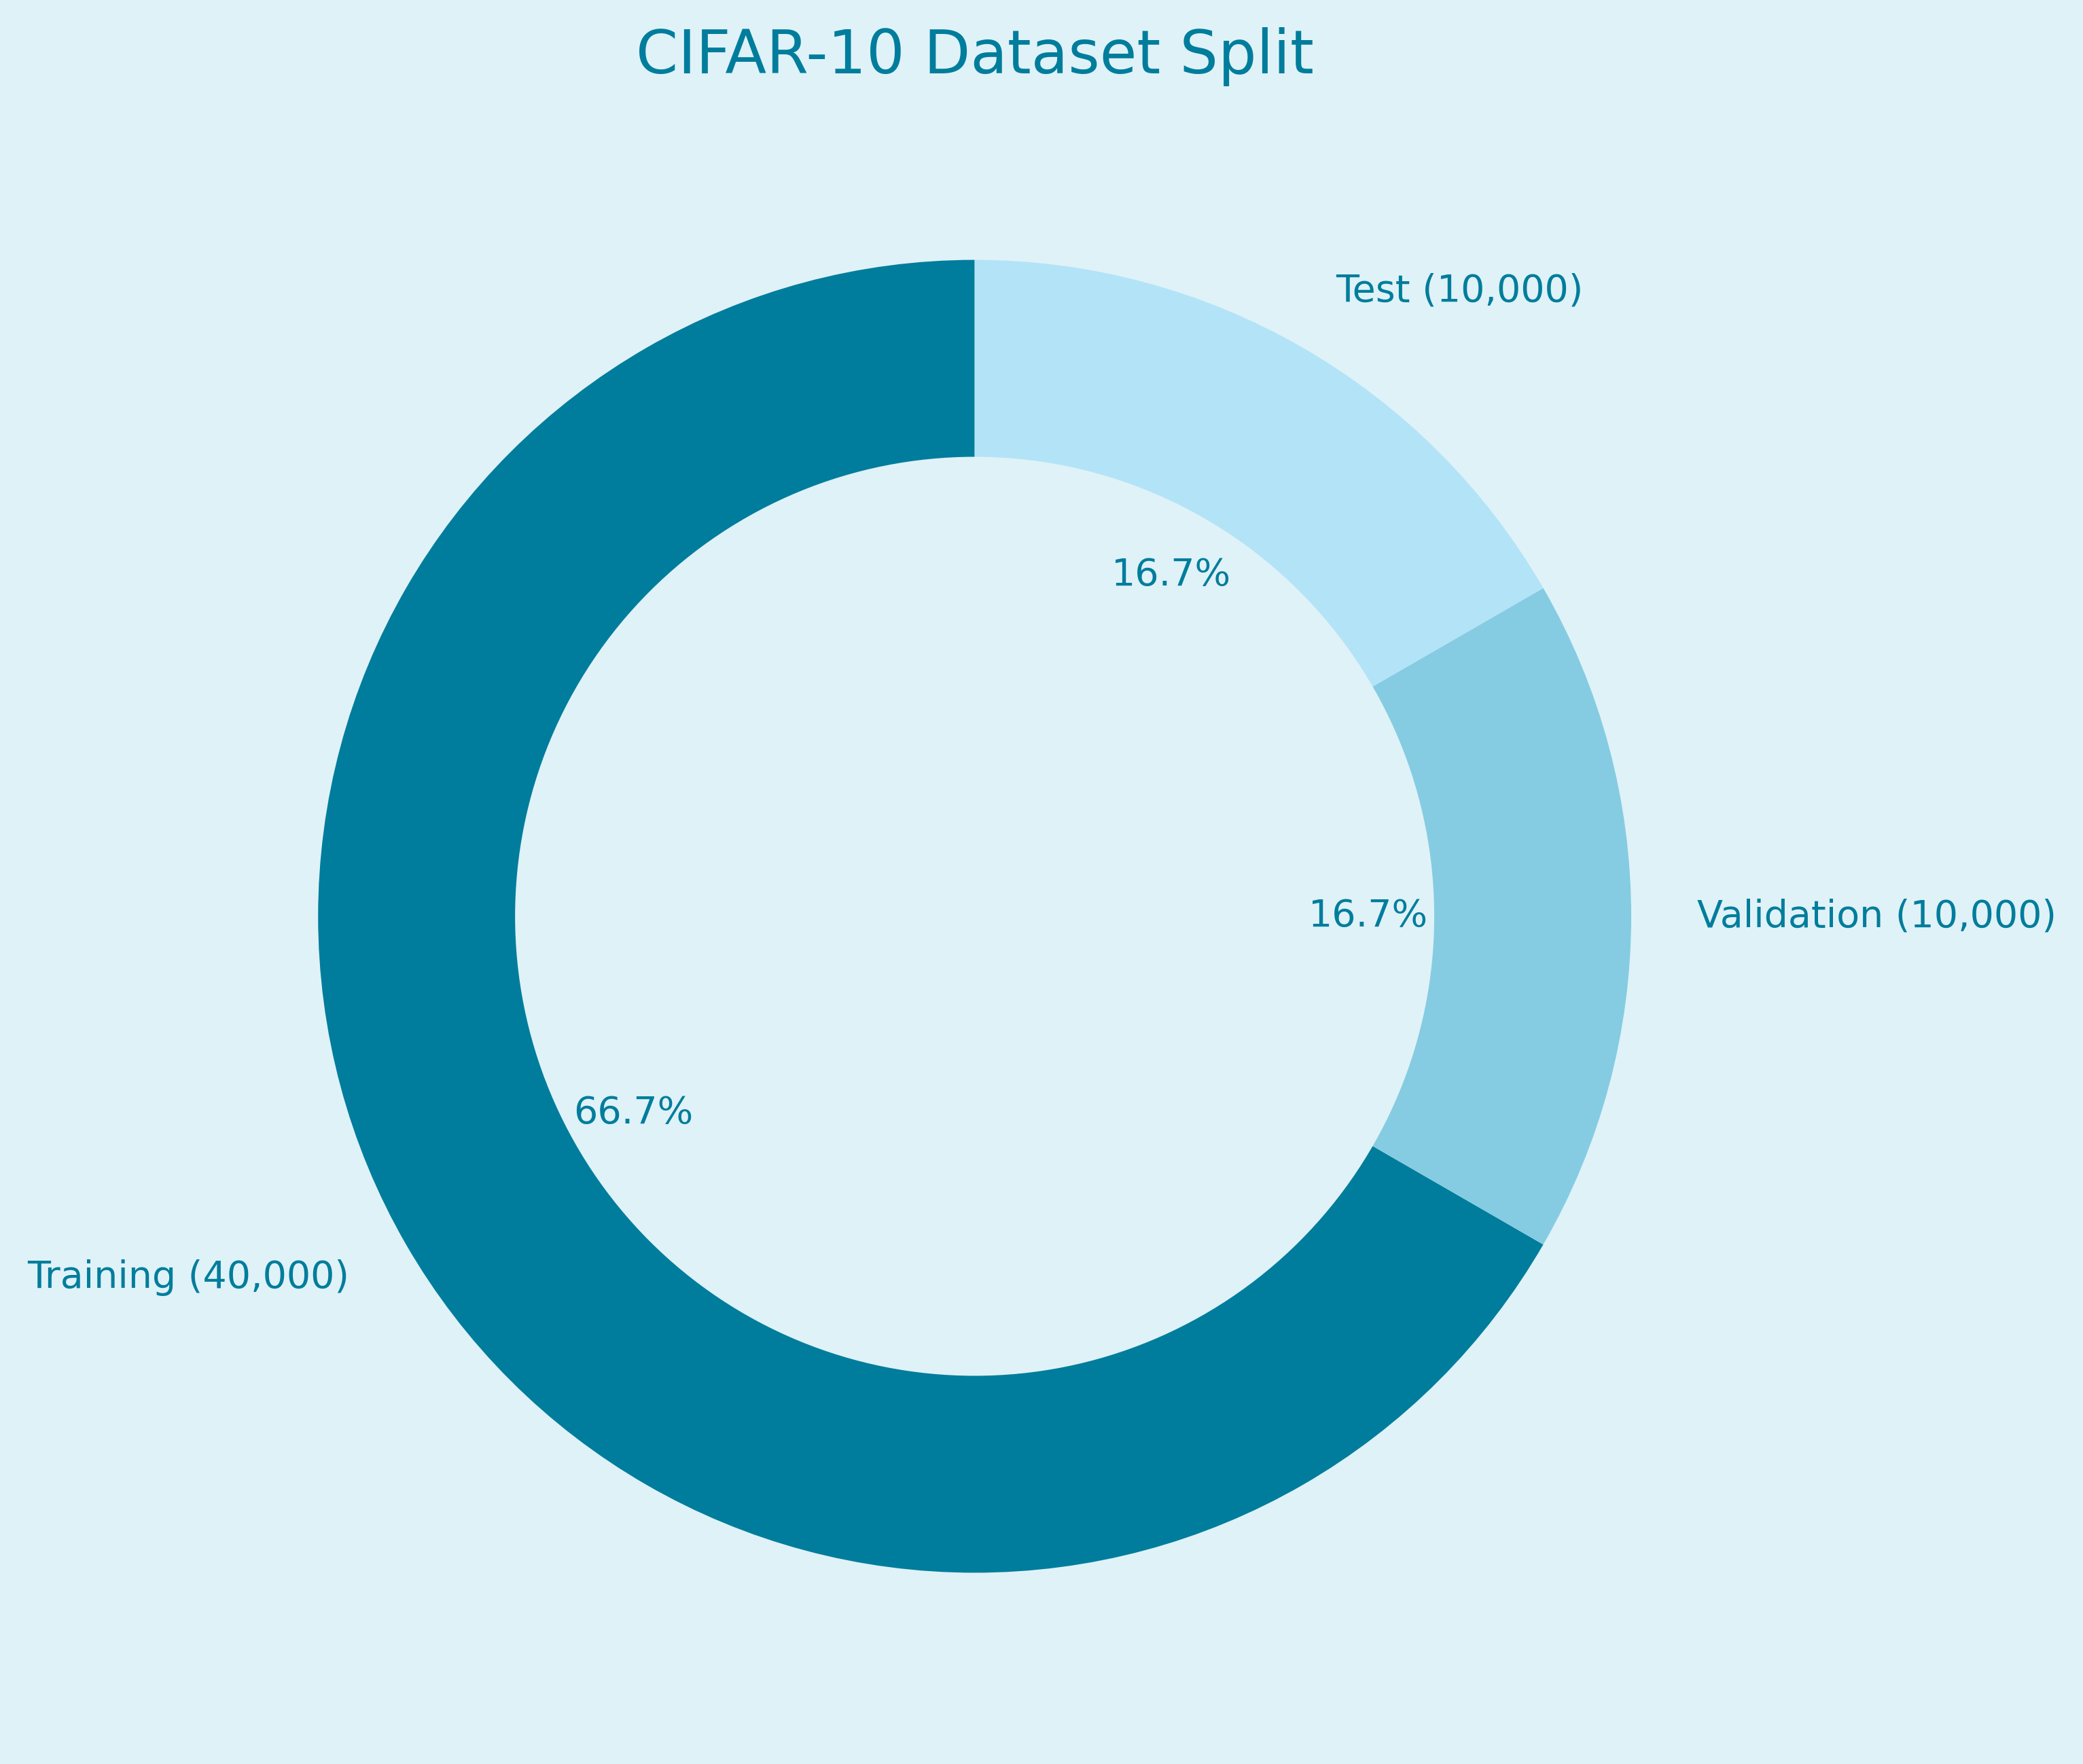

In [9]:
# Data distribution: Training (40,000), Validation (10,000), and Test (10,000)
train_ratio = 0.8
val_ratio = 0.2
test_size = x_test.shape[0]
total_size = x_train.shape[0] + x_val.shape[0] + x_test.shape[0]

# Correcting the percentages
sizes = [x_train.shape[0], x_val.shape[0], x_test.shape[0]]
labels = [
    f'Training (40,000)',
    f'Validation (10,000)',
    'Test (10,000)'
]
colors = ['#007d9c', '#85cce2', '#b3e3f7']

# Create pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, textprops={'color': '#007d9c'})
ax.set_title('CIFAR-10 Dataset Split', fontsize=16, color='#007d9c')

# Add donut hole for better appearance
centre_circle = plt.Circle((0, 0), 0.70, fc='#dff2f8')
fig.gca().add_artist(centre_circle)

plt.show()


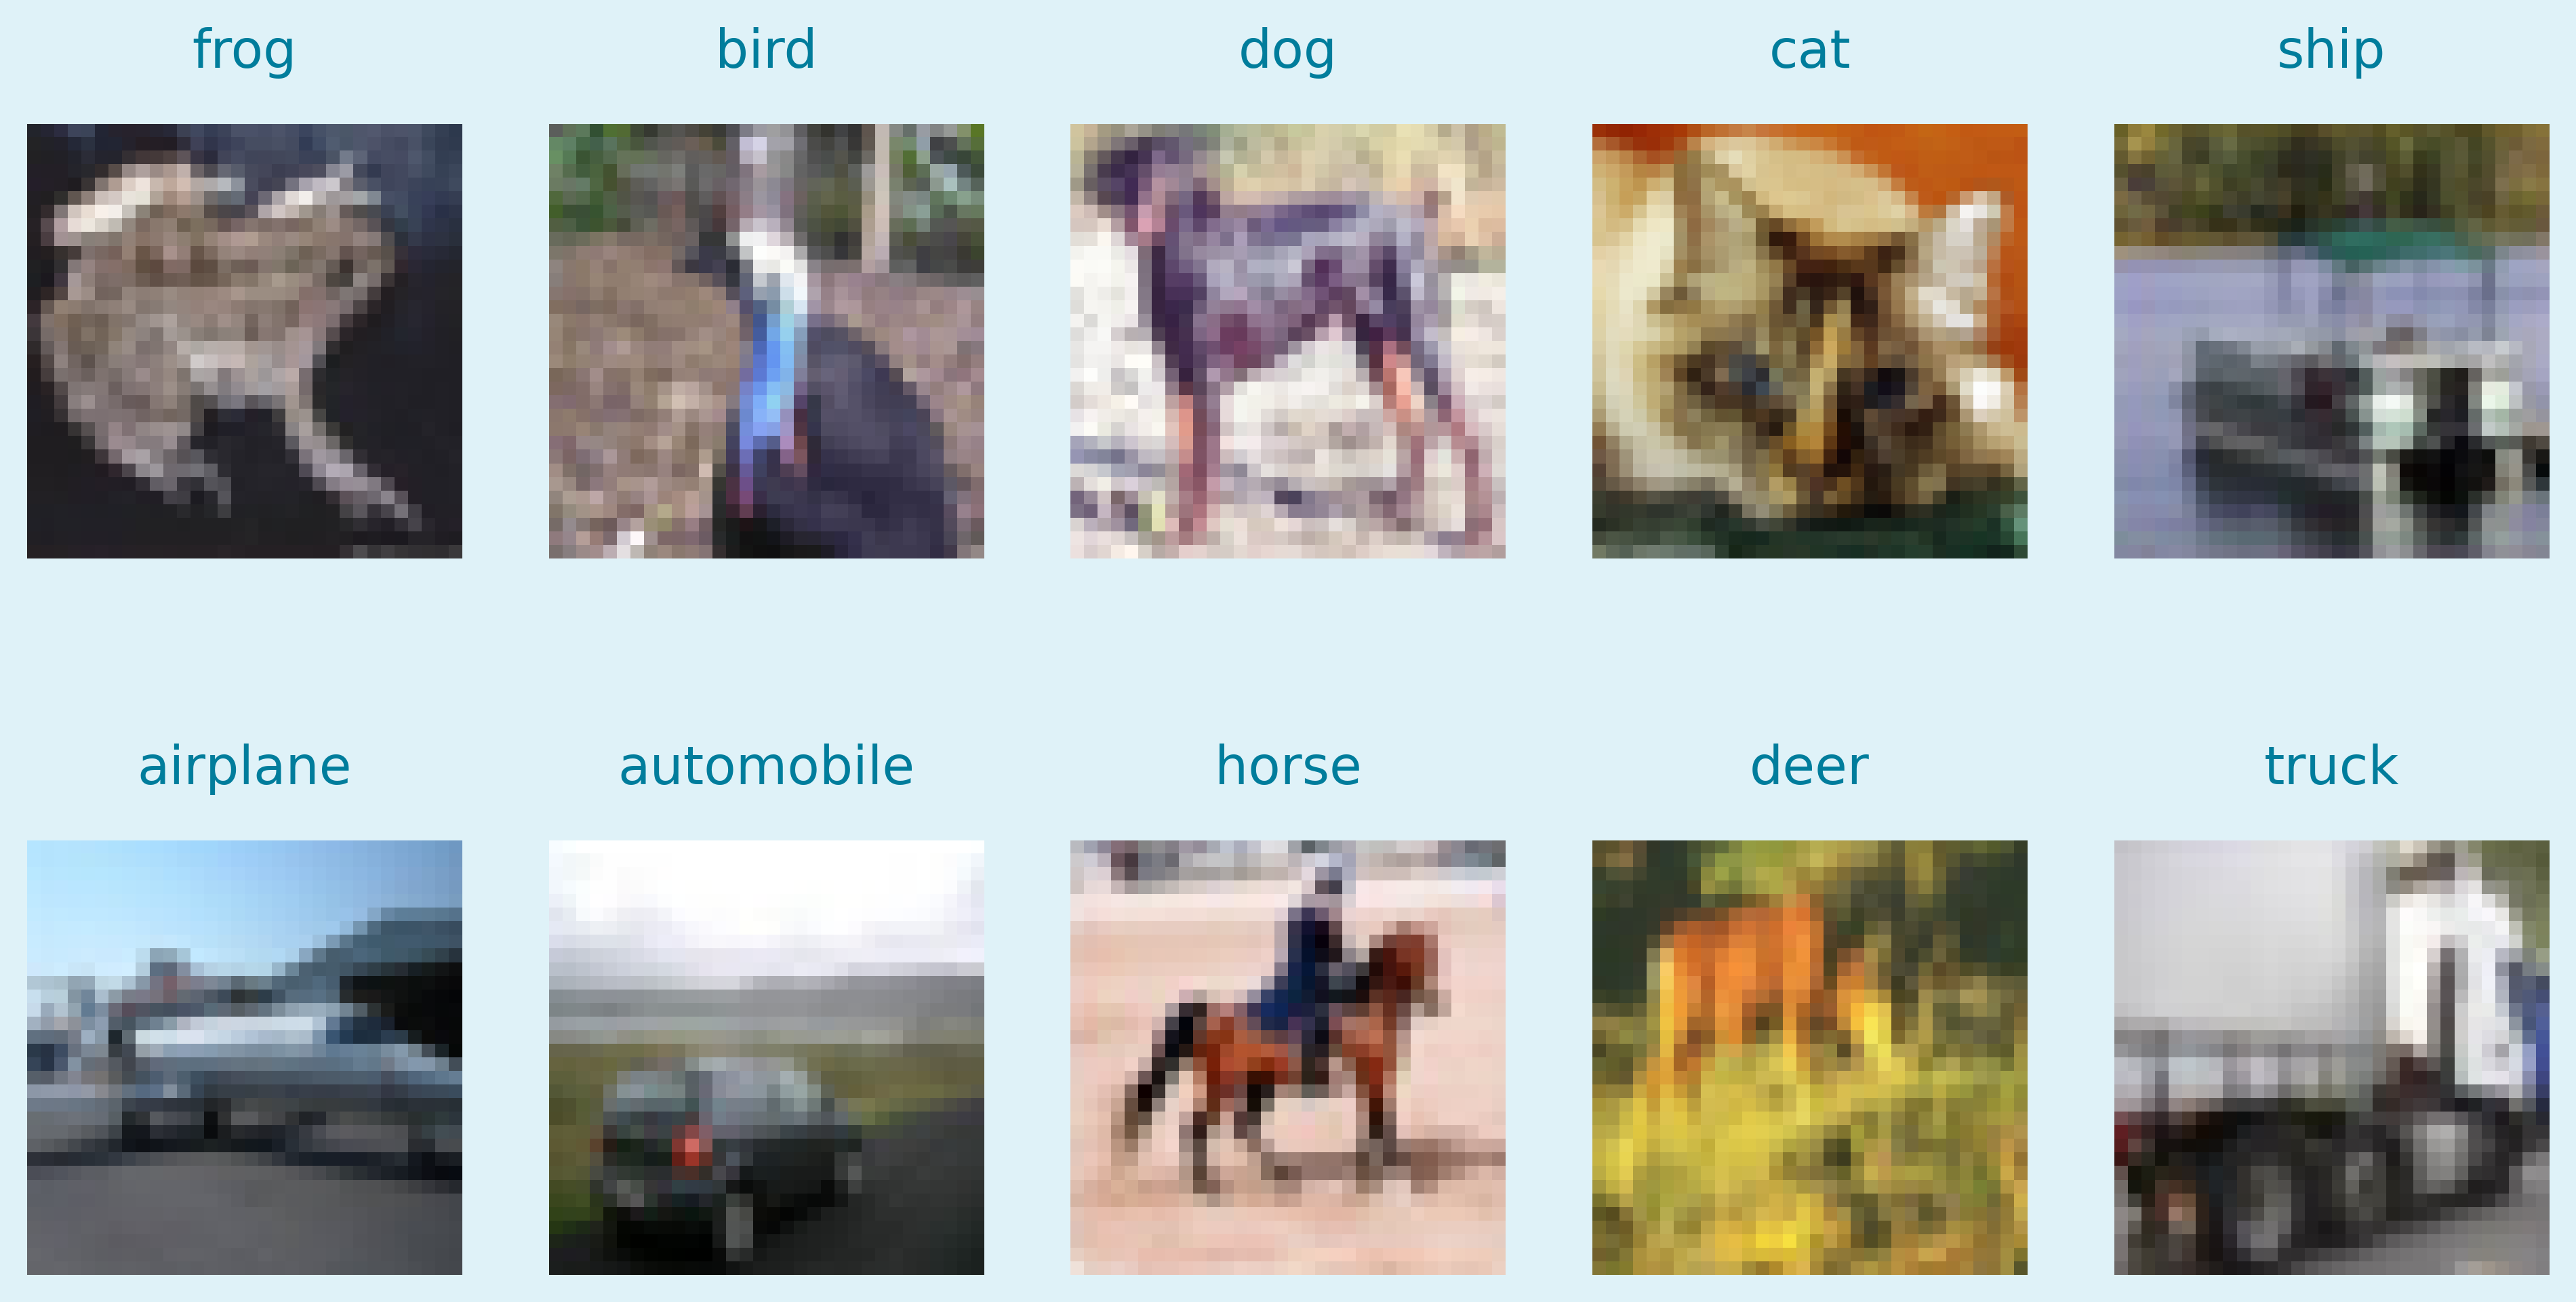

In [10]:
# Create a dictionary to store one correct example per class
unique_classes = {}
for i in range(len(y_train)):
    label = y_train[i]  # Get the label
    if label not in unique_classes:
        unique_classes[label] = x_train[i]  # Store the first occurrence of each class
    if len(unique_classes) == 10:  # Stop when all 10 classes have been found
        break

# Plot the 10 sample images in a 5x2 grid with the specified background and text colors
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.patch.set_facecolor('#dff2f8')  # Set figure background color

axes = axes.ravel()

for idx, (class_idx, image) in enumerate(unique_classes.items()):
    axes[idx].imshow(image)
    axes[idx].set_title(class_labels[class_idx], fontsize=14, color='#007d9c', pad=15)  # Add padding to move text down
    axes[idx].axis('off')
    axes[idx].set_facecolor('#dff2f8')  # Set background color for individual plots

# Adjust layout to increase spacing between rows
plt.subplots_adjust(hspace=0.4, wspace=0.2)  # Increase vertical spacing between images
plt.suptitle("", fontsize=20, color='#007d9c', y=1.05)  # Move title slightly higher
plt.show()


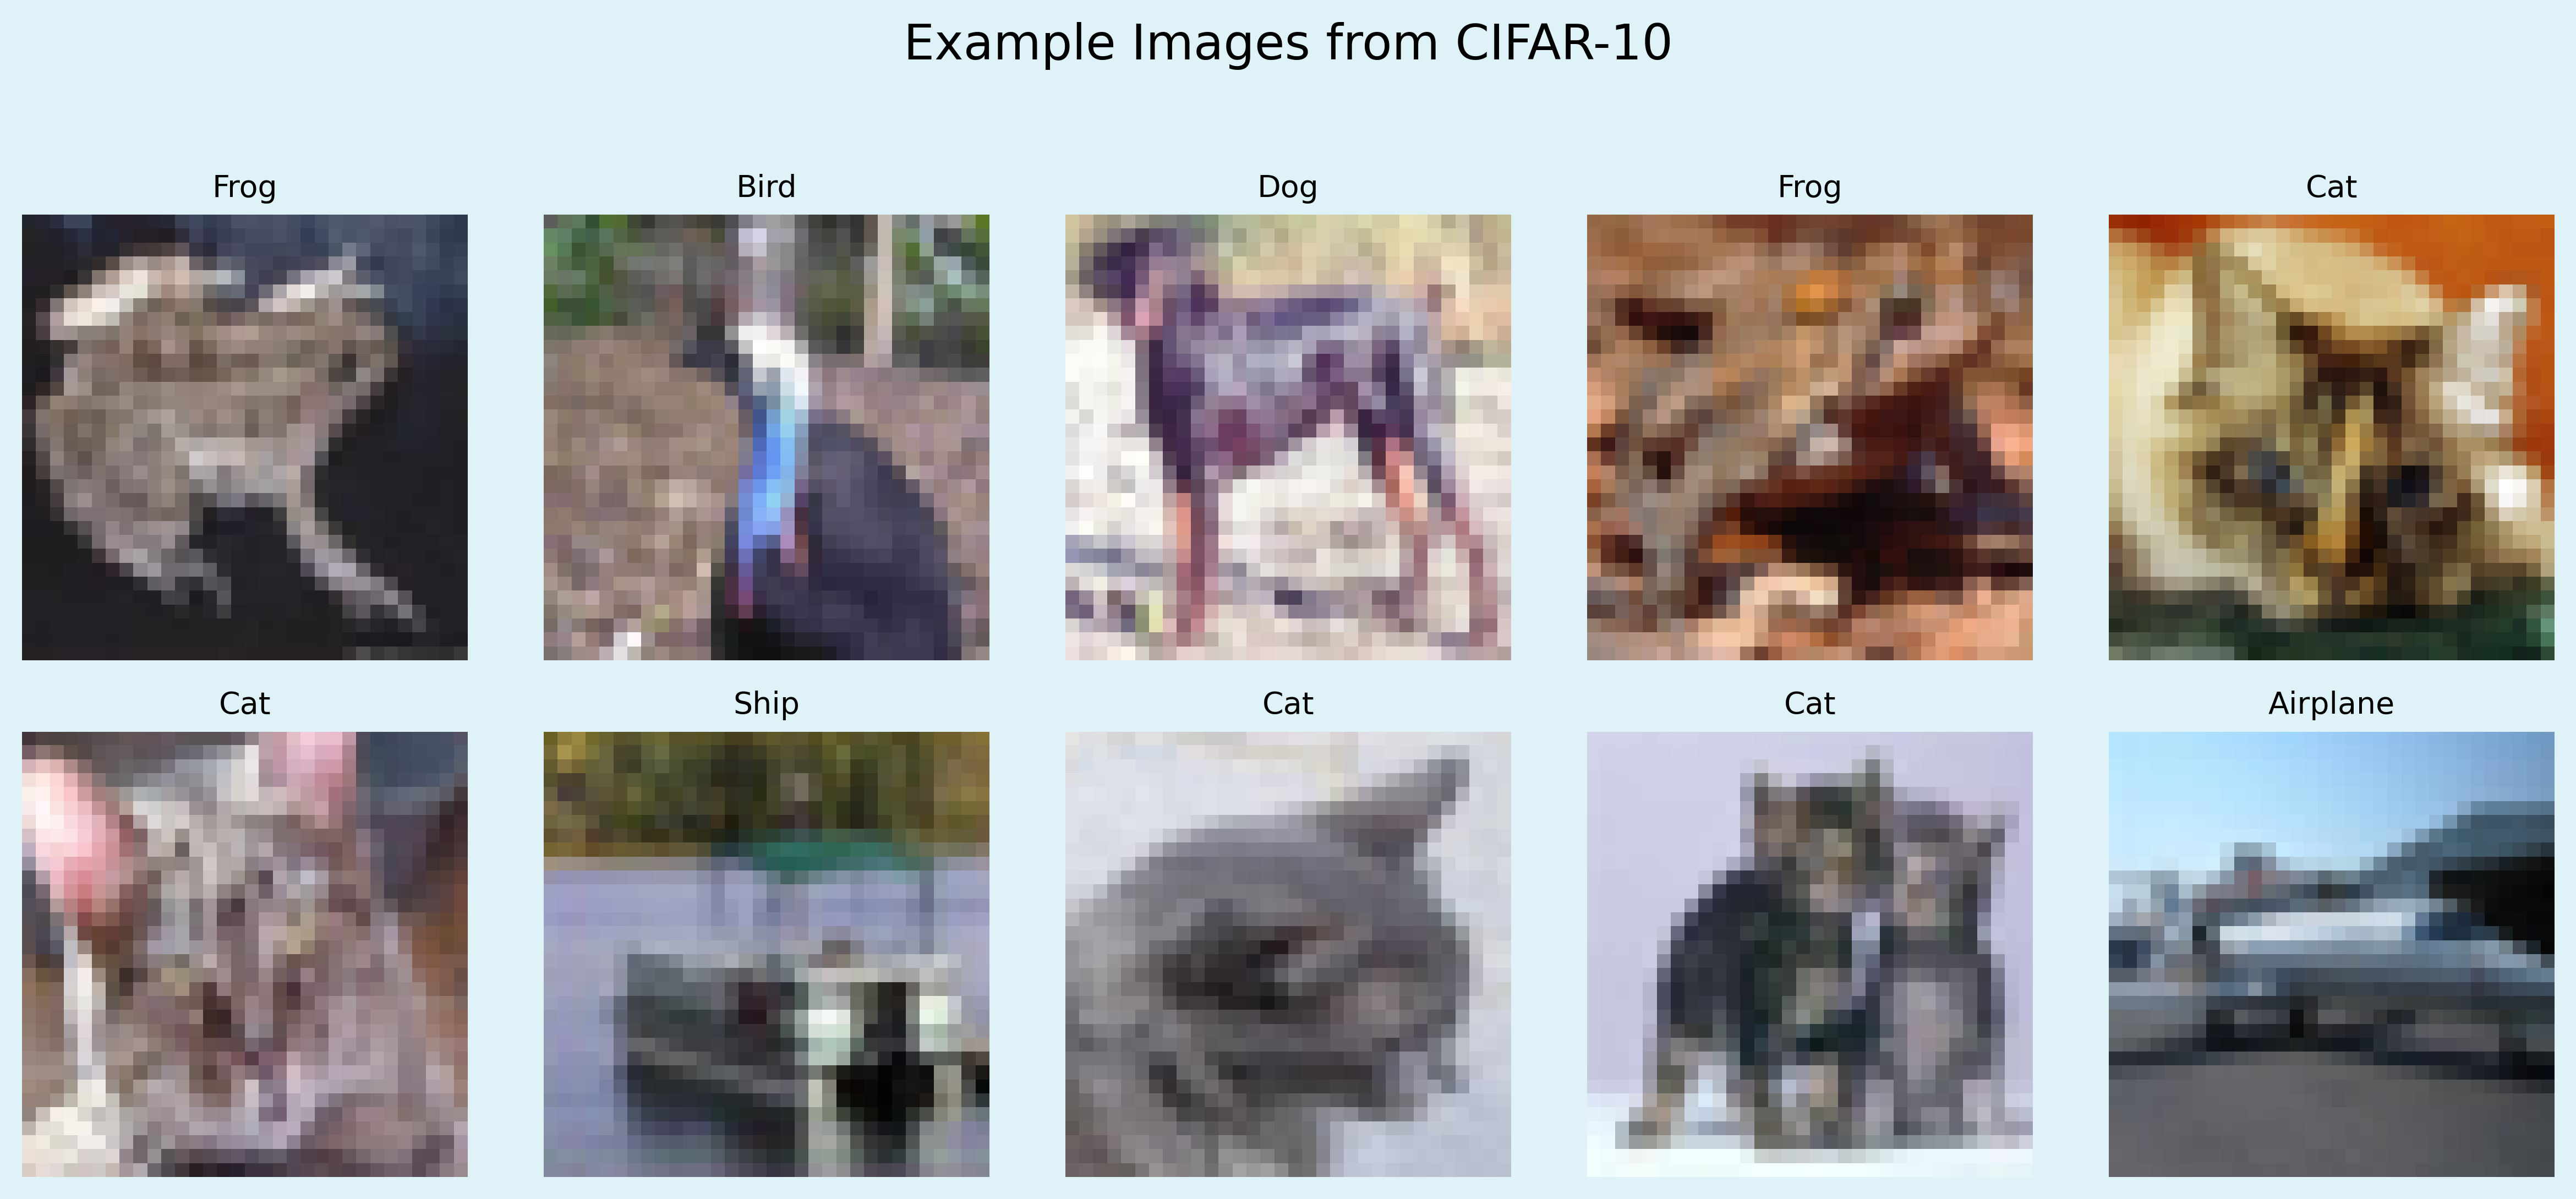

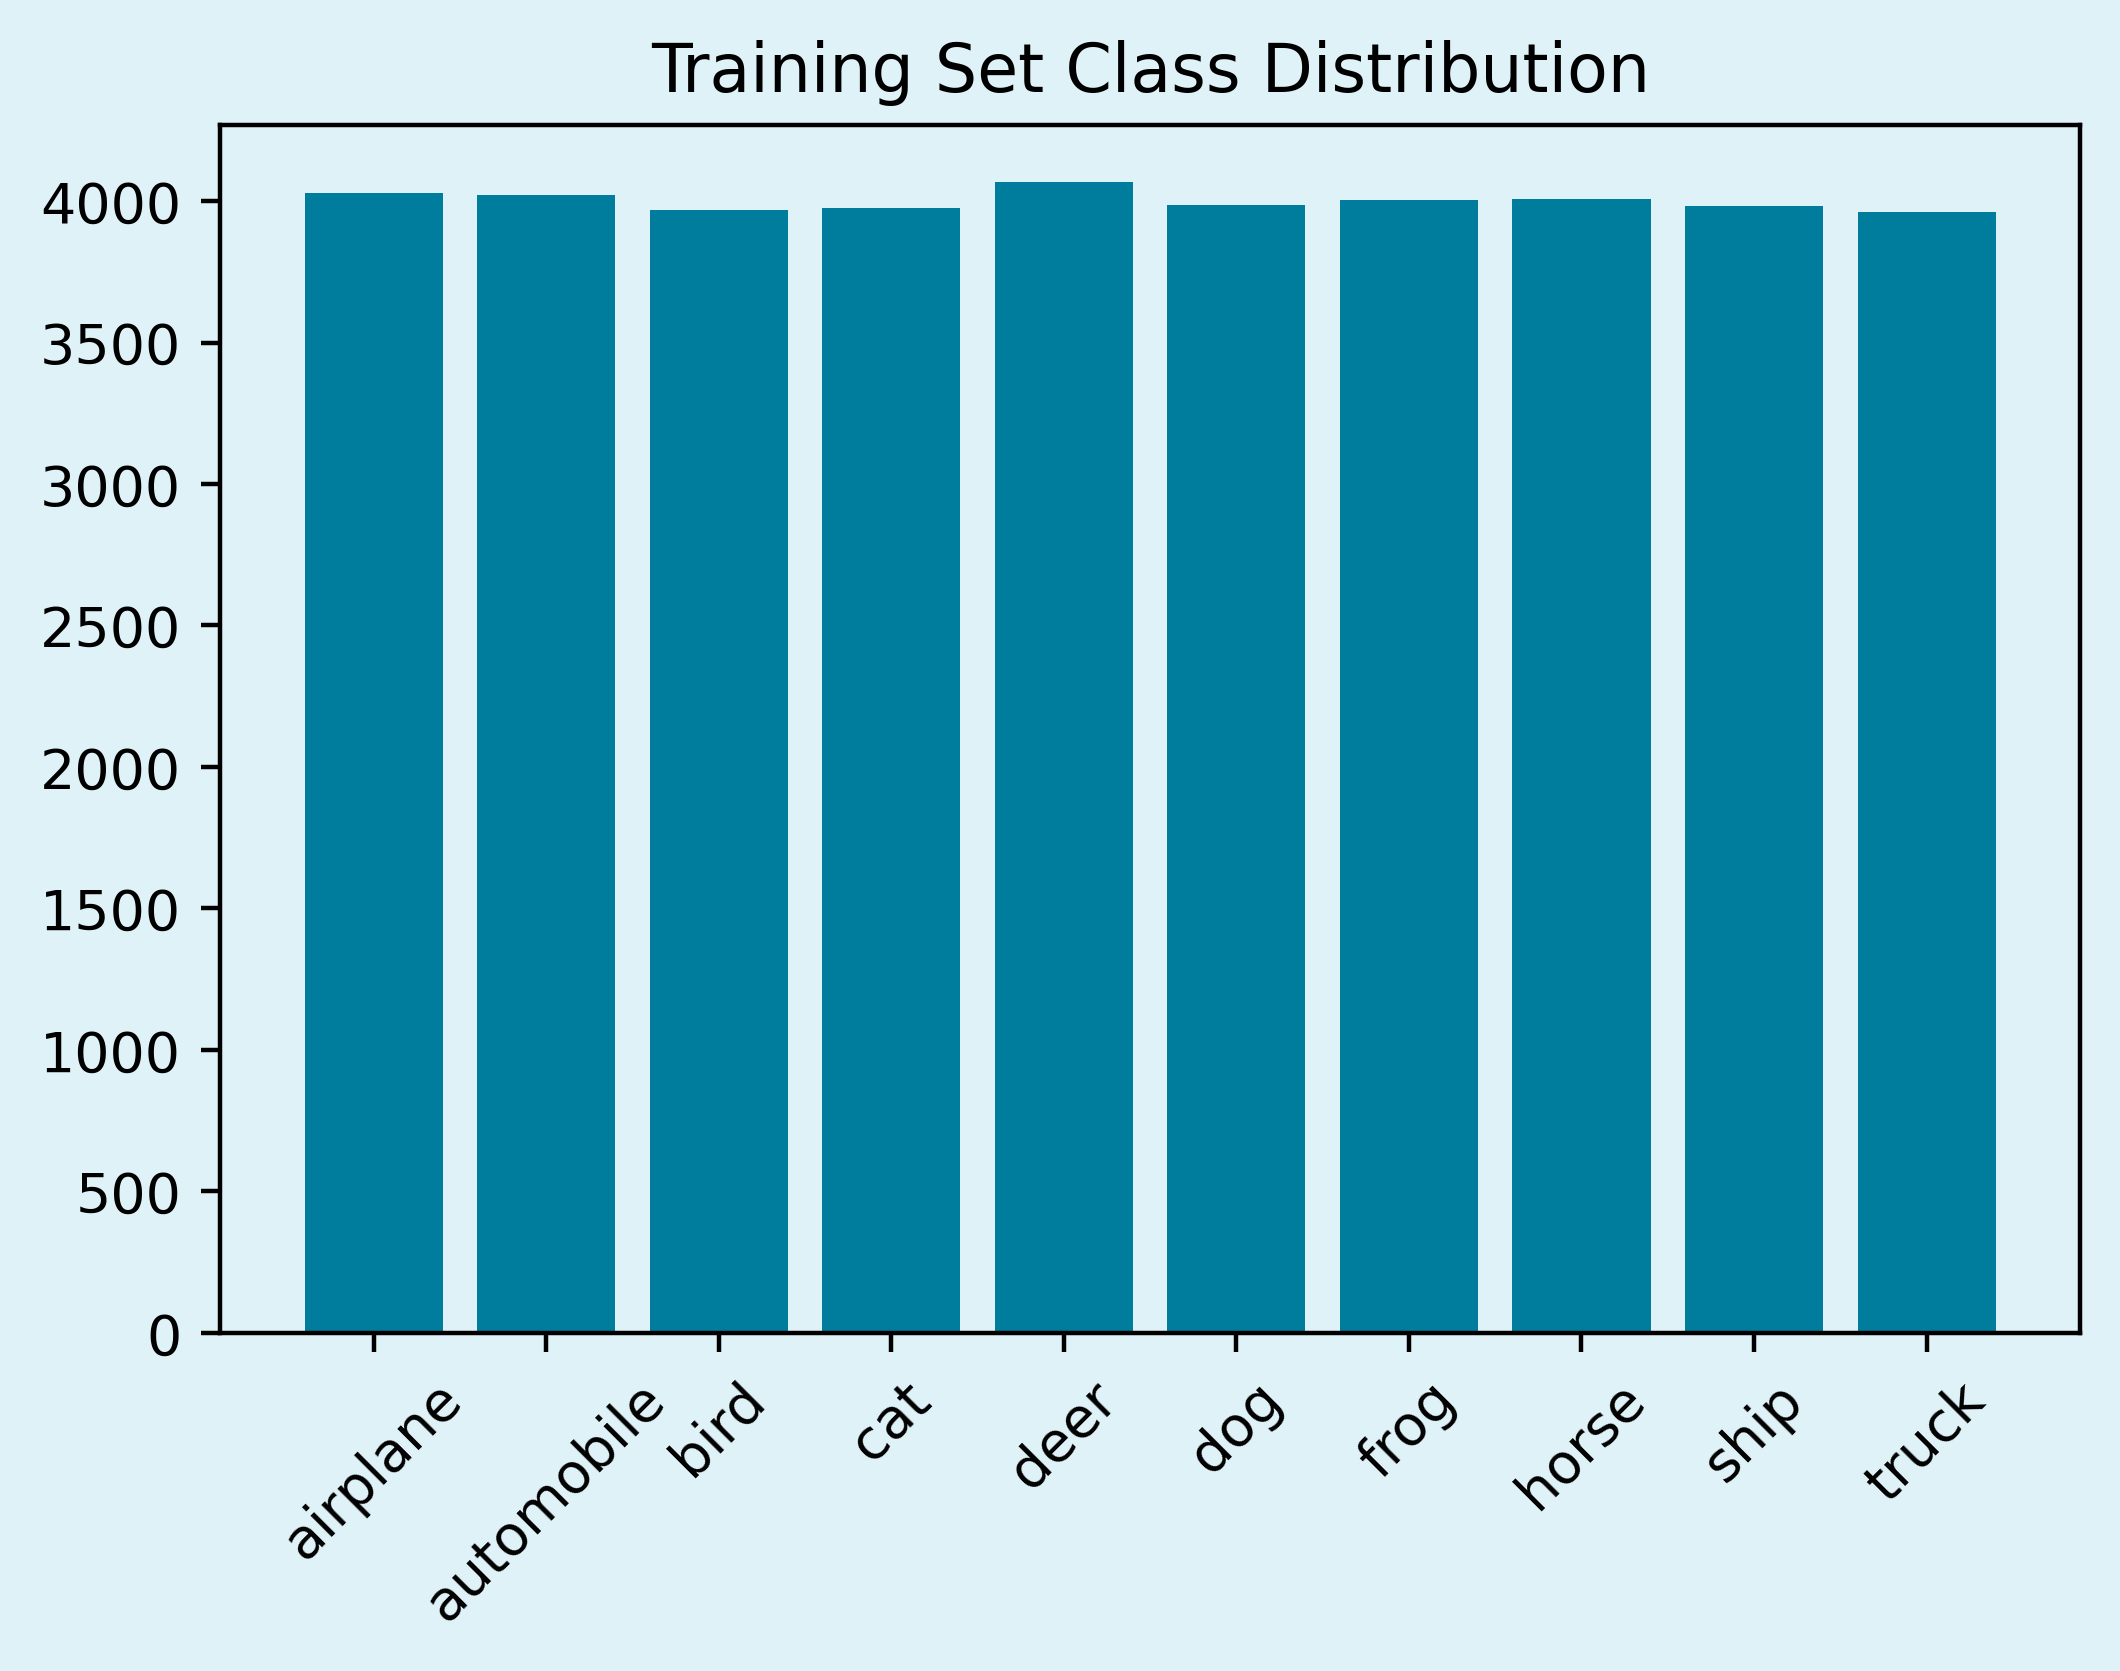

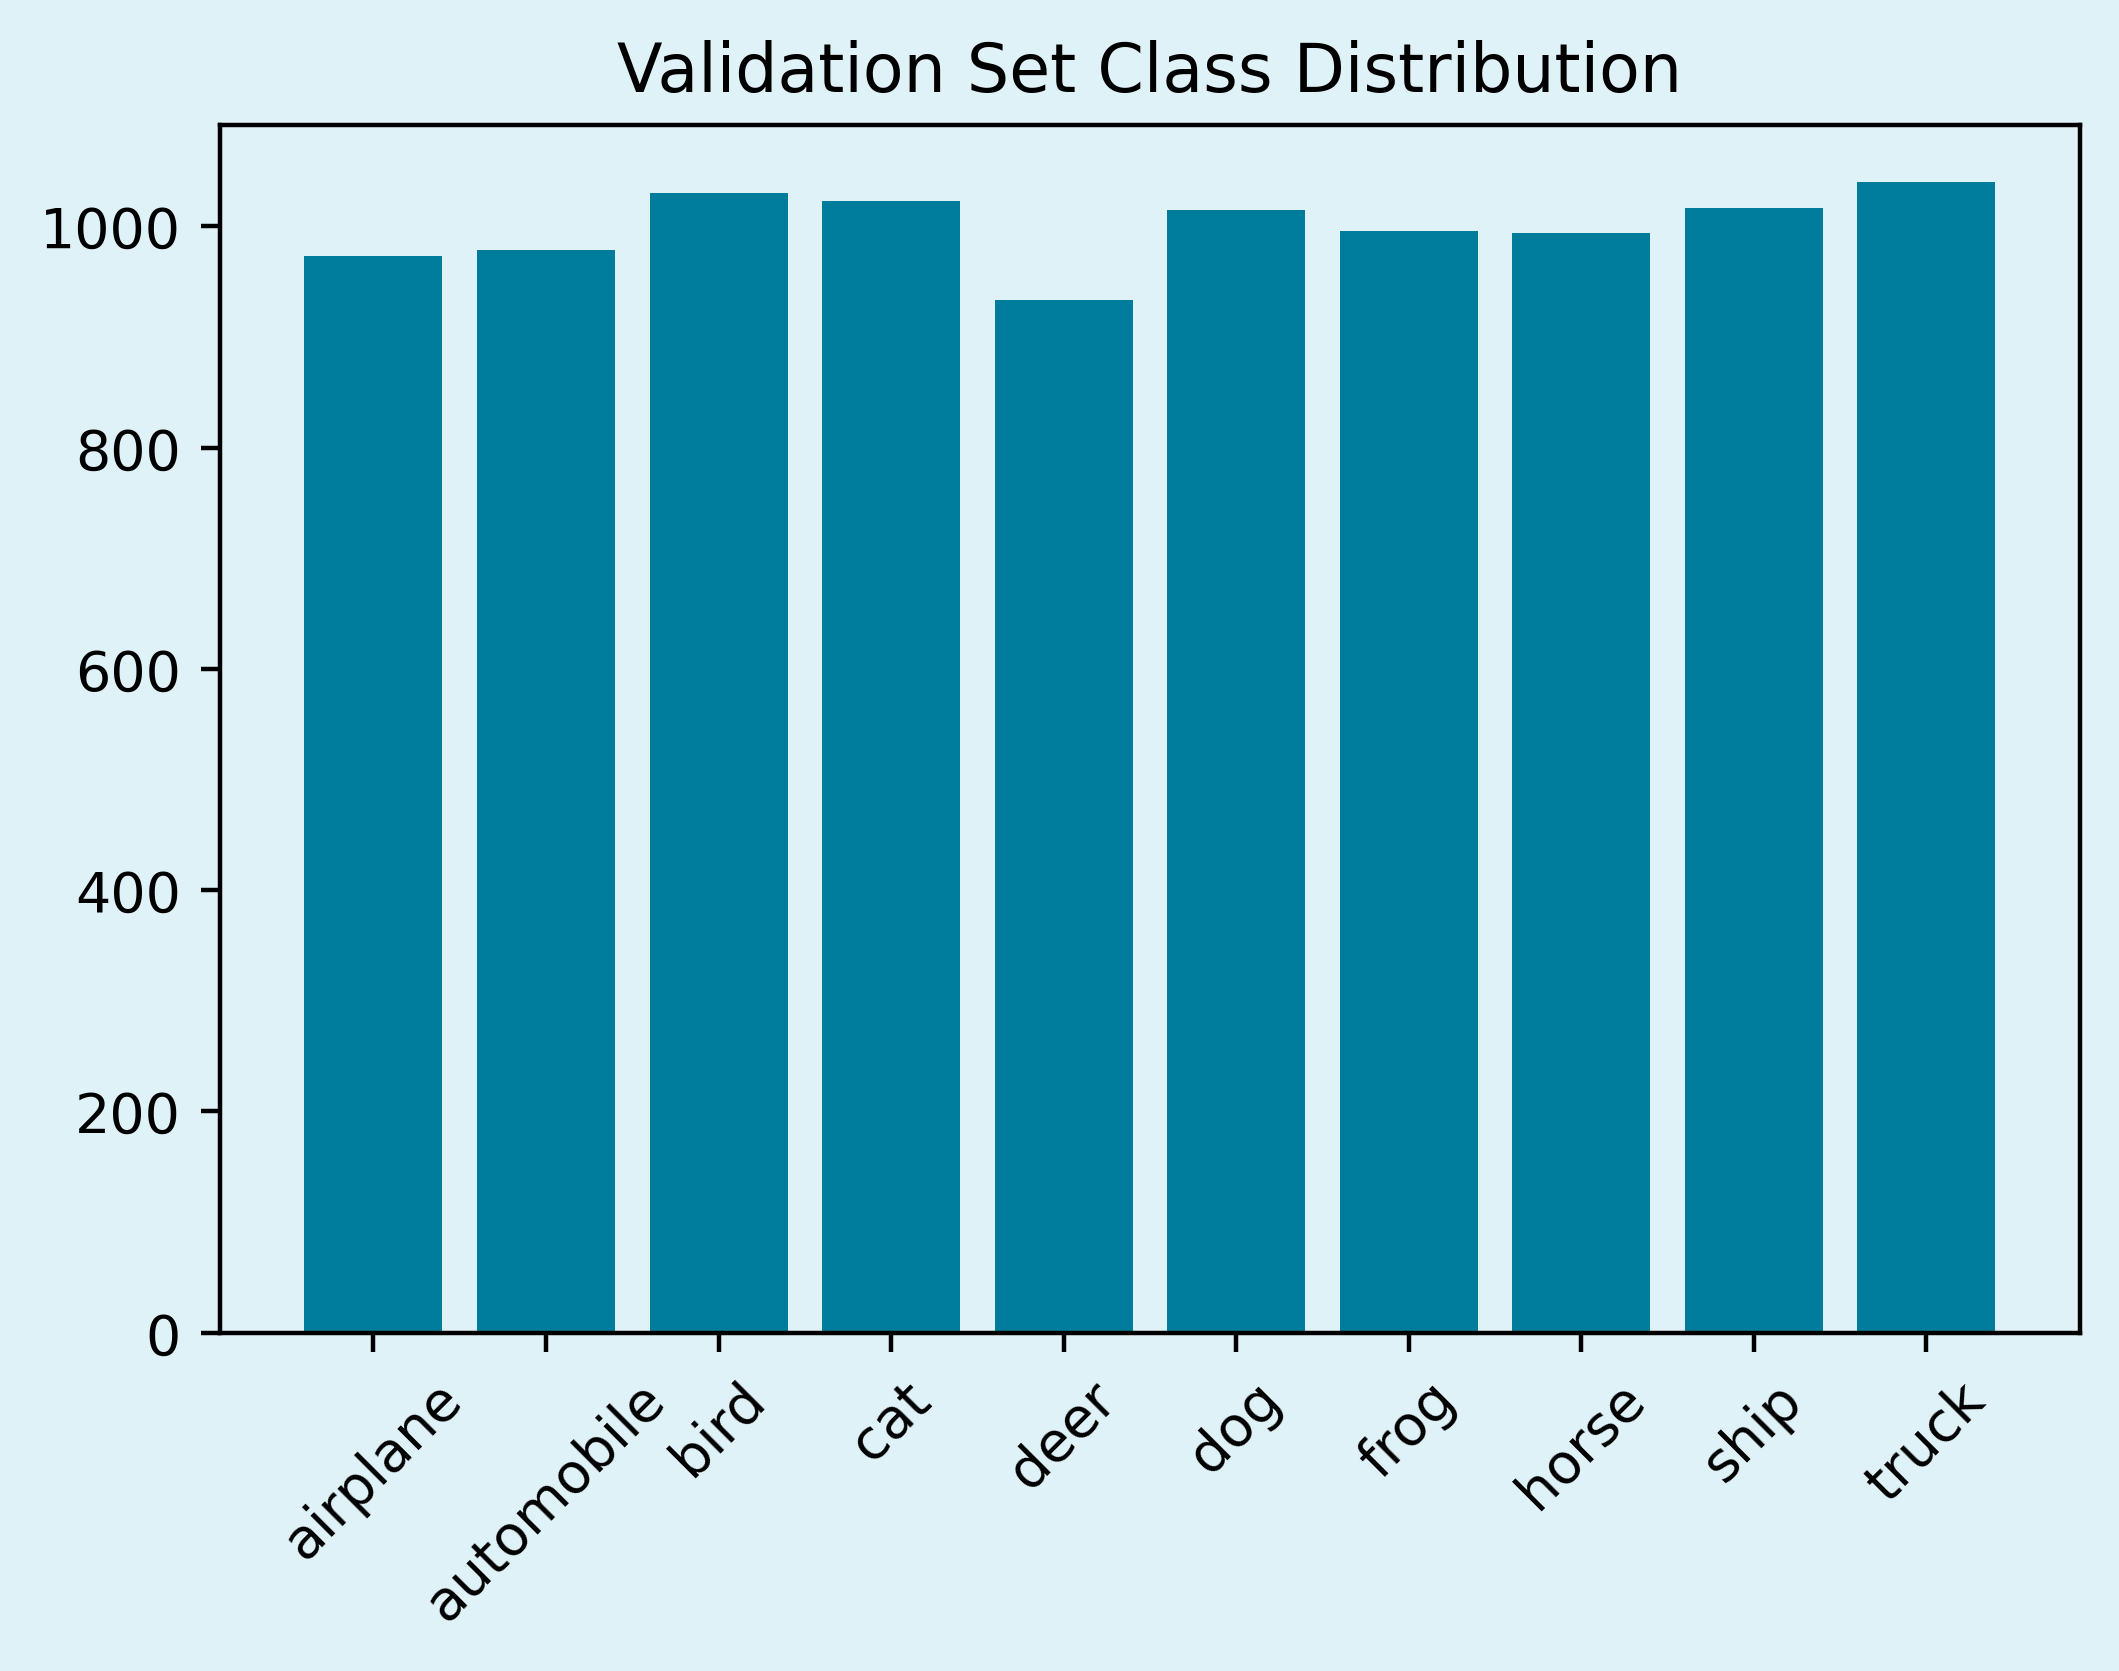

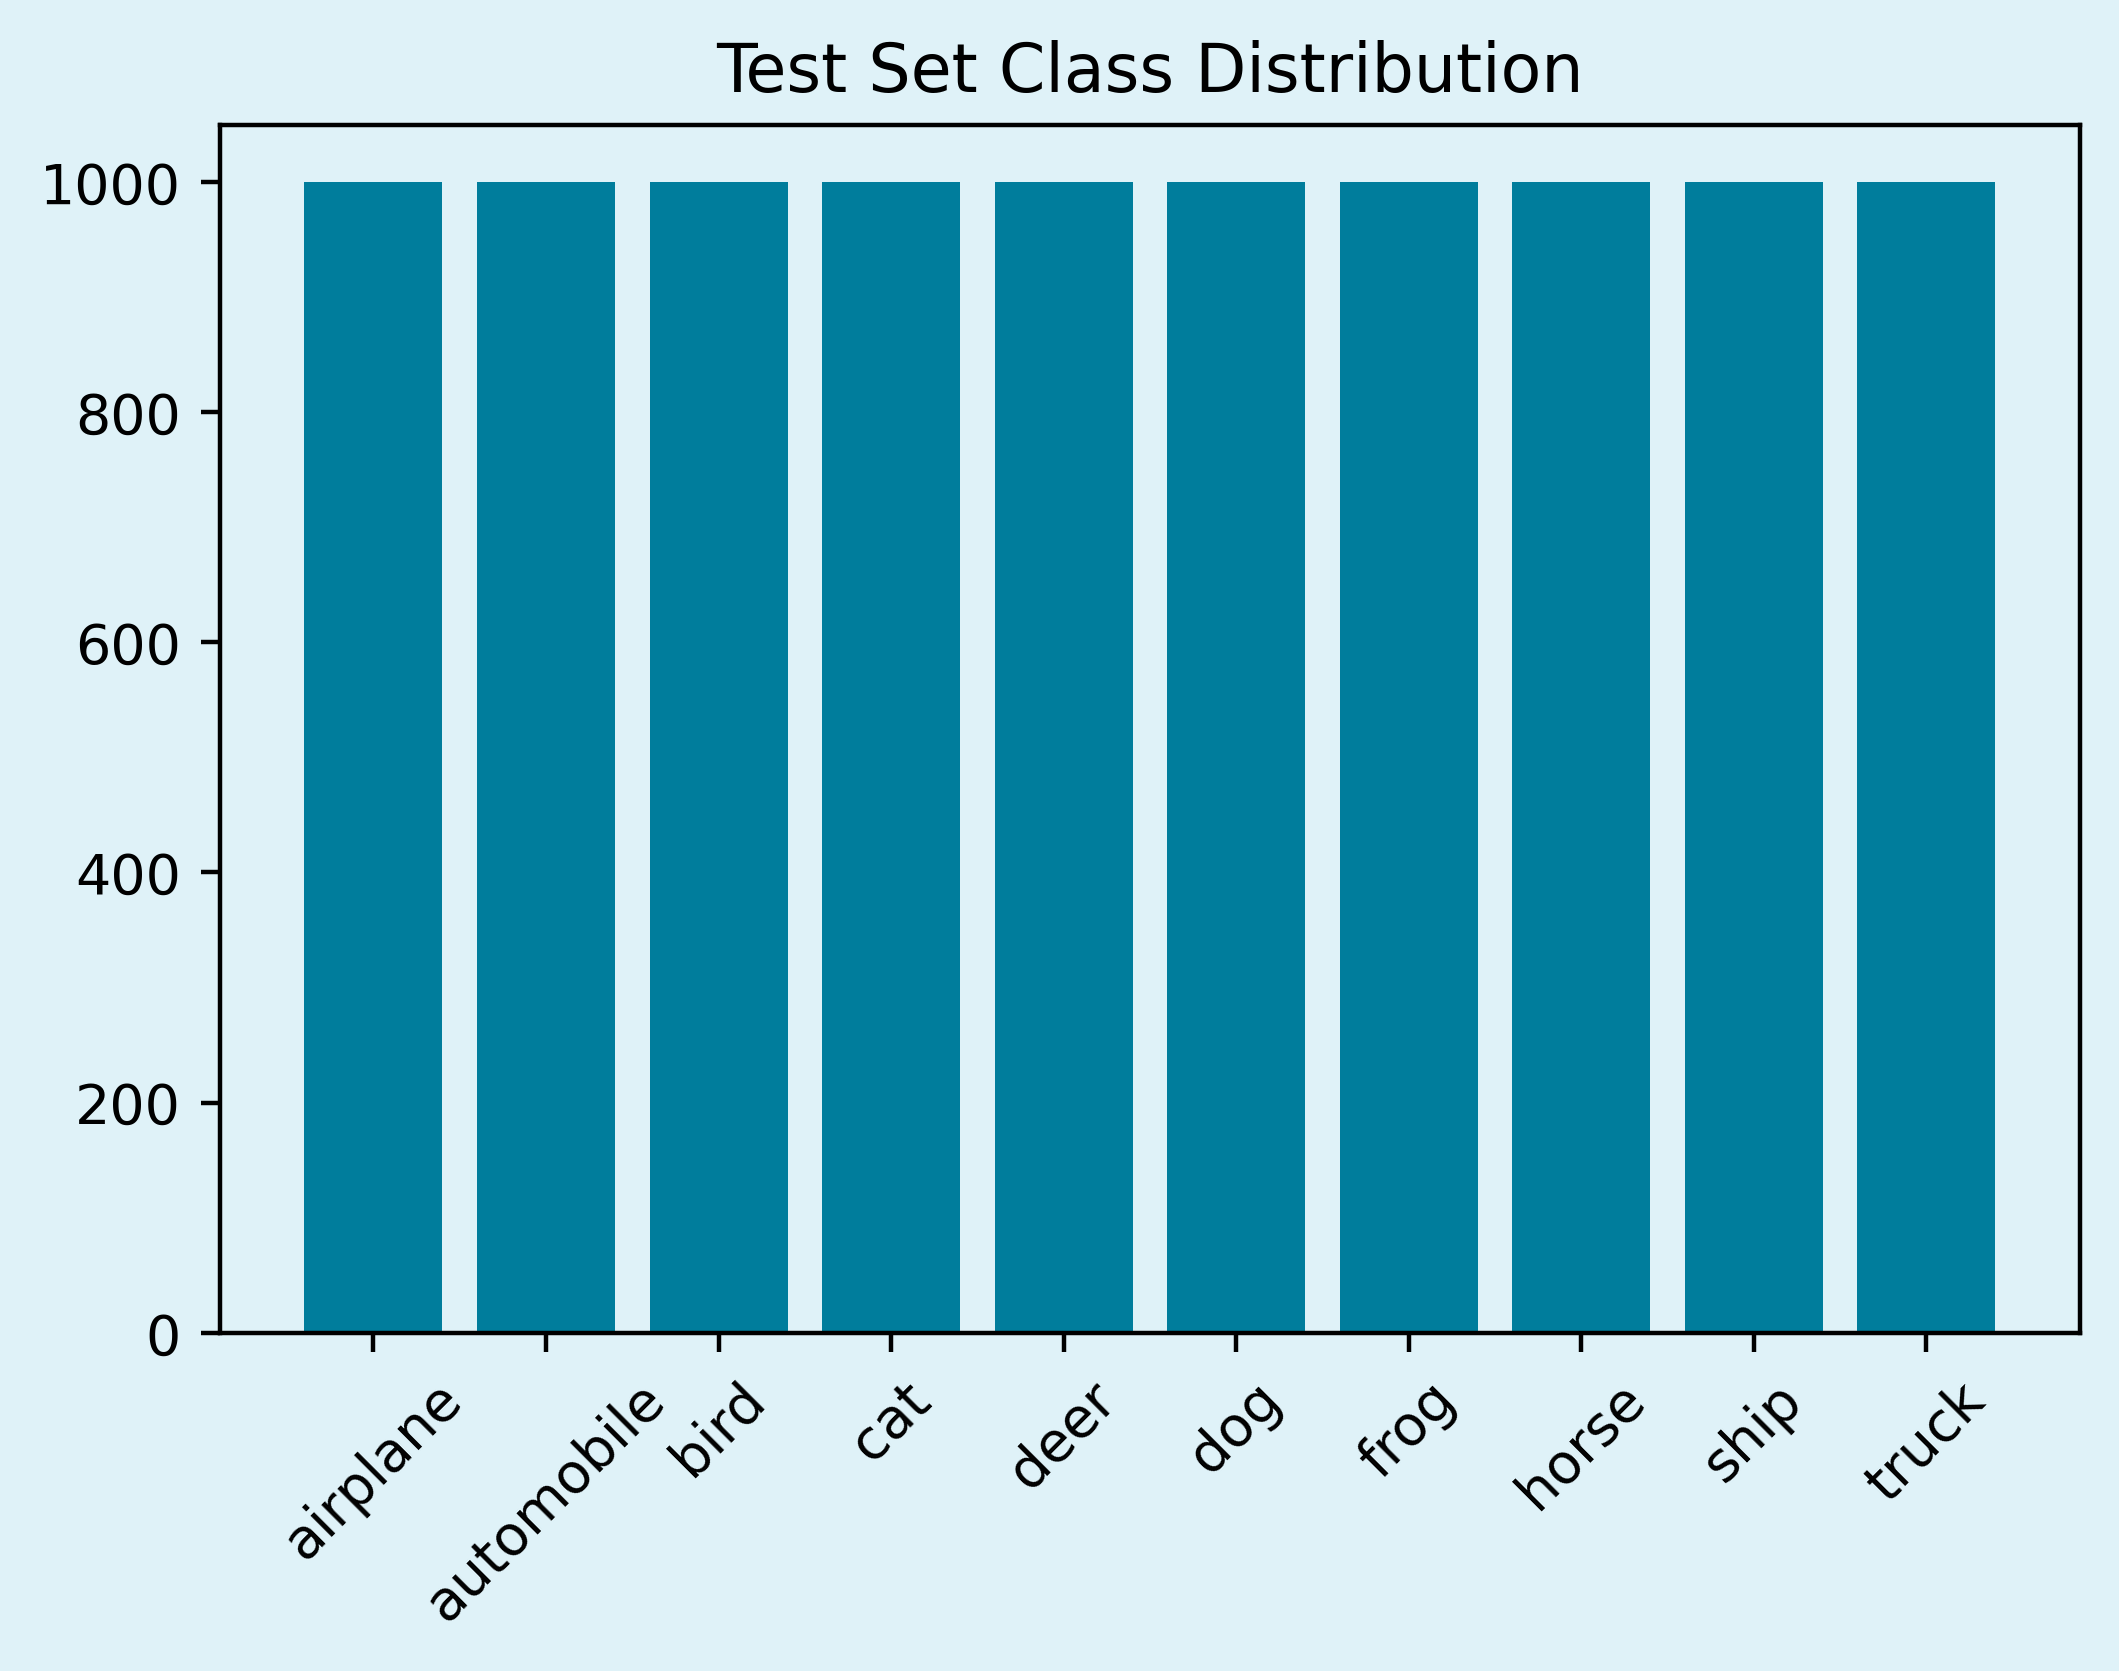

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].set_title(class_labels[y_train[i]].title(), fontsize=10)
    axes[i].axis('off')

# Adjust tight_layout to leave more space for title
plt.suptitle("Example Images from CIFAR-10", fontsize=16)
plt.subplots_adjust(hspace=0.8)  # Increase vertical space between rows
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Increase top margin to make space
plt.show()

# Class distribution
def plot_class_distribution(y_data, title):
    unique, counts = np.unique(y_data, return_counts=True)
    plt.bar(unique, counts, tick_label=class_labels)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Visualise class distribution after splitting
plot_class_distribution(y_train, "Training Set Class Distribution")
plot_class_distribution(y_val, "Validation Set Class Distribution")
plot_class_distribution(y_test, "Test Set Class Distribution")

[6 2 5 6 3]


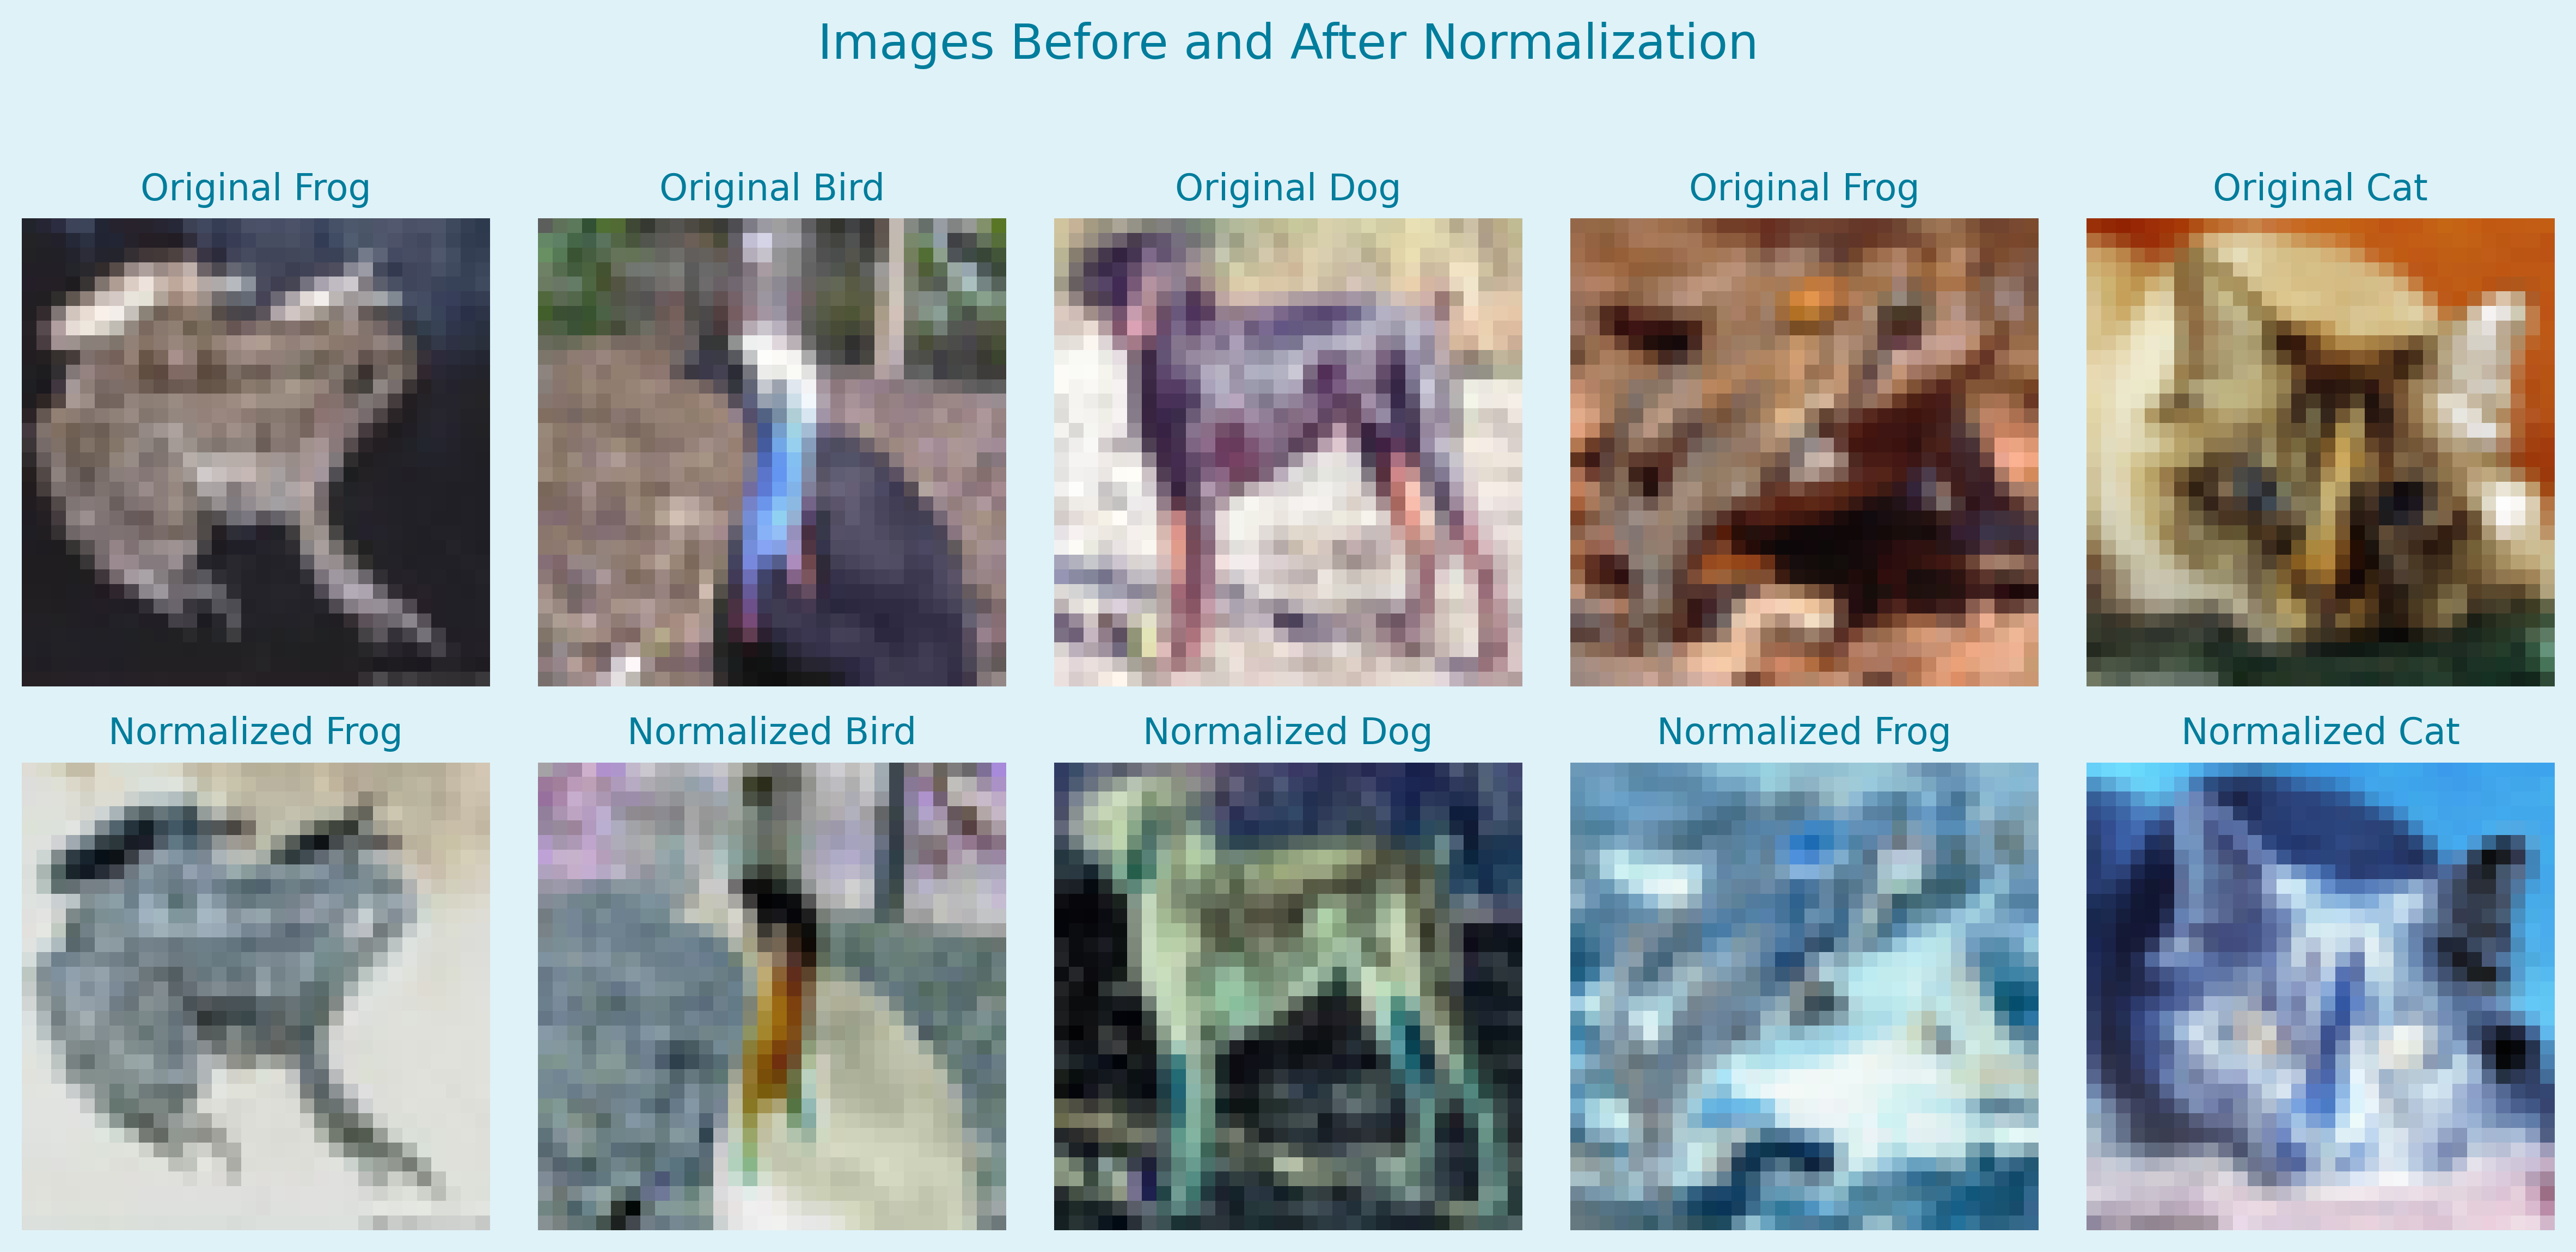

In [12]:
# Visualise images before and after normalisation
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.8)  # Increase vertical space between rows
print(y_train[:5])  # Check first 5 labels

for i in range(5):
    axes[0, i].imshow(x_train[i])  # Before normalisation
    axes[0, i].set_title(f"Original {class_labels[y_train[i]].title()}", color='#007d9c')
    axes[0, i].axis('off')

    axes[1, i].imshow((x_train[i] * 255))  # After normalisation
    axes[1, i].set_title(f"Normalized {class_labels[y_train[i]].title()}", color='#007d9c')
    axes[1, i].axis('off')

plt.suptitle("Images Before and After Normalization", fontsize=16, color='#007d9c')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
# Normalise and split
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(f"Number of validation images: {len(x_val)}")

Number of validation images: 8000


In [14]:
# One-hot encode
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

## Data Augmentation Visualisation

In [15]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

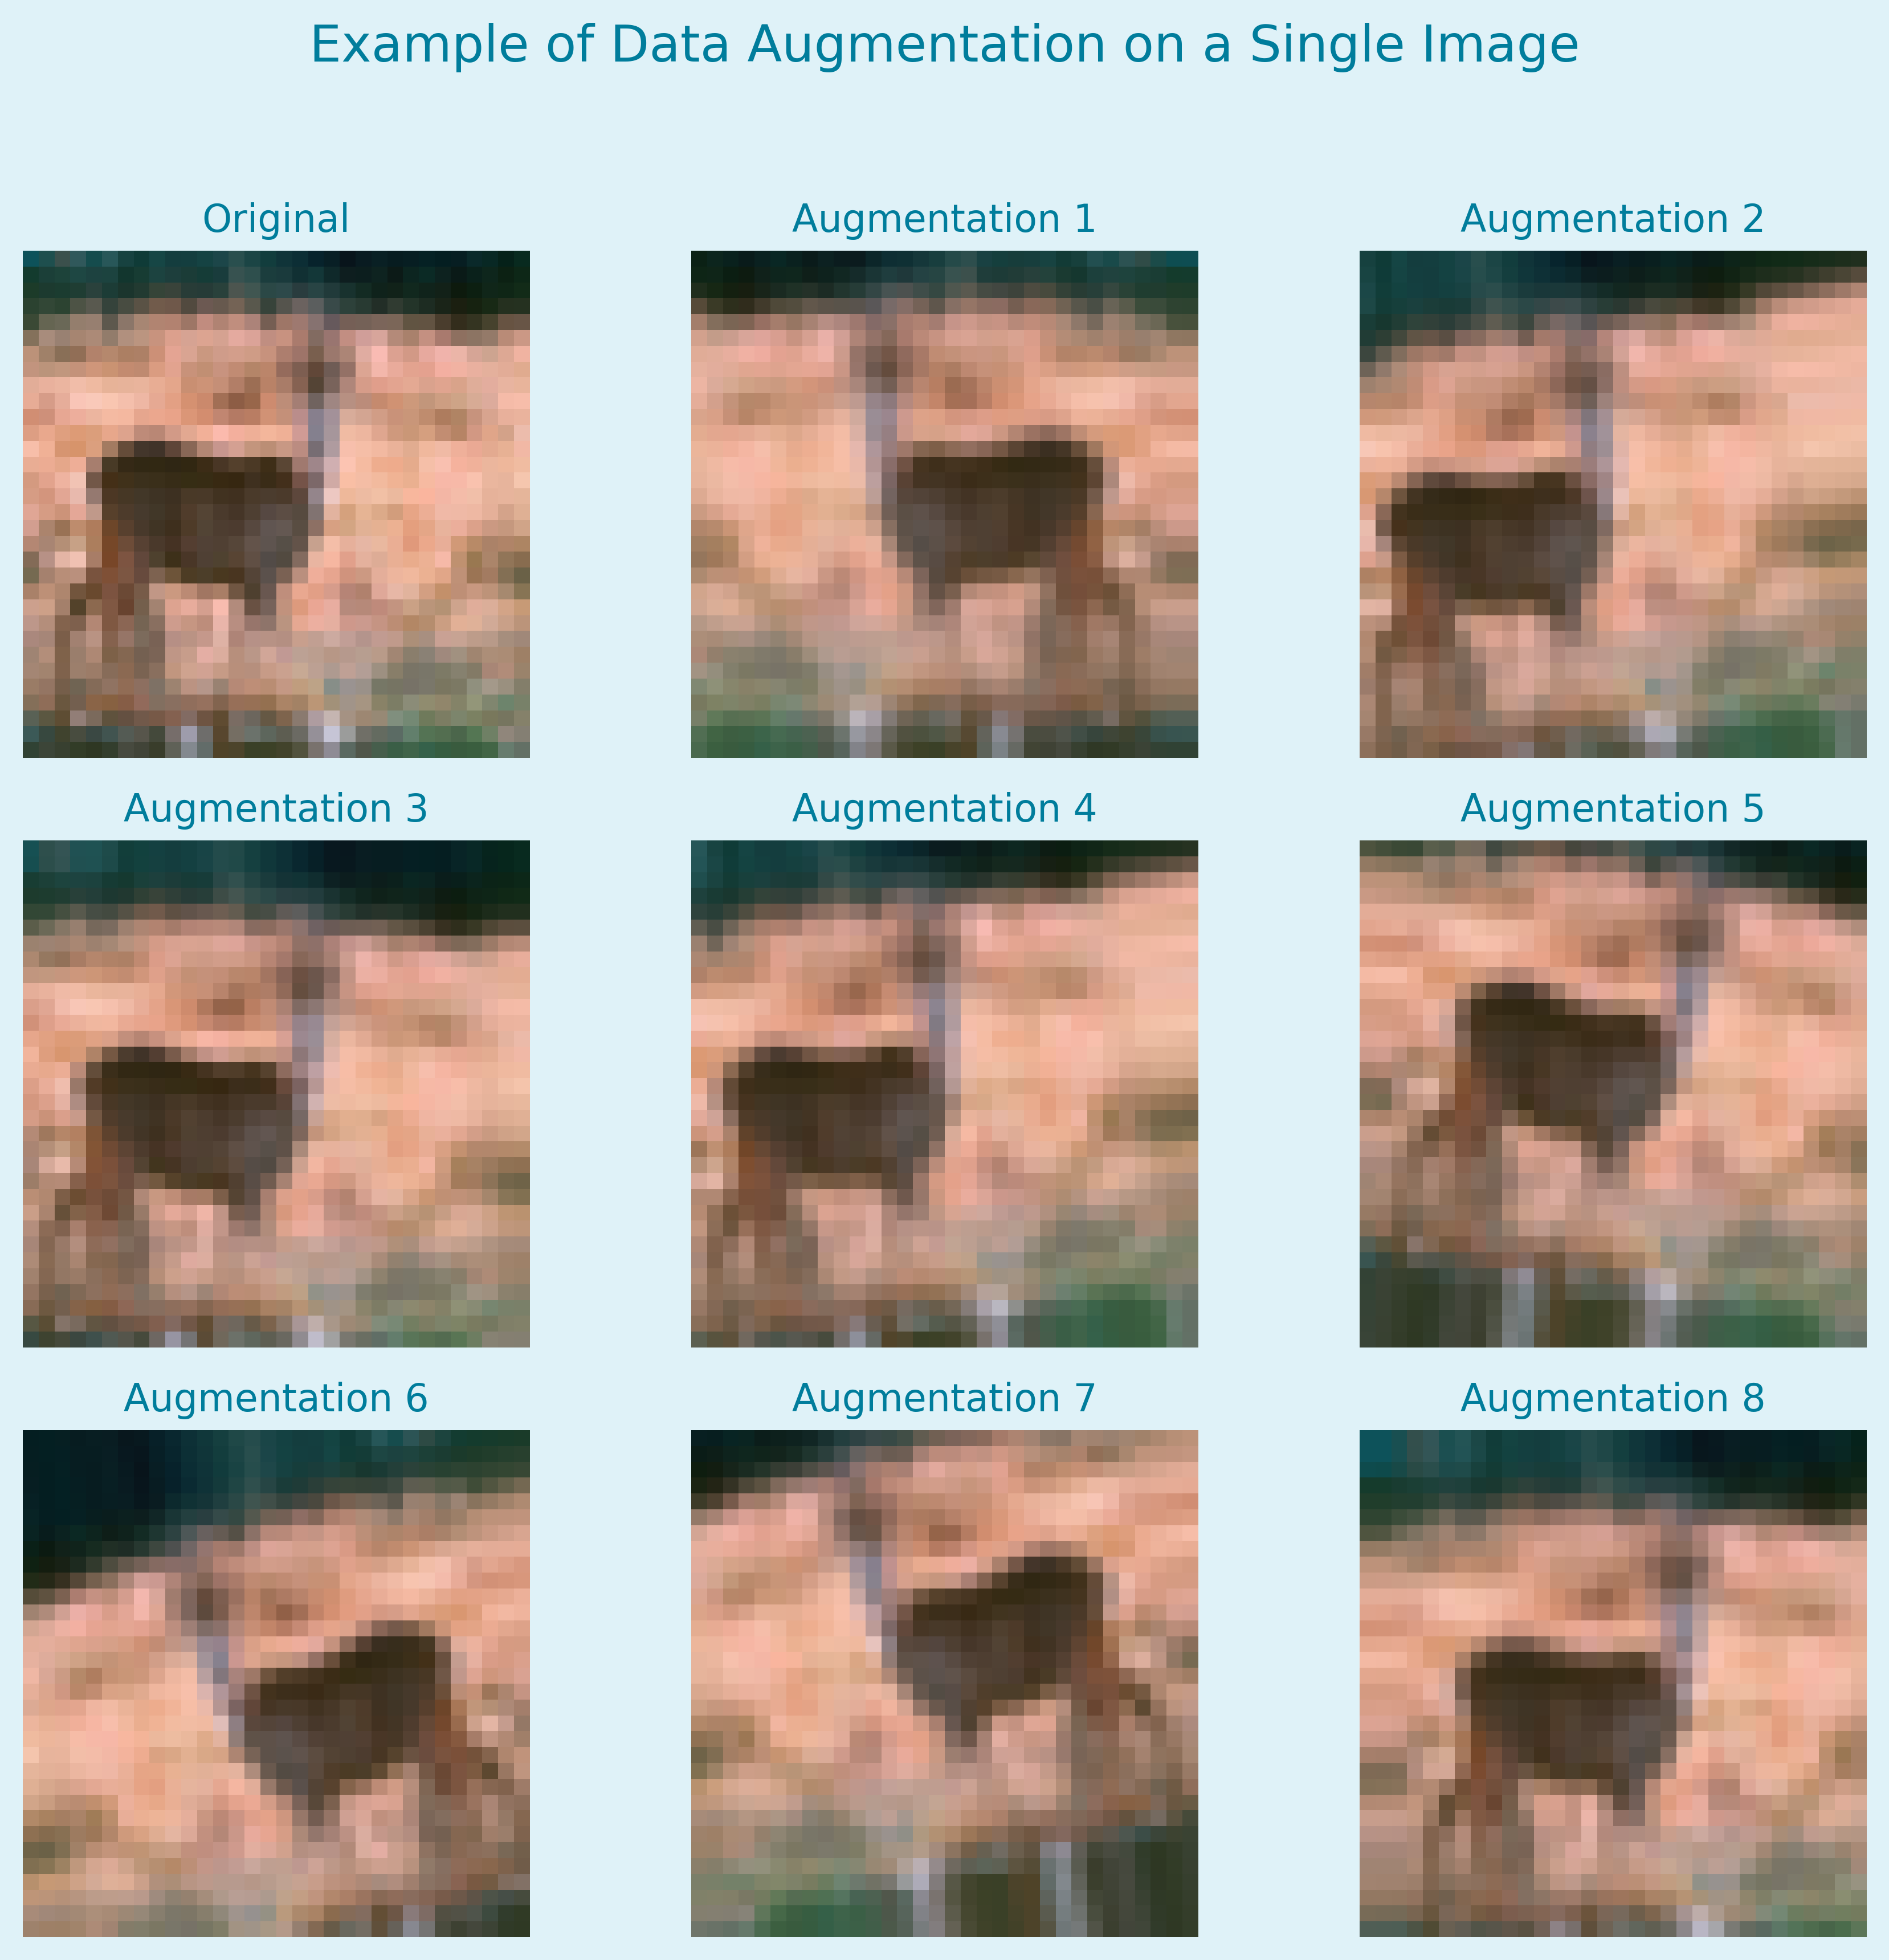

In [16]:
image_index = 0
original_image = x_train[image_index]

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes[0, 0].imshow(original_image)
axes[0, 0].set_title("Original", color='#007d9c')
axes[0, 0].axis('off')

# Generate augmentations and plot
for i in range(8):
    batch = next(datagen.flow(np.expand_dims(x_train[image_index], axis=0), batch_size=1))
    augmented_image = (batch[0] * 255).astype(np.uint8)
    axes.flatten()[i + 1].imshow(augmented_image)
    axes.flatten()[i + 1].axis('off')
    axes.flatten()[i + 1].set_title(f"Augmentation {i+1}", color='#007d9c')

plt.suptitle("Example of Data Augmentation on a Single Image", fontsize=16, color='#007d9c')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Model Definition and Training

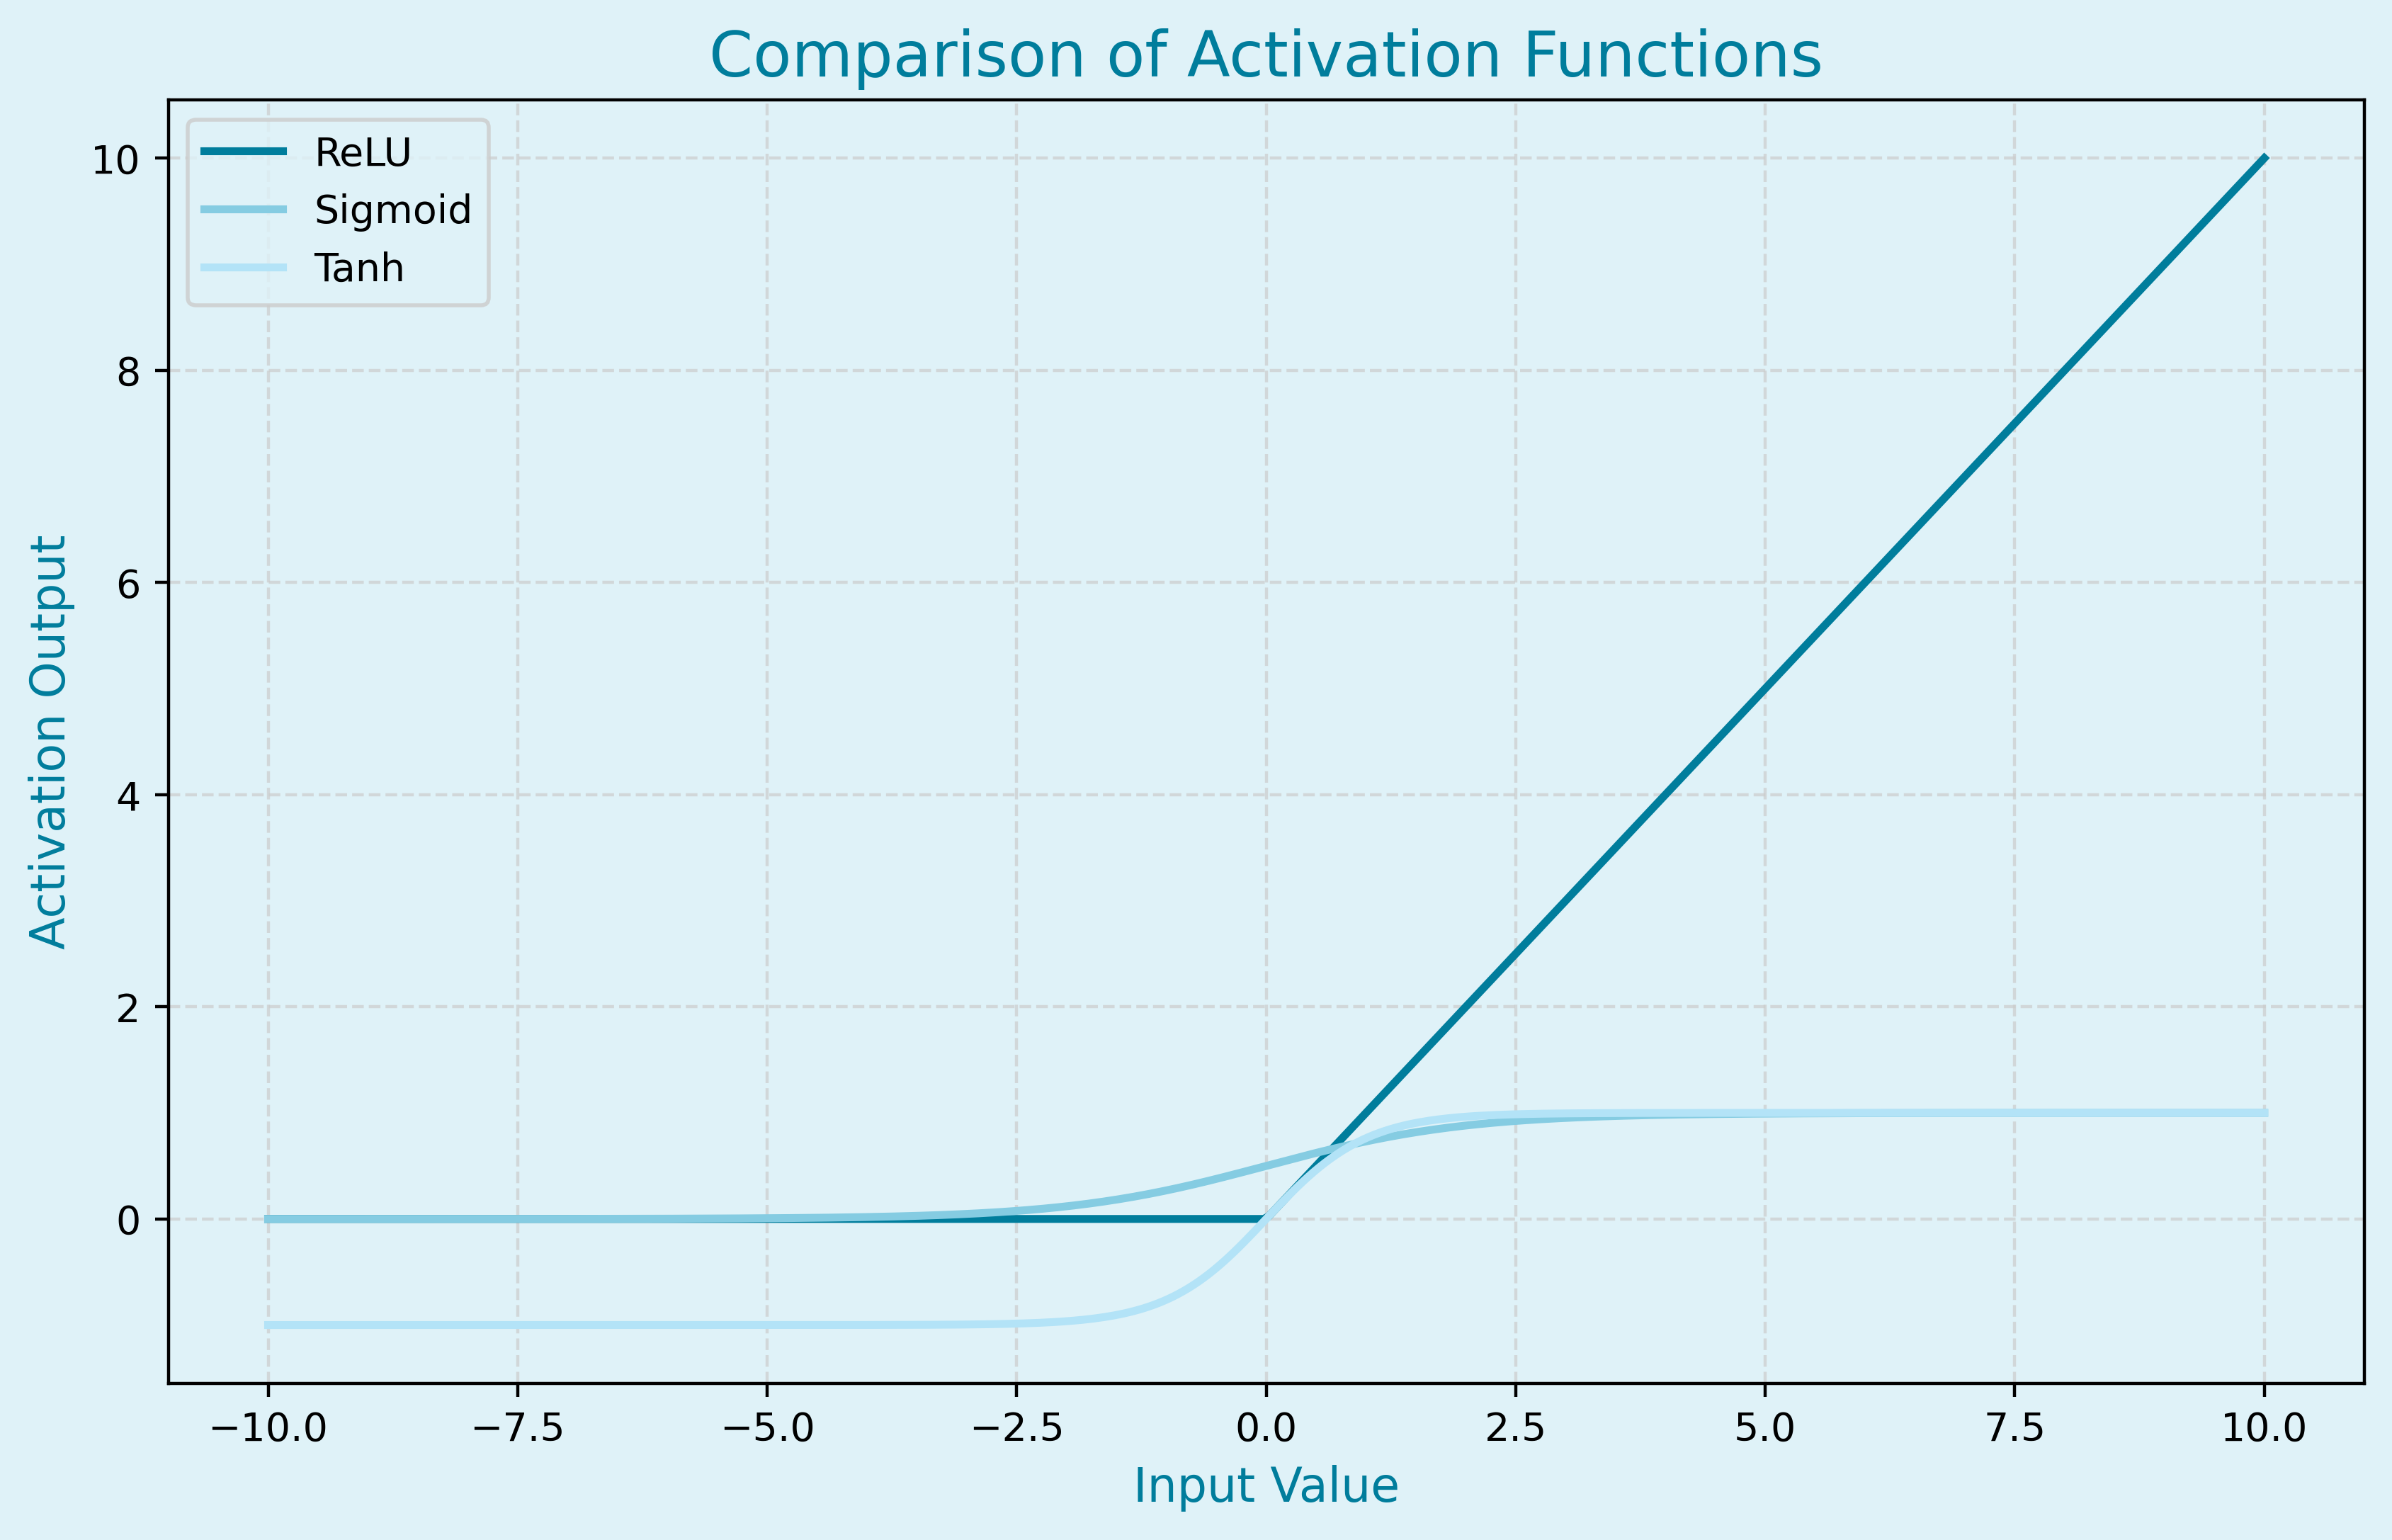

In [17]:
# Define activation functions
x = np.linspace(-10, 10, 400)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Calculate values
relu_vals = relu(x)
sigmoid_vals = sigmoid(x)
tanh_vals = tanh(x)

# Plot the activation functions
plt.figure(figsize=(10, 6))
plt.plot(x, relu_vals, label='ReLU', color='#007d9c', linewidth=2)
plt.plot(x, sigmoid_vals, label='Sigmoid', color='#85cce2', linewidth=2)
plt.plot(x, tanh_vals, label='Tanh', color='#b3e3f7', linewidth=2)

# Formatting
plt.title('Comparison of Activation Functions', fontsize=16, color='#007d9c')
plt.xlabel('Input Value', fontsize=12, color='#007d9c')
plt.ylabel('Activation Output', fontsize=12, color='#007d9c')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


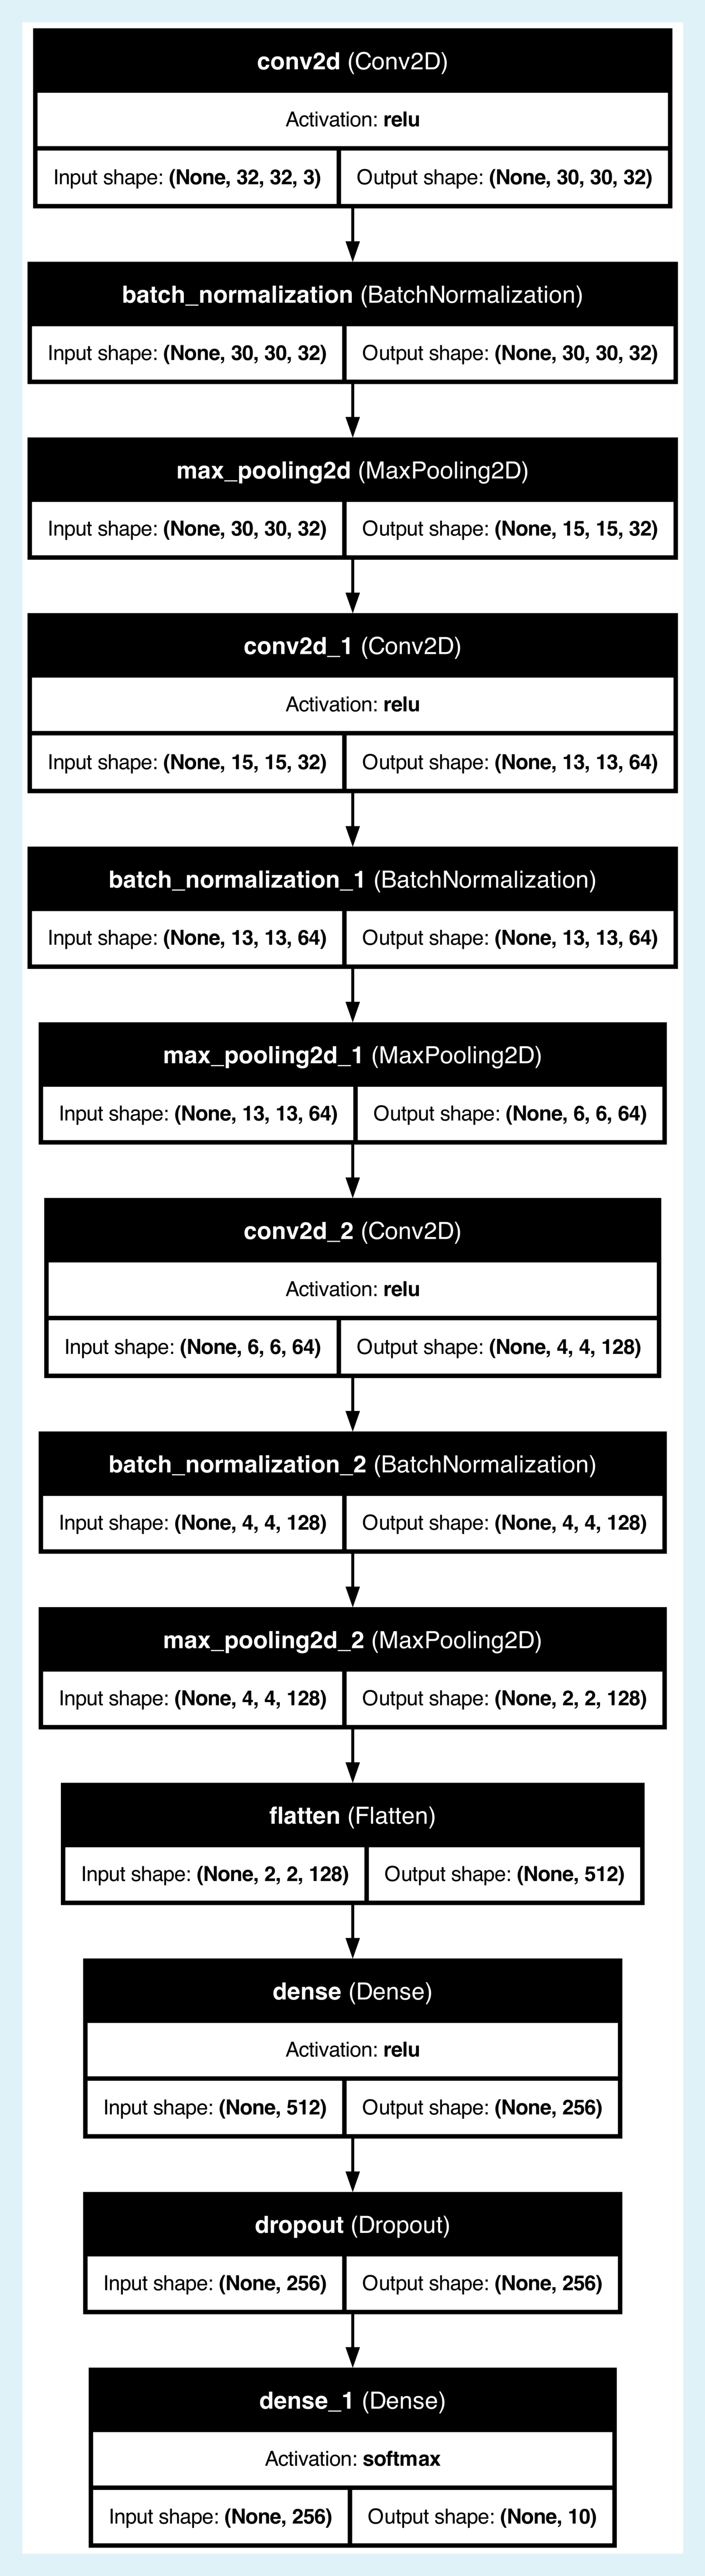

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.3287 - loss: 2.0839 - val_accuracy: 0.3840 - val_loss: 1.9179 - learning_rate: 0.0050
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.4863 - loss: 1.5556 - val_accuracy: 0.5351 - val_loss: 1.4442 - learning_rate: 0.0050
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.5323 - loss: 1.4307 - val_accuracy: 0.5240 - val_loss: 1.5301 - learning_rate: 0.0050
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.5665 - loss: 1.3471 - val_accuracy: 0.5995 - val_loss: 1.2846 - learning_rate: 0.0050
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5902 - loss: 1.2848 - val_accuracy: 0.5950 - val_loss: 1.2600 - learning_rate: 0.0050
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.6040 - loss: 1.2390 - val_accuracy: 0.5910 - val_loss: 1.2939 - learning_rate: 0.0050
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6254 - loss: 

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

plot_model(model, to_file='model_architecture.png', 
           show_shapes=True, 
           show_layer_names=True, 
           dpi=600, 
           rankdir='TB',  # Top to Bottom layout
           expand_nested=True,  # Expand nested layers if any
           show_layer_activations=True)

# Open the image and overlay with desired background color
img = plt.imread('model_architecture.png')
fig, ax = plt.subplots(figsize=(10, 15))
fig.patch.set_facecolor('#dff2f8')  # Set background color
ax.imshow(img)
ax.axis('off')
plt.show()

model.compile(optimizer=SGD(learning_rate=0.005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Can switch to 'val_accuracy'
    patience=10,         # Increase patience to allow more epochs before stopping
    min_delta=0.001,     # Require a small improvement to continue training
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_val, y_val),
                    epochs=100,
                    callbacks=[lr_reduction, early_stopping])

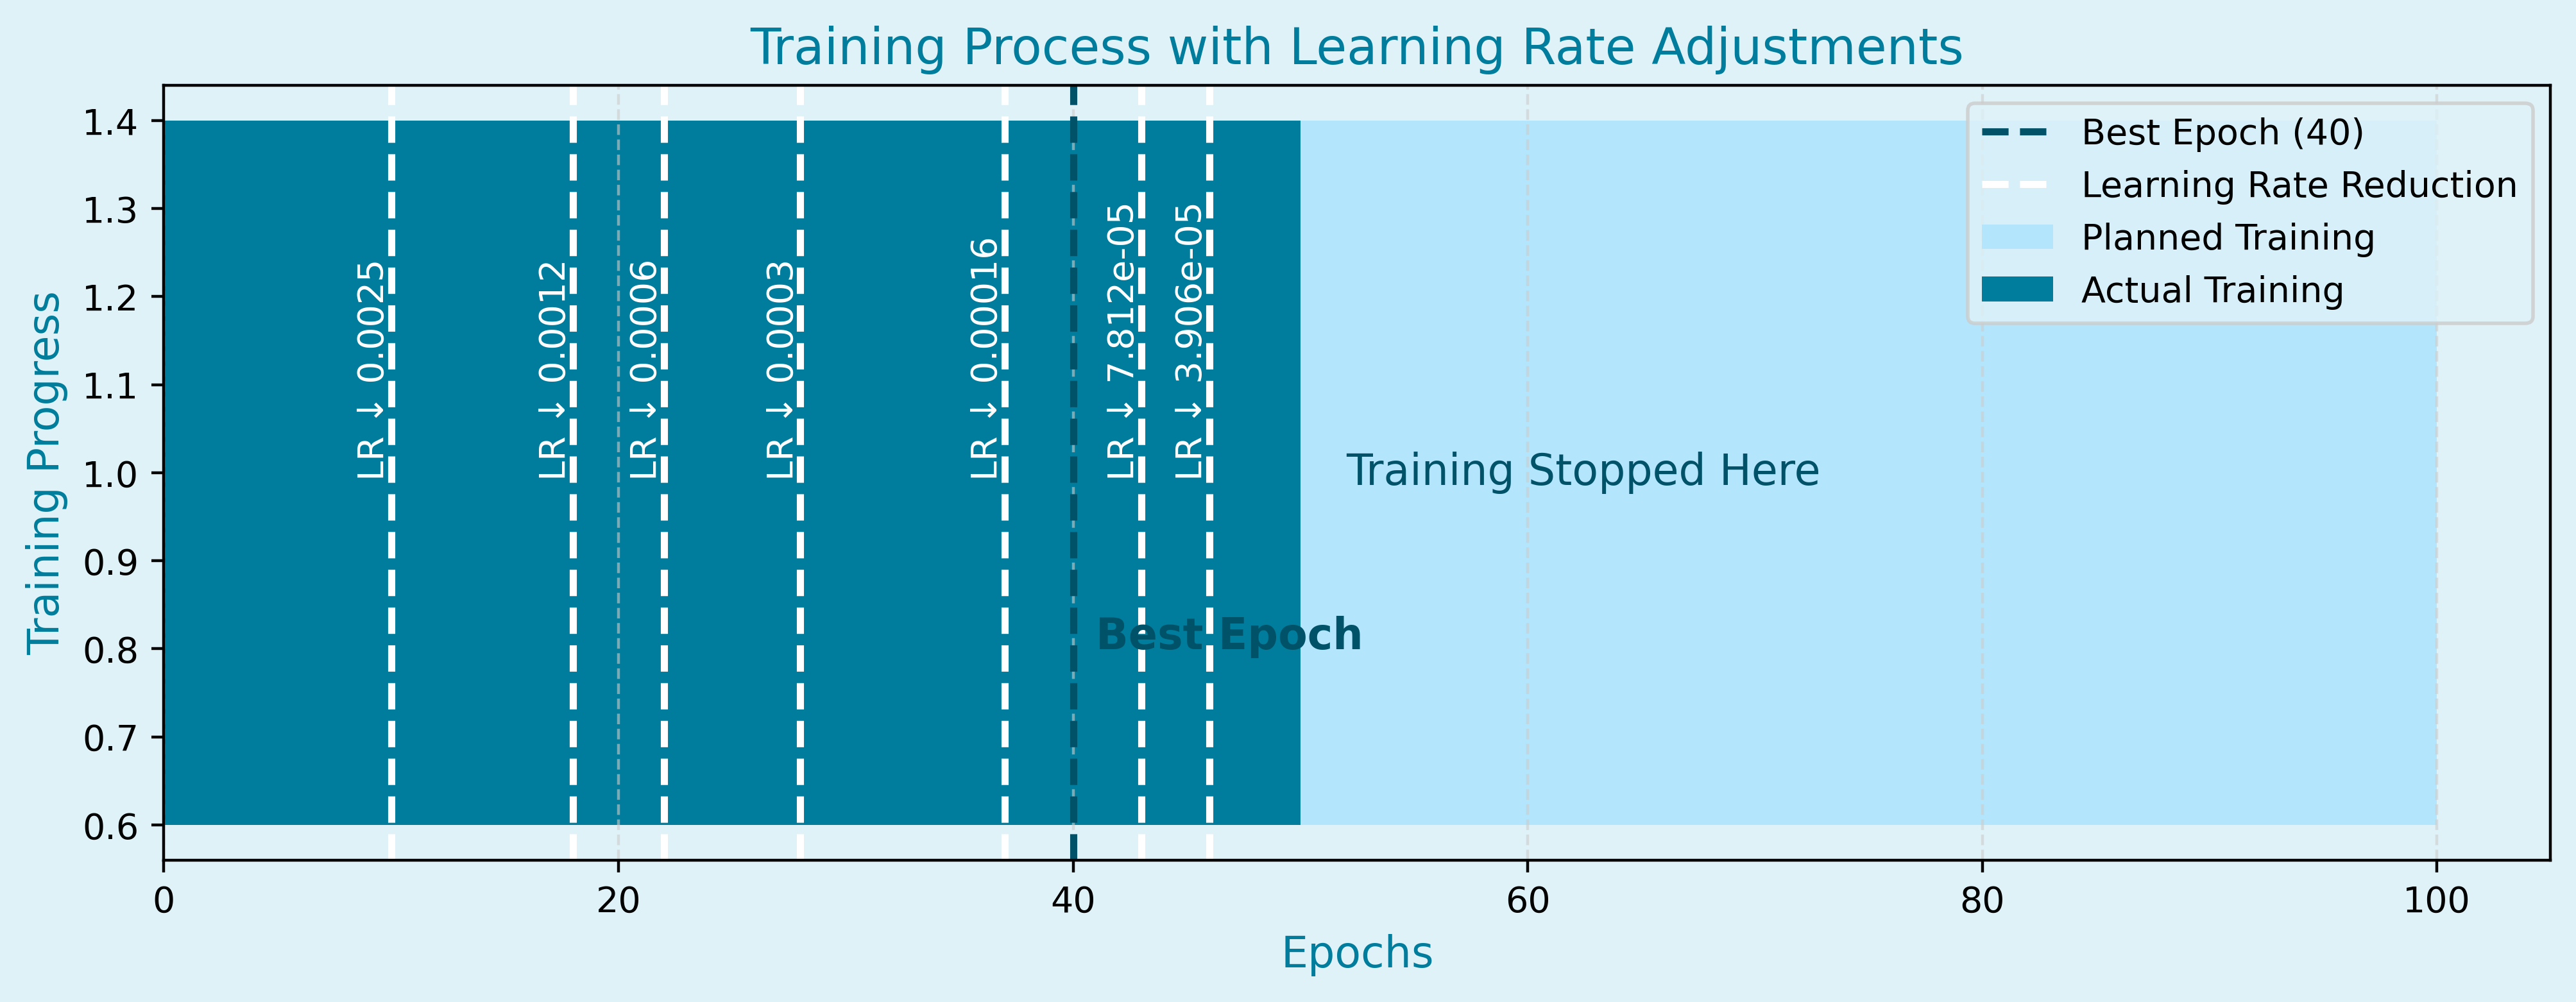

In [19]:
# Parameters for visualization
epochs = 100
actual_epochs = 50
best_epoch = 40
lr_reductions = [10, 18, 22, 28, 37, 43, 46]  # Epochs where learning rate was reduced
lr_values = ["0.0025", "0.0012", "0.0006", "0.0003", "0.00016", "7.812e-05", "3.906e-05"]

# Create plot
plt.figure(figsize=(12, 4))
plt.barh(y=1, width=epochs, color='#b3e5fc', label="Planned Training")  # Planned training
plt.barh(y=1, width=actual_epochs, color='#007d9c', label="Actual Training")  # Actual training

# Learning rate reduction annotations
for idx, lr_epoch in enumerate(lr_reductions):
    plt.axvline(lr_epoch, color='white', linestyle='--')
    plt.text(lr_epoch, 1.0, f'LR ↓ {lr_values[idx]}', rotation=90, color='white', ha='right', fontsize=10)

# Best epoch annotation
plt.axvline(best_epoch, color='#005268', linestyle='--', label="Best Epoch (40)")
plt.text(best_epoch + 1, 0.8, "Best Epoch", color='#005268', fontsize=12, fontweight='bold')

# Add a dummy line for Learning Rate Reduction in the legend only
plt.plot([], [], color='white', linestyle='--', label="Learning Rate Reduction")

# Training stopped annotation
plt.text(actual_epochs + 2, 1, "Training Stopped Here", color='#005268', fontsize=12, ha='left', va='center')

# Labels and legend
plt.title("Training Process with Learning Rate Adjustments", fontsize=14, color='#007d9c')
plt.xlabel("Epochs", fontsize=12, color='#007d9c')
plt.ylabel("Training Progress", fontsize=12, color='#007d9c')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show plot
plt.show()


## Model Evaluation and Visualization

In [20]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

model.save('/Users/reecelance/Desktop/cifar10_model.keras')
print("Model saved successfully.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7896 - loss: 0.7004
Test Accuracy: 0.79
Model saved successfully.


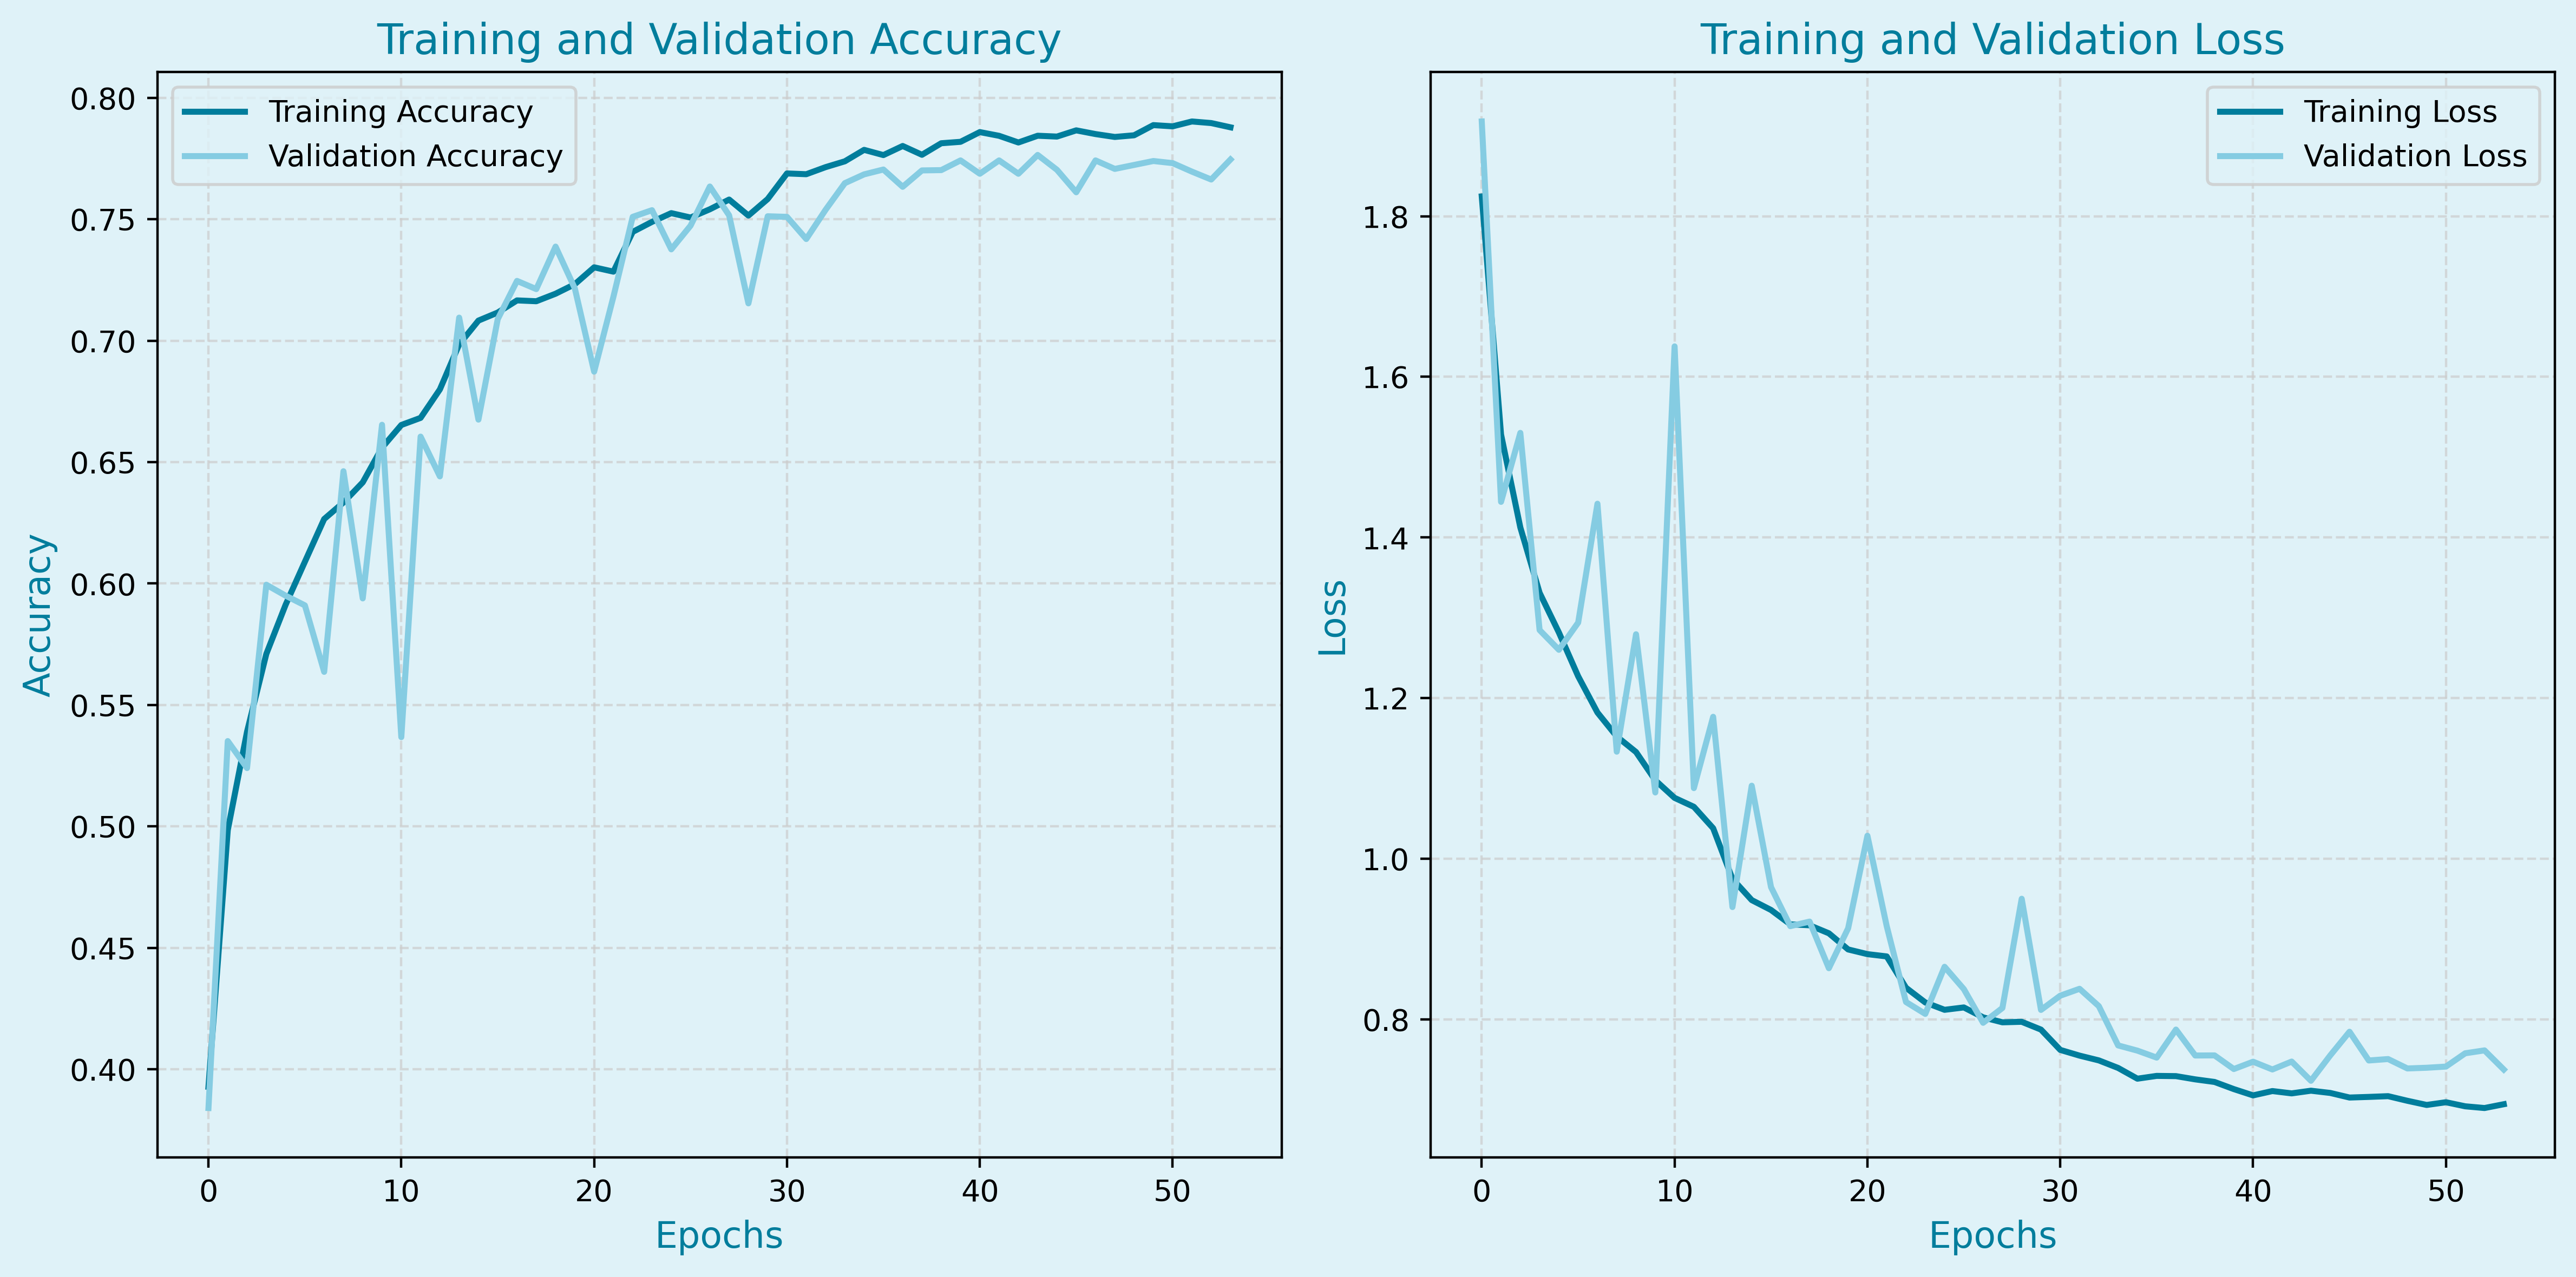

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.84      0.82      1000
  automobile       0.87      0.91      0.89      1000
        bird       0.80      0.62      0.70      1000
         cat       0.69      0.56      0.62      1000
        deer       0.77      0.76      0.77      1000
         dog       0.76      0.66      0.71      1000
        frog       0.72      0.92      0.81      1000
       horse       0.76      0.87      0.81      1000
        ship       0.91      0.84      0.87      1000
       truck       0.80      0.88      0.84      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.78     10000
weighted avg       0.79      0.79      0.78     10000



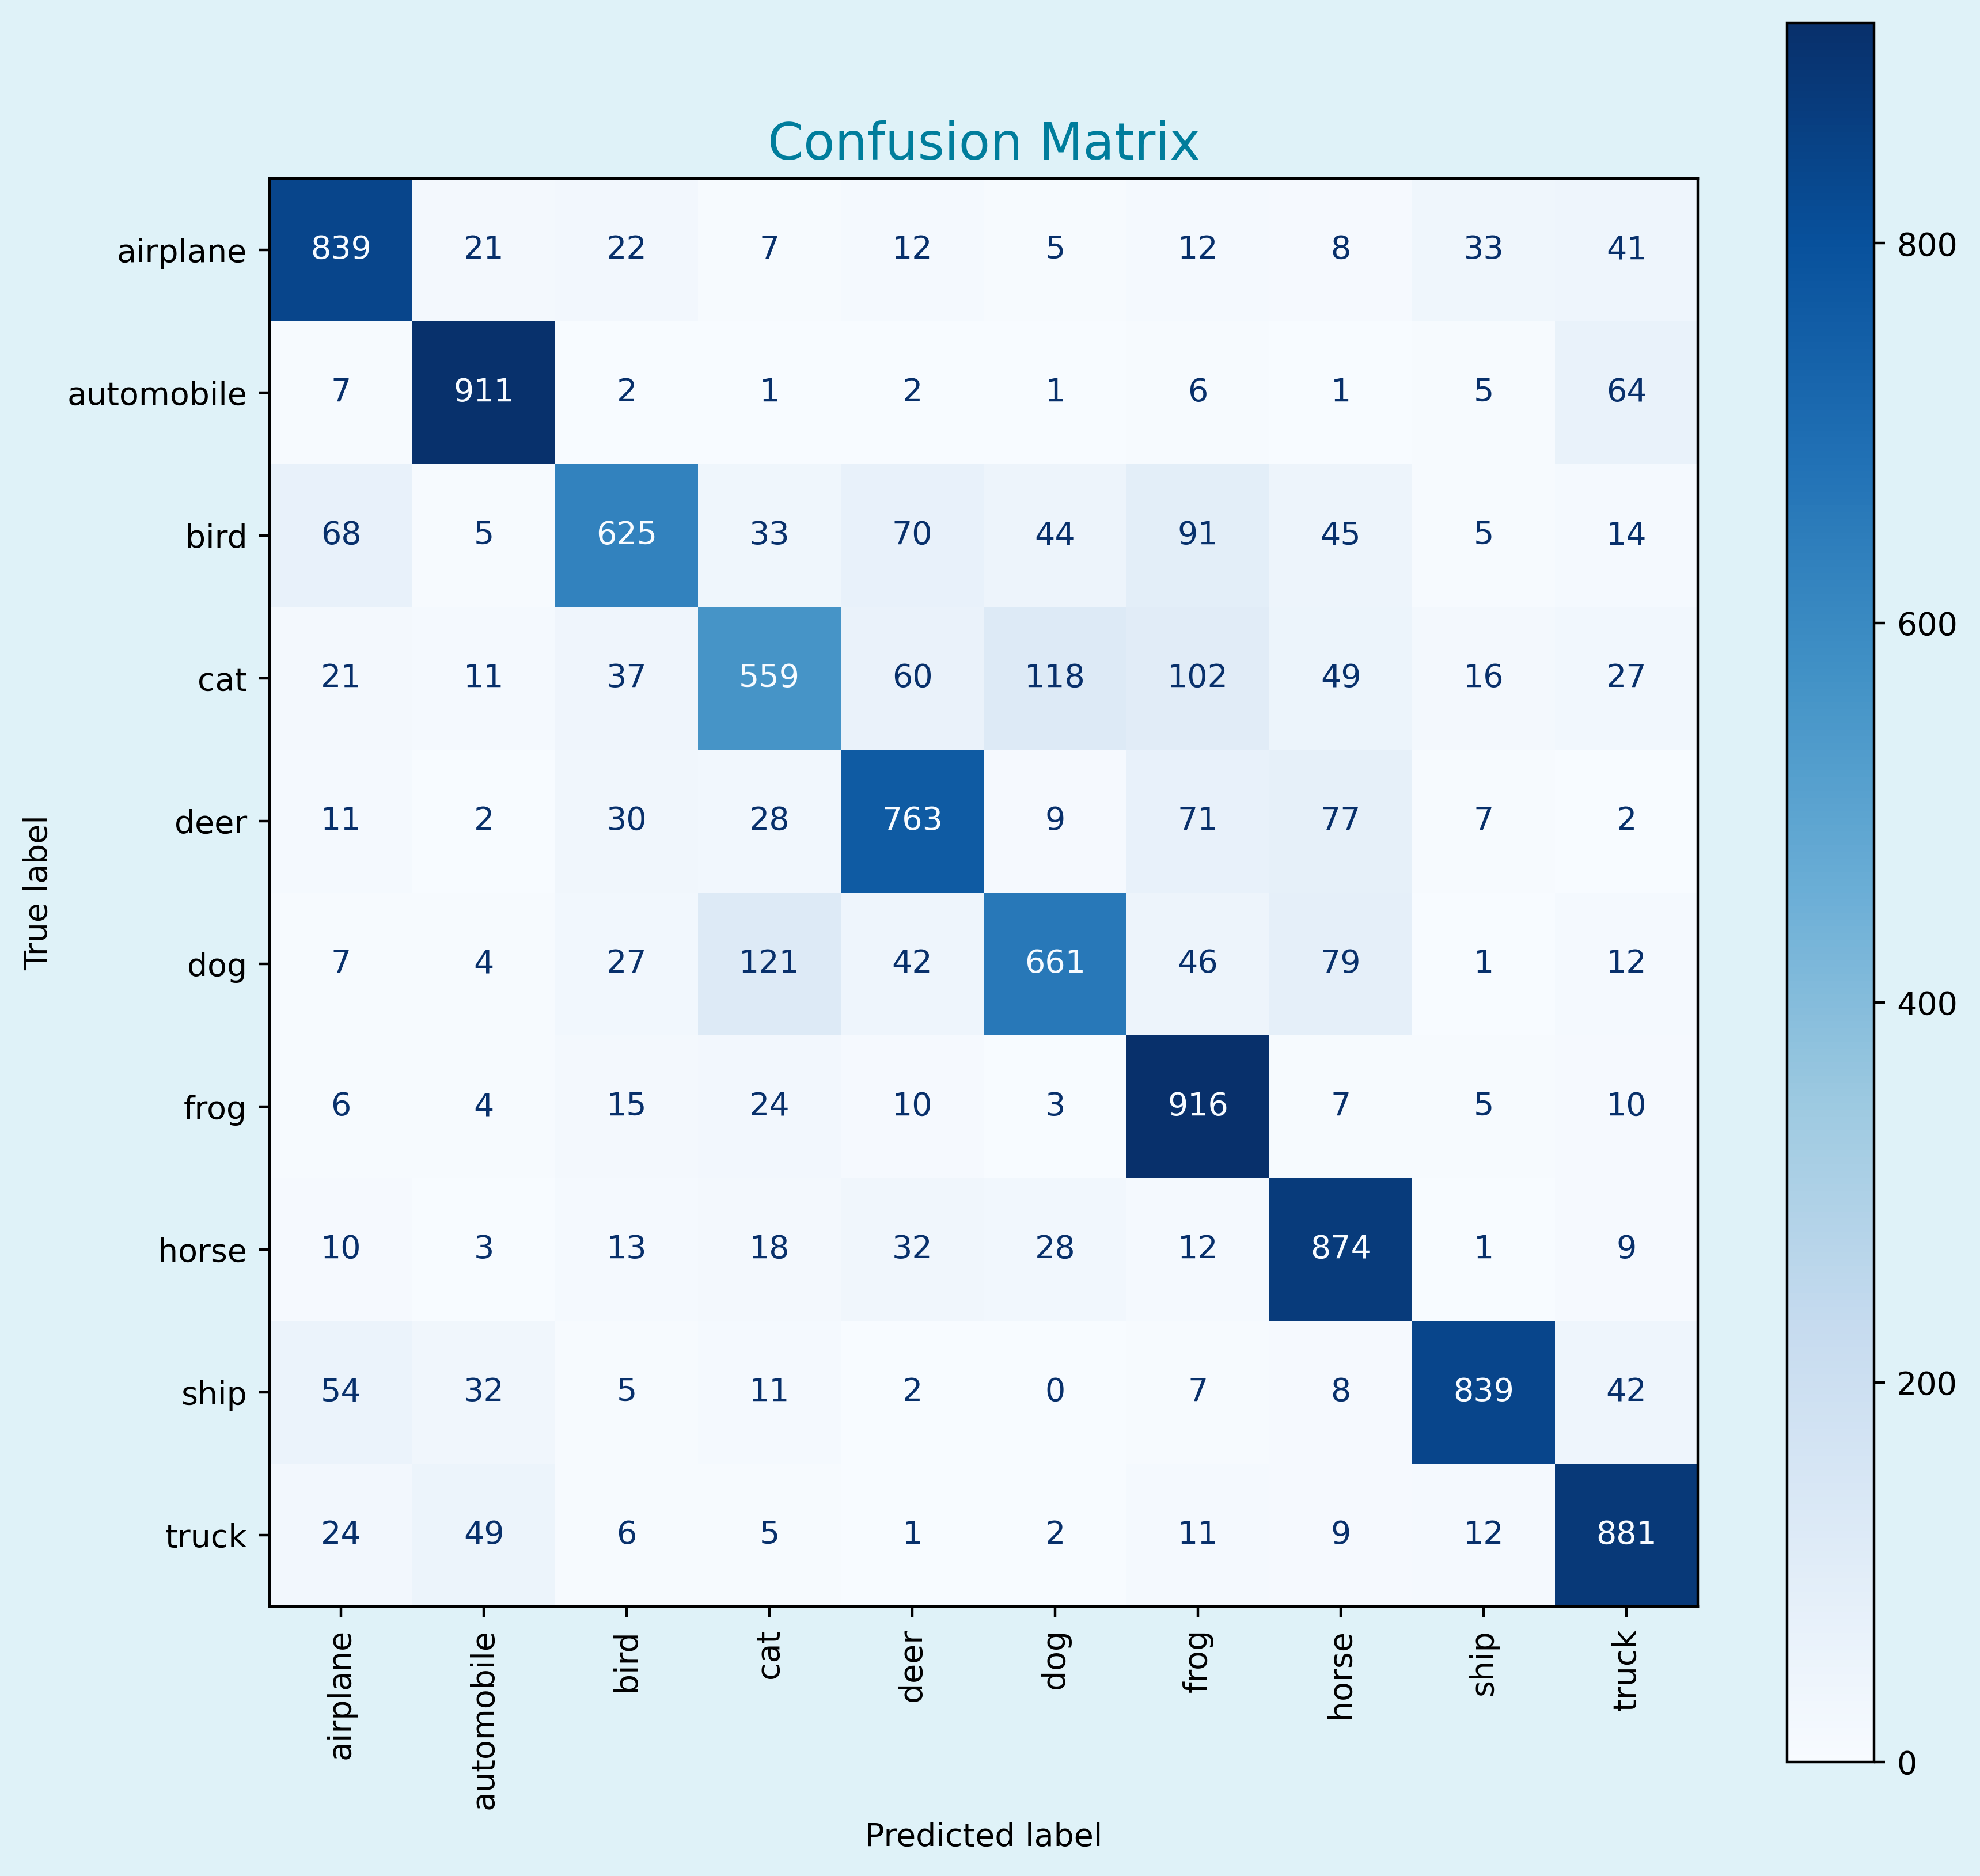

In [21]:
# Plot training history with updated colors
plt.figure(figsize=(12, 6))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#007d9c', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#85cce2', linewidth=2)
plt.xlabel('Epochs', fontsize=12, color='#007d9c')
plt.ylabel('Accuracy', fontsize=12, color='#007d9c')
plt.title('Training and Validation Accuracy', fontsize=14, color='#007d9c')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#007d9c', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#85cce2', linewidth=2)
plt.xlabel('Epochs', fontsize=12, color='#007d9c')
plt.ylabel('Loss', fontsize=12, color='#007d9c')
plt.title('Training and Validation Loss', fontsize=14, color='#007d9c')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')  # Added cmap and rotation
plt.title('Confusion Matrix', fontsize=16, color='#007d9c')
plt.grid(False)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


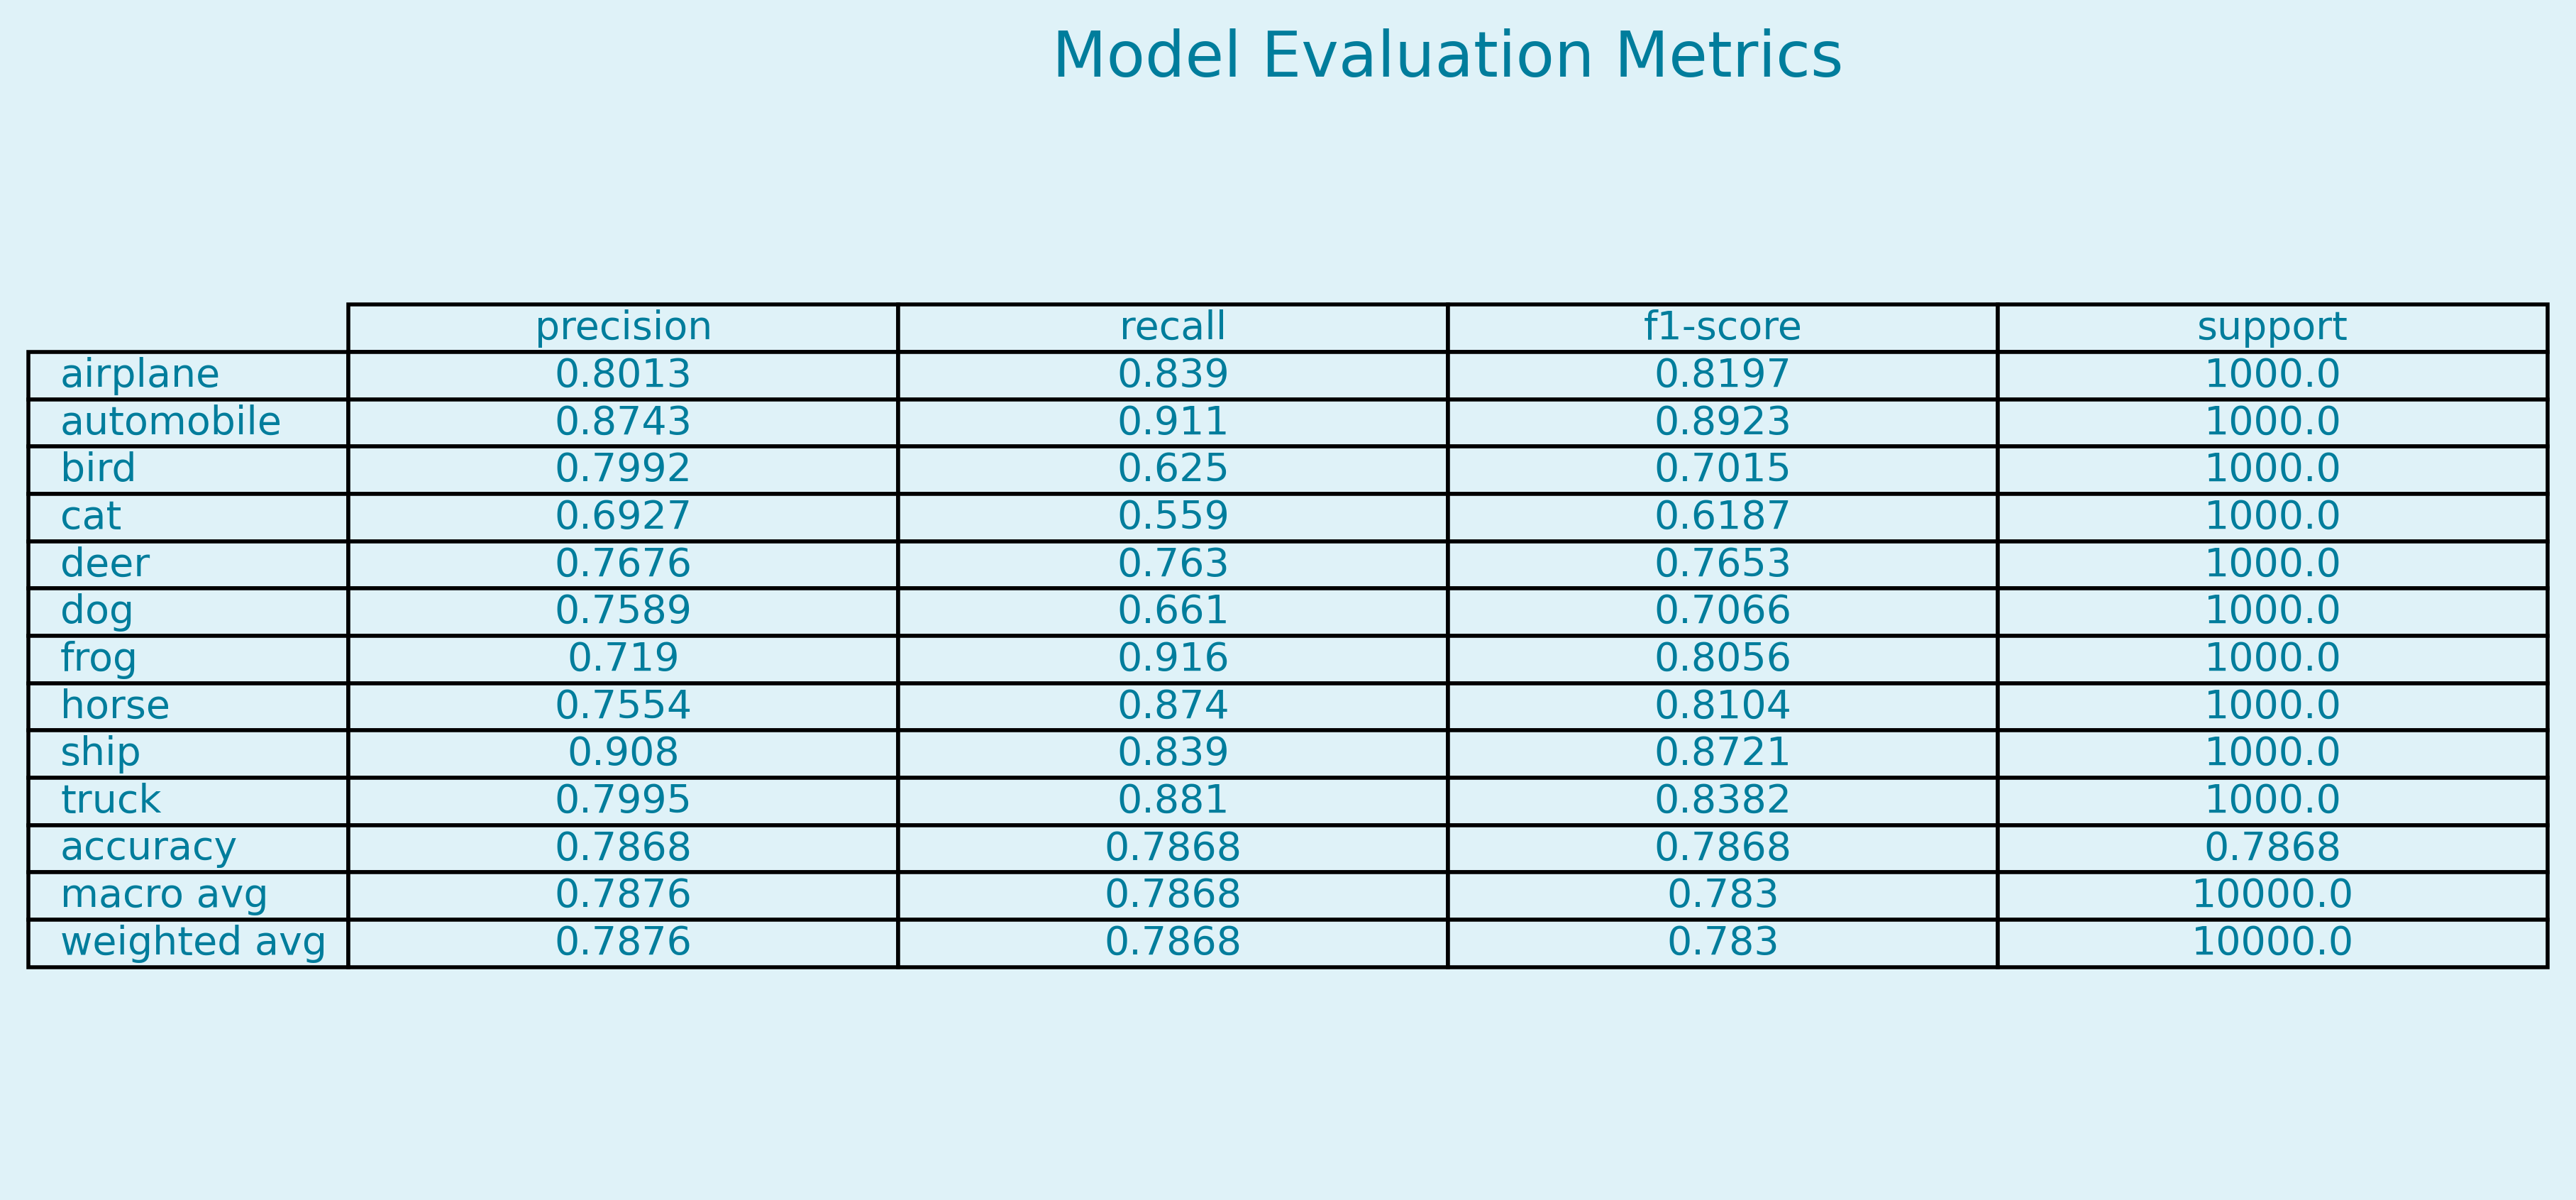

In [22]:
# Use the trained model to predict on test data
y_pred = model.predict(x_test)

# Convert one-hot encoded test labels to class indices
y_true = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Create a summary DataFrame for visualization
summary_df = pd.DataFrame(report_dict).transpose()
summary_df = summary_df[['precision', 'recall', 'f1-score', 'support']]

# Customize table display with updated colors
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Model Evaluation Metrics", fontsize=16, color='#007d9c')
ax.axis('tight')
ax.axis('off')

# Create a table with updated background and text colors
table = ax.table(cellText=summary_df.round(4).values,
                 colLabels=summary_df.columns,
                 rowLabels=summary_df.index,
                 cellLoc='center',
                 loc='center')

# Apply background and text color to all cells
for key, cell in table.get_celld().items():
    cell.set_facecolor('#dff2f8')  # Set background color
    cell.set_text_props(color='#007d9c', fontsize=10)  # Set text color
    cell.set_edgecolor('black')  # Keep border for visibility

plt.show()


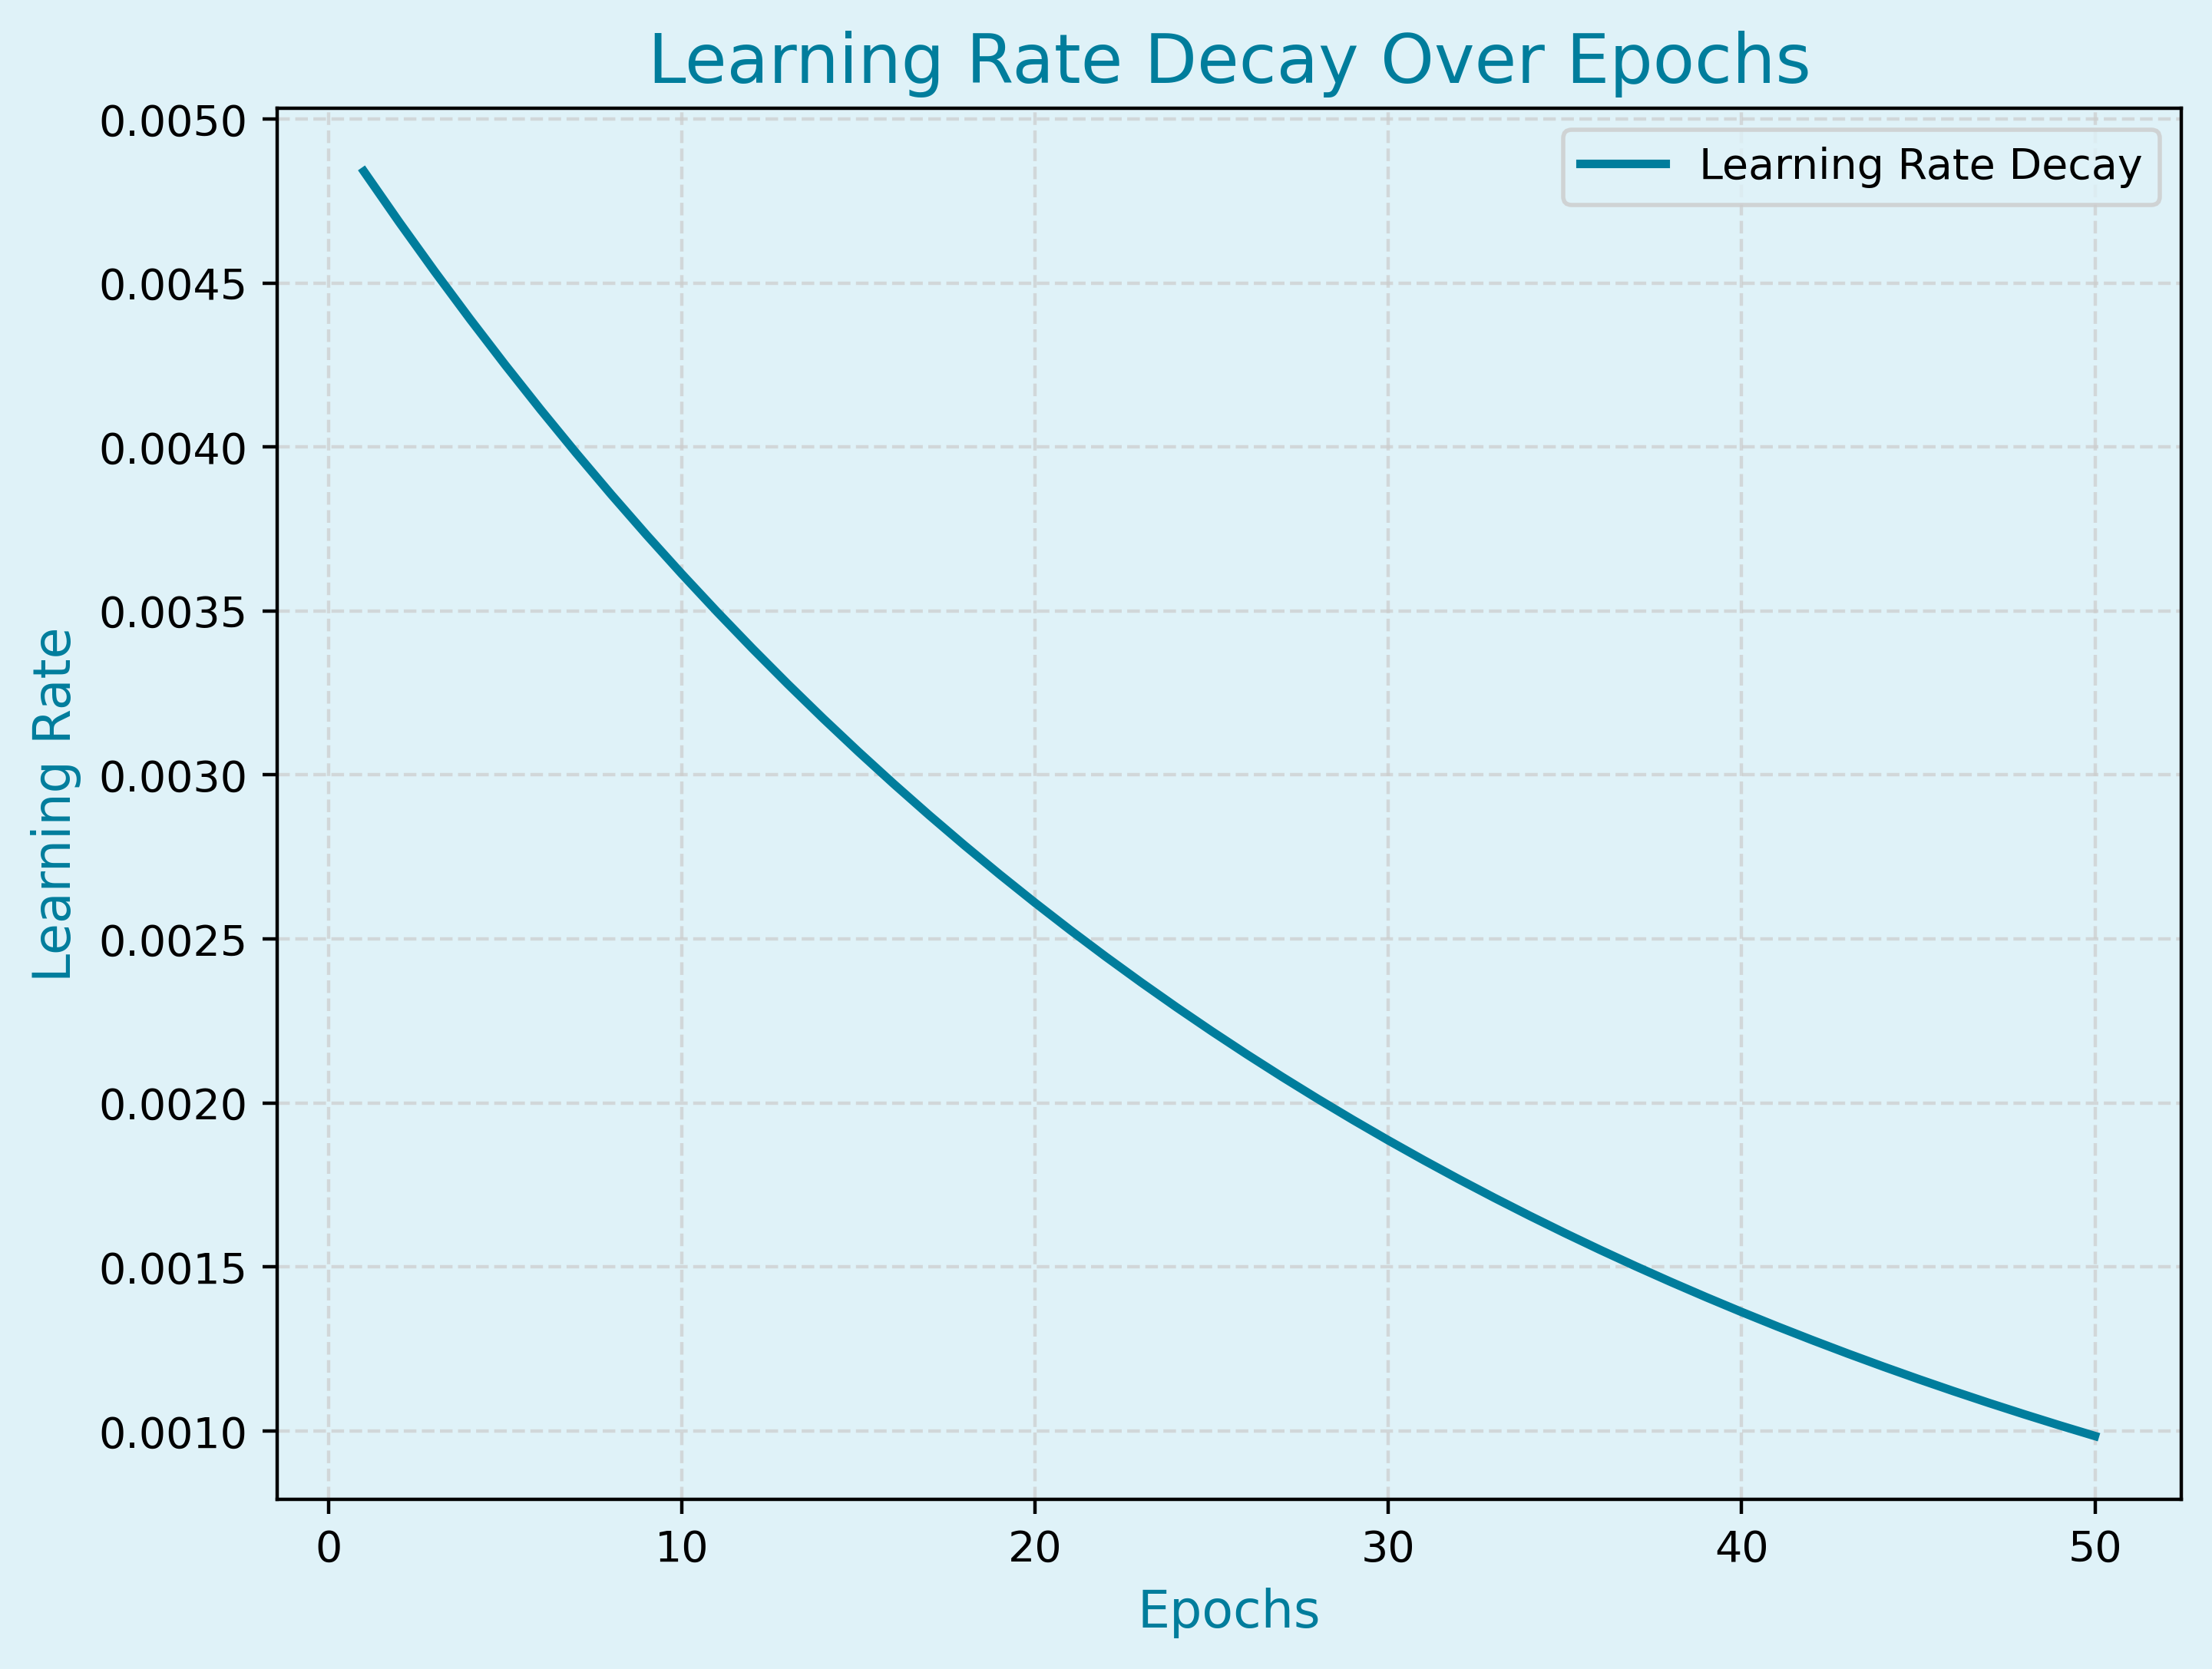

In [23]:
# Define learning rate decay schedule (same values as model)
initial_lr = 0.005
decay_steps = 5
decay_rate = 0.85

# Simulate learning rate decay over epochs
epochs = np.arange(1, 51)
lr_schedule = ExponentialDecay(initial_lr, decay_steps, decay_rate)
learning_rates = [lr_schedule(epoch).numpy() for epoch in epochs]

# Plot learning rate decay
plt.figure(figsize=(8, 6))
plt.plot(epochs, learning_rates, color='#007d9c', linewidth=2, label="Learning Rate Decay")
plt.title('Learning Rate Decay Over Epochs', fontsize=16, color='#007d9c')
plt.xlabel('Epochs', fontsize=12, color='#007d9c')
plt.ylabel('Learning Rate', fontsize=12, color='#007d9c')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [24]:
# Visualise Misclassified Images
misclassified_idx = np.where(y_pred_classes != y_true)[0]
num_misclassified = len(misclassified_idx)
print(f"Number of misclassified images: {num_misclassified}")

Number of misclassified images: 2132


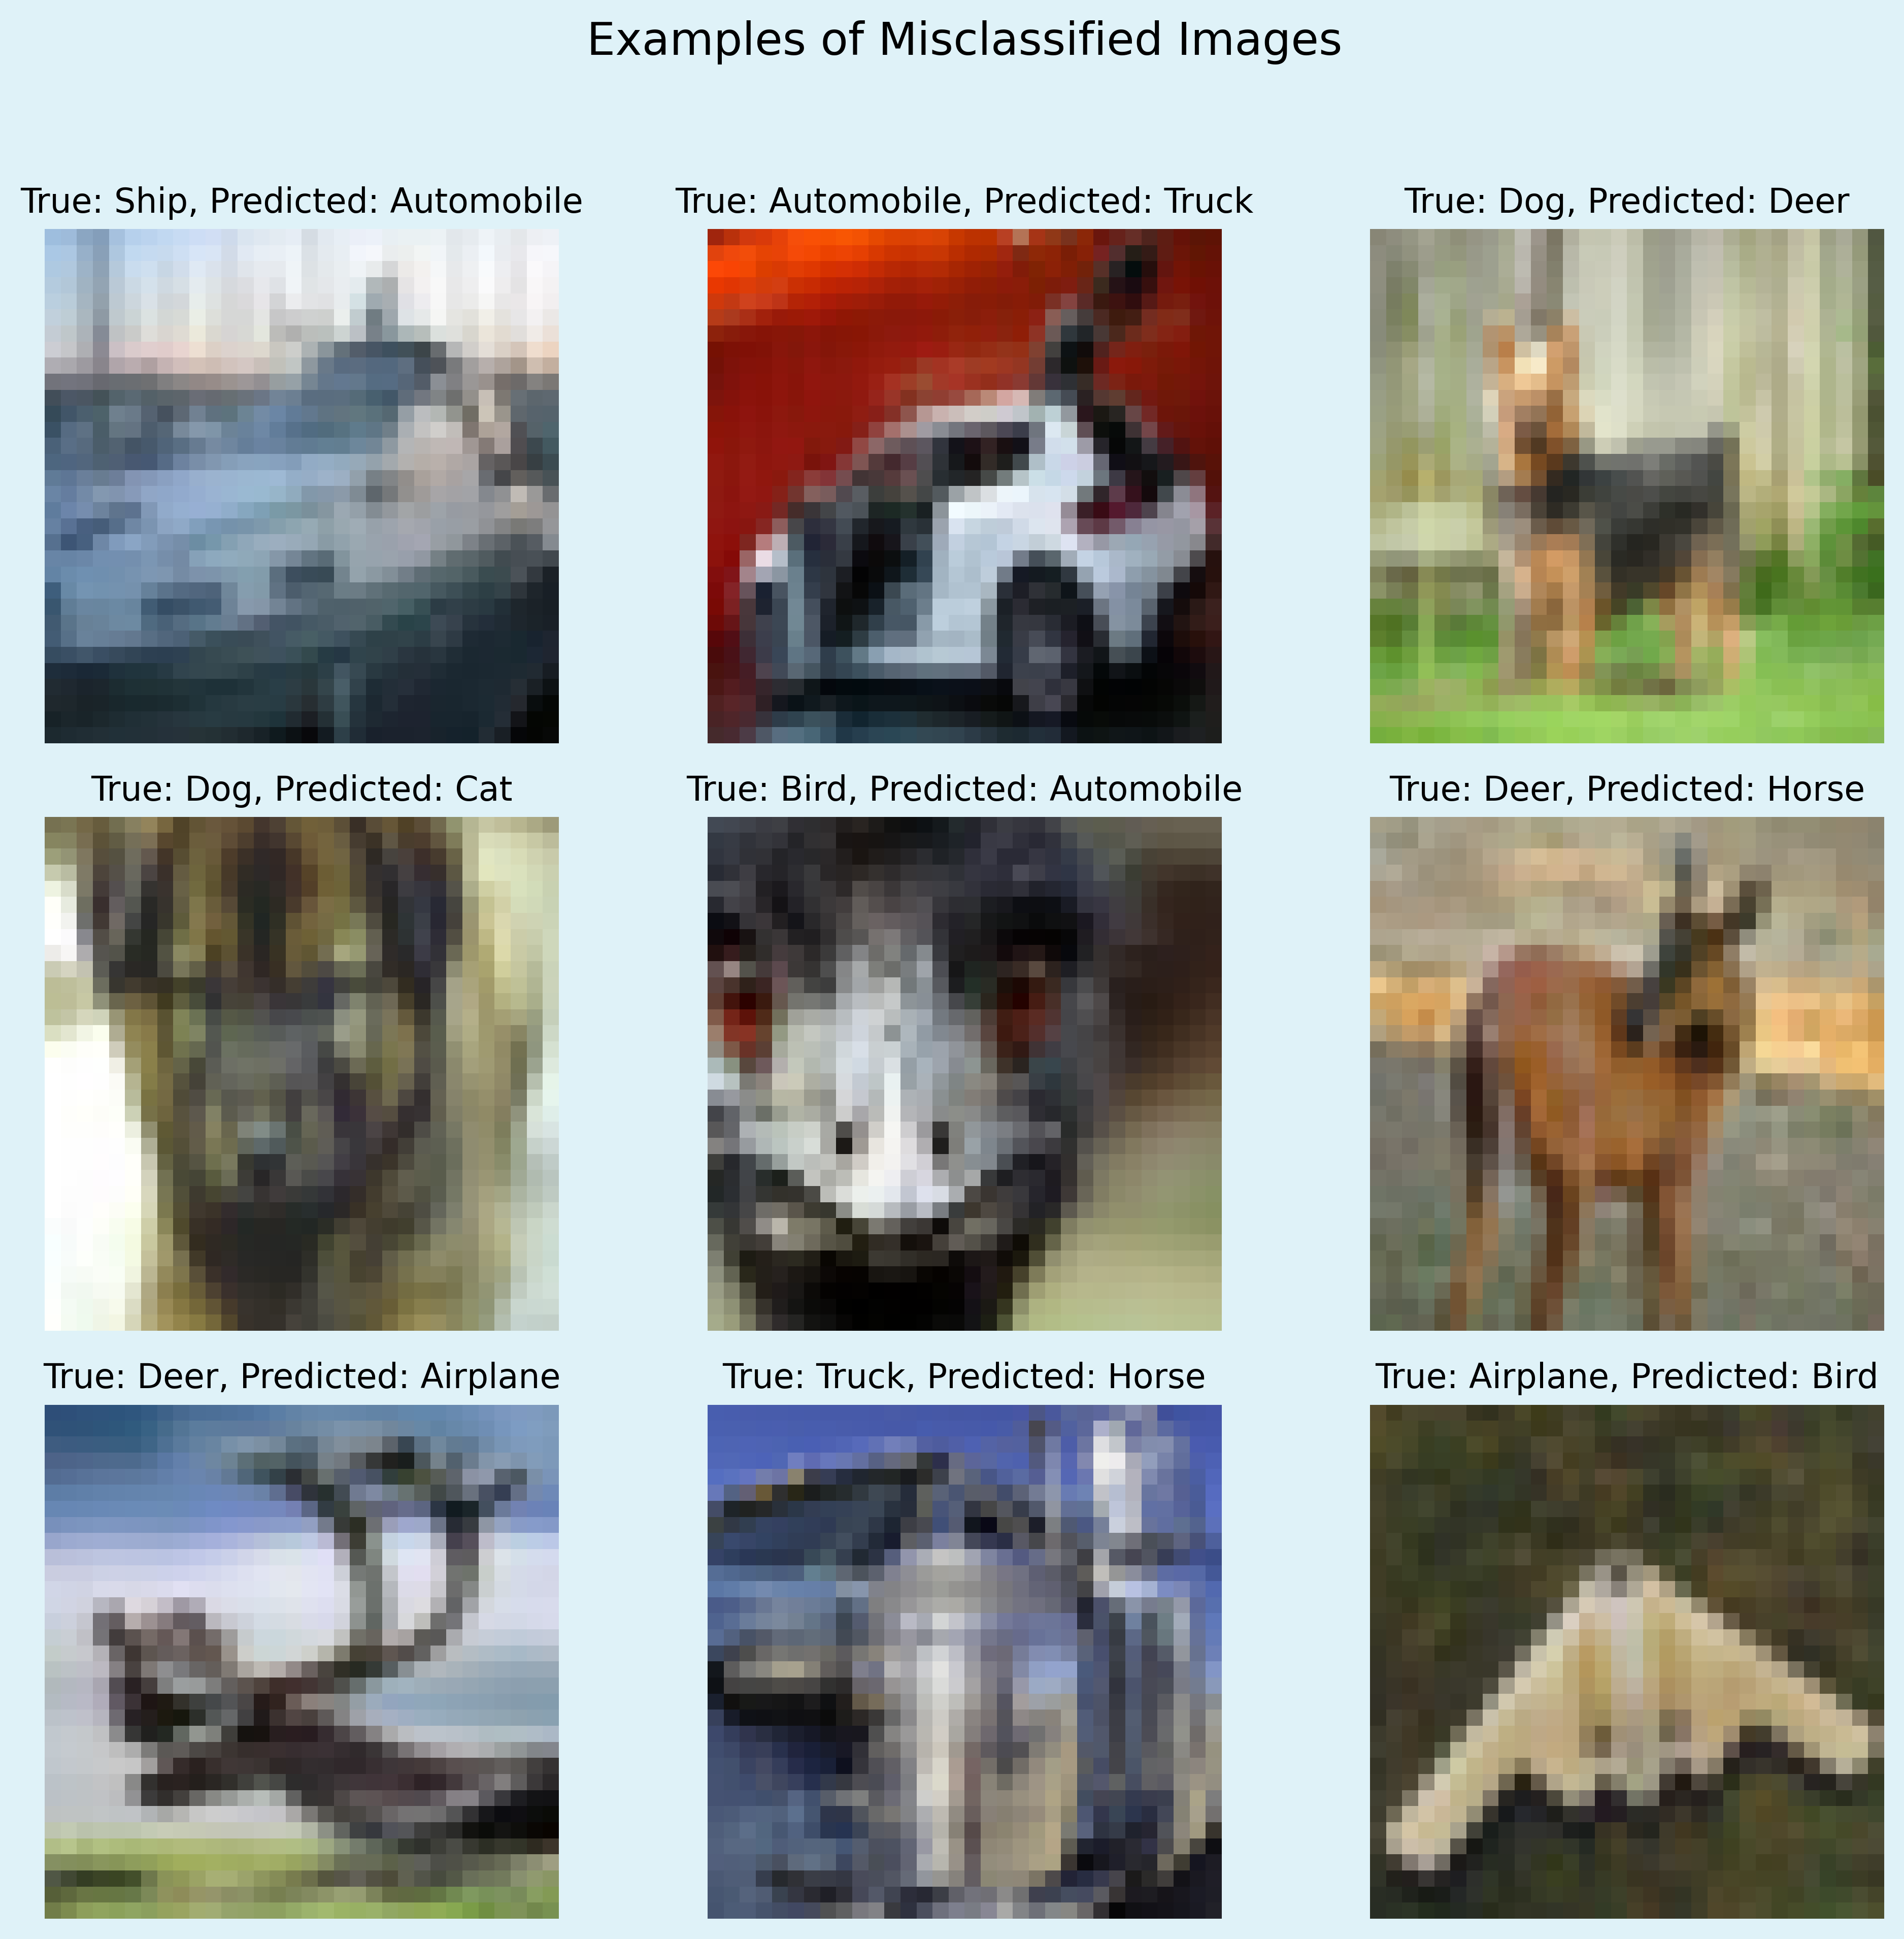

In [25]:
# Display a maximum of 9 misclassified images
num_to_display = min(9, num_misclassified)
if num_to_display > 0:  # Only display if there are misclassified images
    fig, axes = plt.subplots(int(np.ceil(num_to_display/3)), 3, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(num_to_display):
        idx = misclassified_idx[i]
        axes[i].imshow(x_test[idx])
        axes[i].set_title(f"True: {class_labels[y_true[idx]].title()}, Predicted: {class_labels[y_pred_classes[idx]].title()}")
        axes[i].axis('off')

    plt.suptitle("Examples of Misclassified Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No misclassified images to display.")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.4341 - loss: 1.7582 - val_accuracy: 0.4678 - val_loss: 1.6519
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6320 - loss: 1.1807 - val_accuracy: 0.6267 - val_loss: 1.1899
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7068 - loss: 0.9693 - val_accuracy: 0.5939 - val_loss: 1.3410
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7569 - loss: 0.8295 - val_accuracy: 0.6352 - val_loss: 1.2647
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8027 - loss: 0.7266 - val_accuracy: 0.6336 - val_loss: 1.3094
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8277 - loss: 0.6515 - val_accuracy: 0.6411 - val_loss: 1.4070
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8591 - loss: 0.5715 - val_accuracy: 0.6451 - val_loss: 1.3712
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8834 - loss: 0

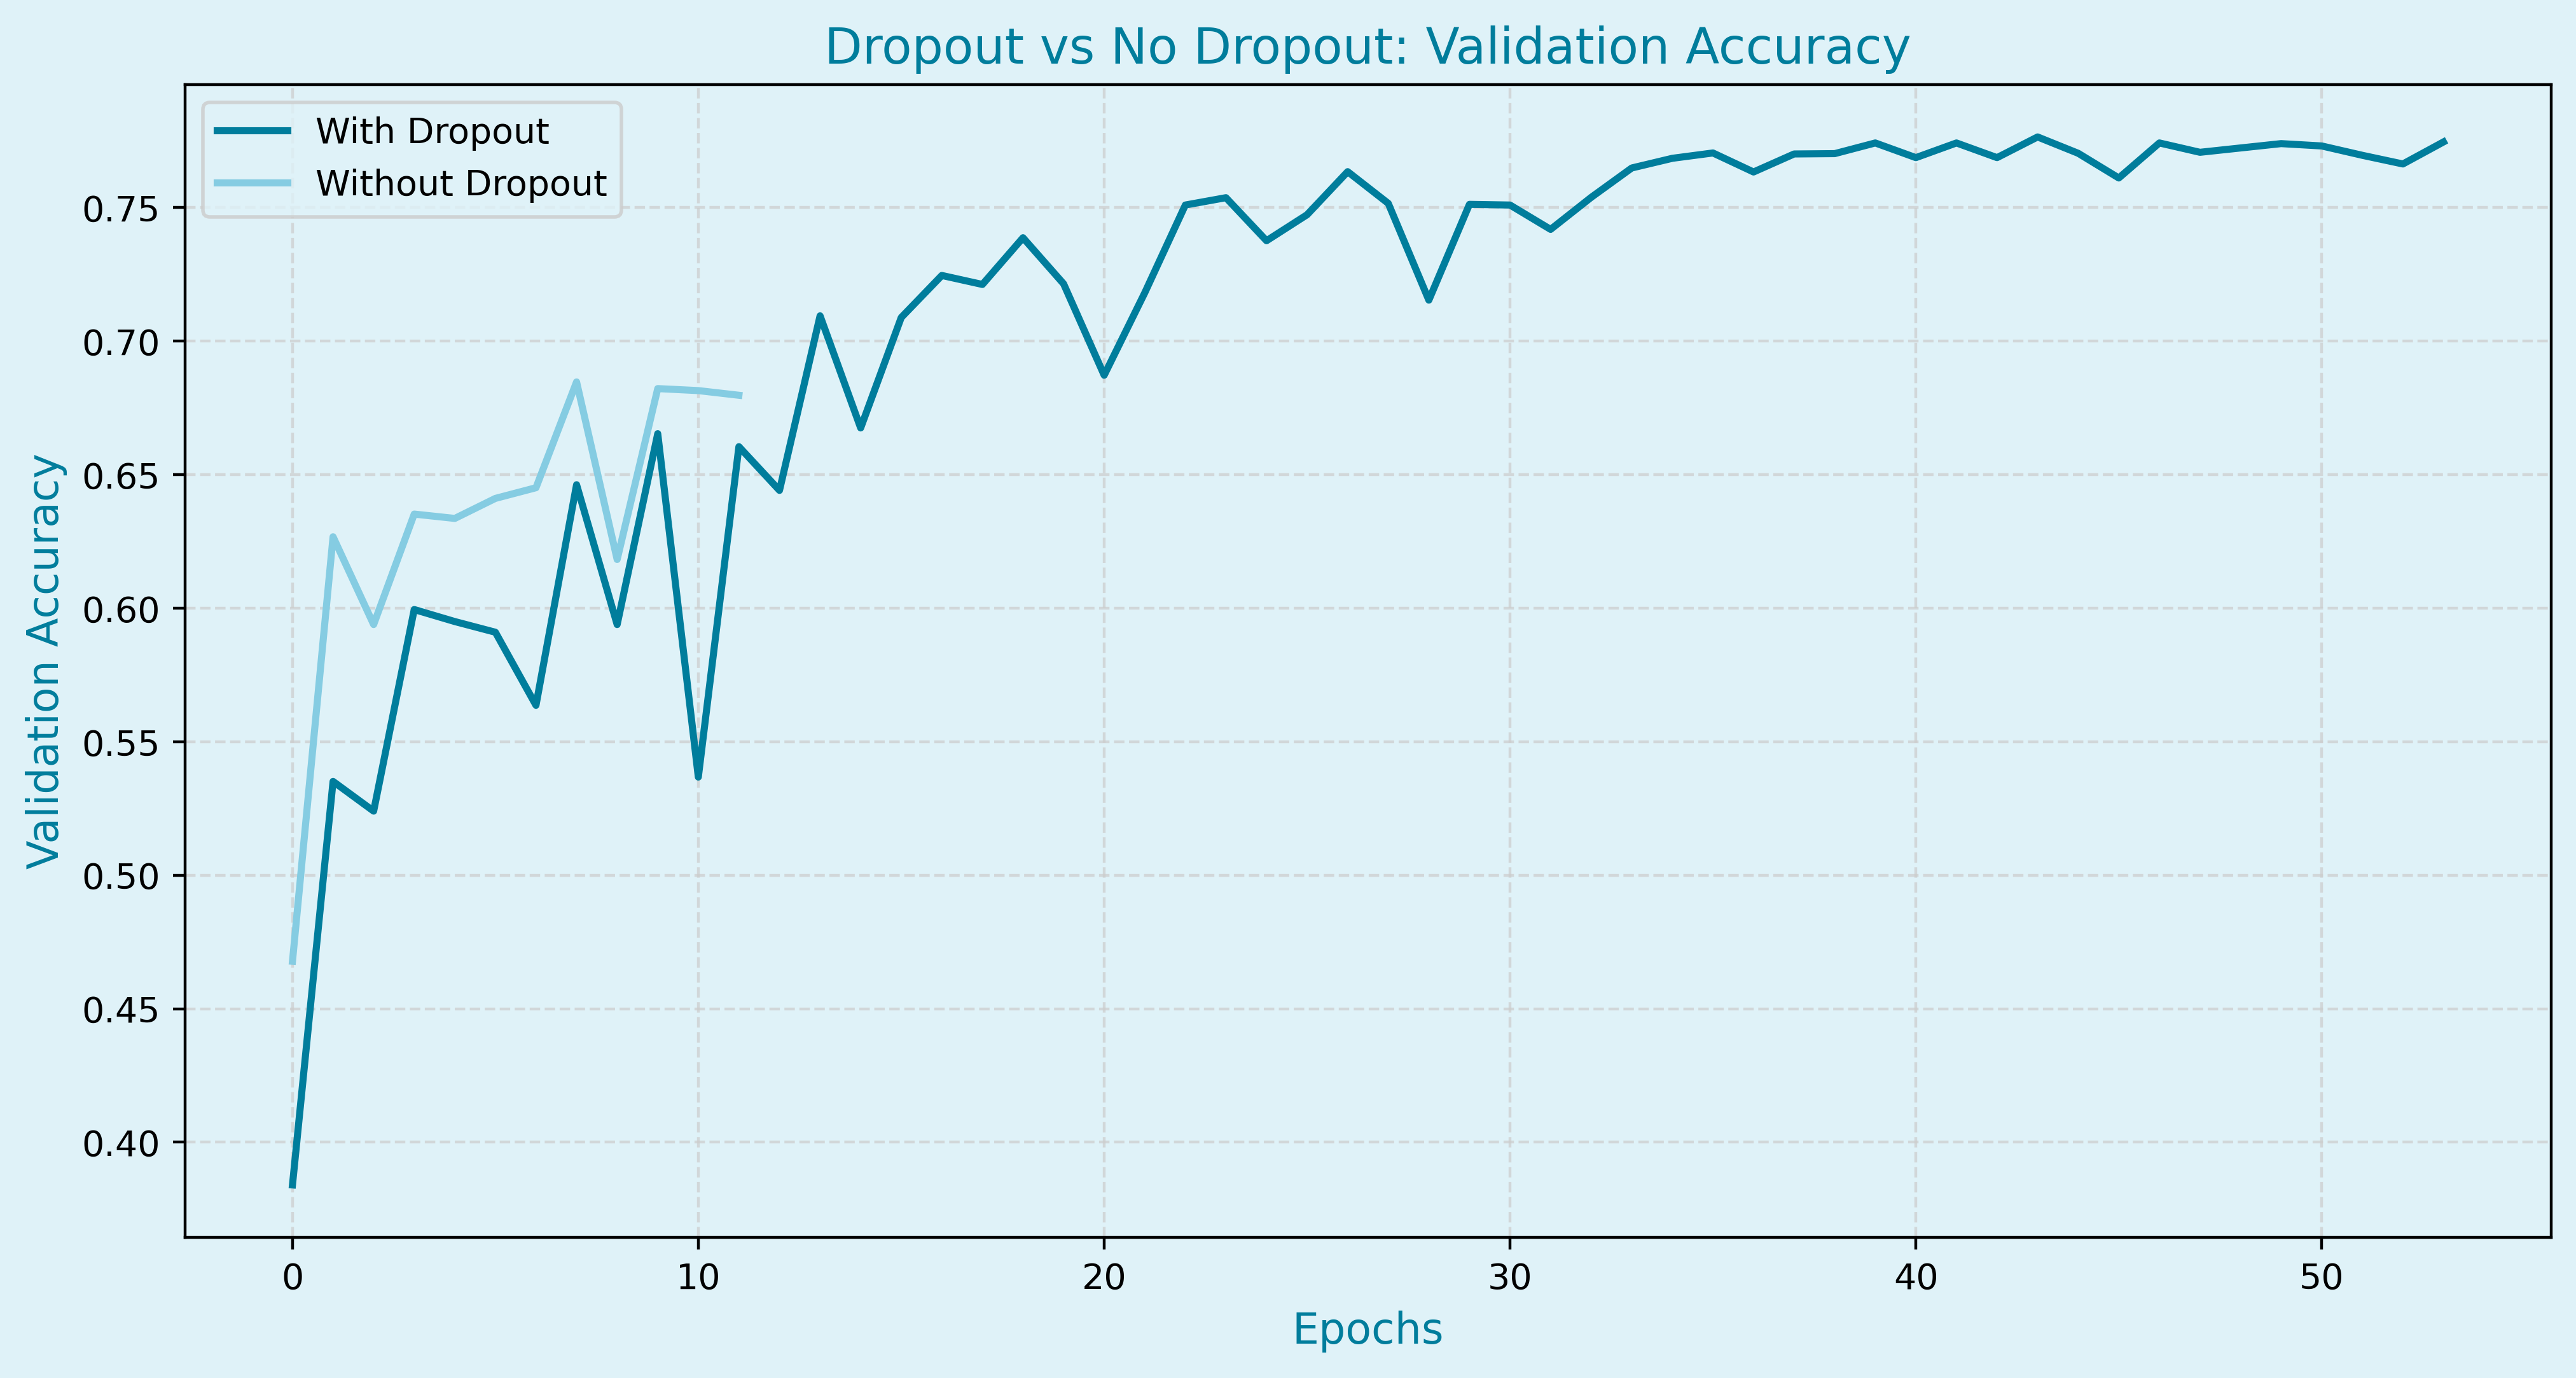

In [26]:
# Define the model without dropout
model_without_dropout = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Dropout removed
    Dense(10, activation='softmax')
])

# Compile the model
model_without_dropout.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving
    patience=10,         # Allow 10 epochs for improvement
    restore_best_weights=True,  # Restore the best weights after stopping
    verbose=1
)

# Train the model without dropout for 50 epochs (with early stopping)
history_without_dropout = model_without_dropout.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,  # Same number of epochs for fair comparison
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping callback
)

# Plot comparison of validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='With Dropout', color='#007d9c', linewidth=2)
plt.plot(history_without_dropout.history['val_accuracy'], label='Without Dropout', color='#85cce2', linewidth=2)

plt.xlabel('Epochs', fontsize=12, color='#007d9c')
plt.ylabel('Validation Accuracy', fontsize=12, color='#007d9c')
plt.title('Dropout vs No Dropout: Validation Accuracy', fontsize=14, color='#007d9c')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Model Reloading and Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


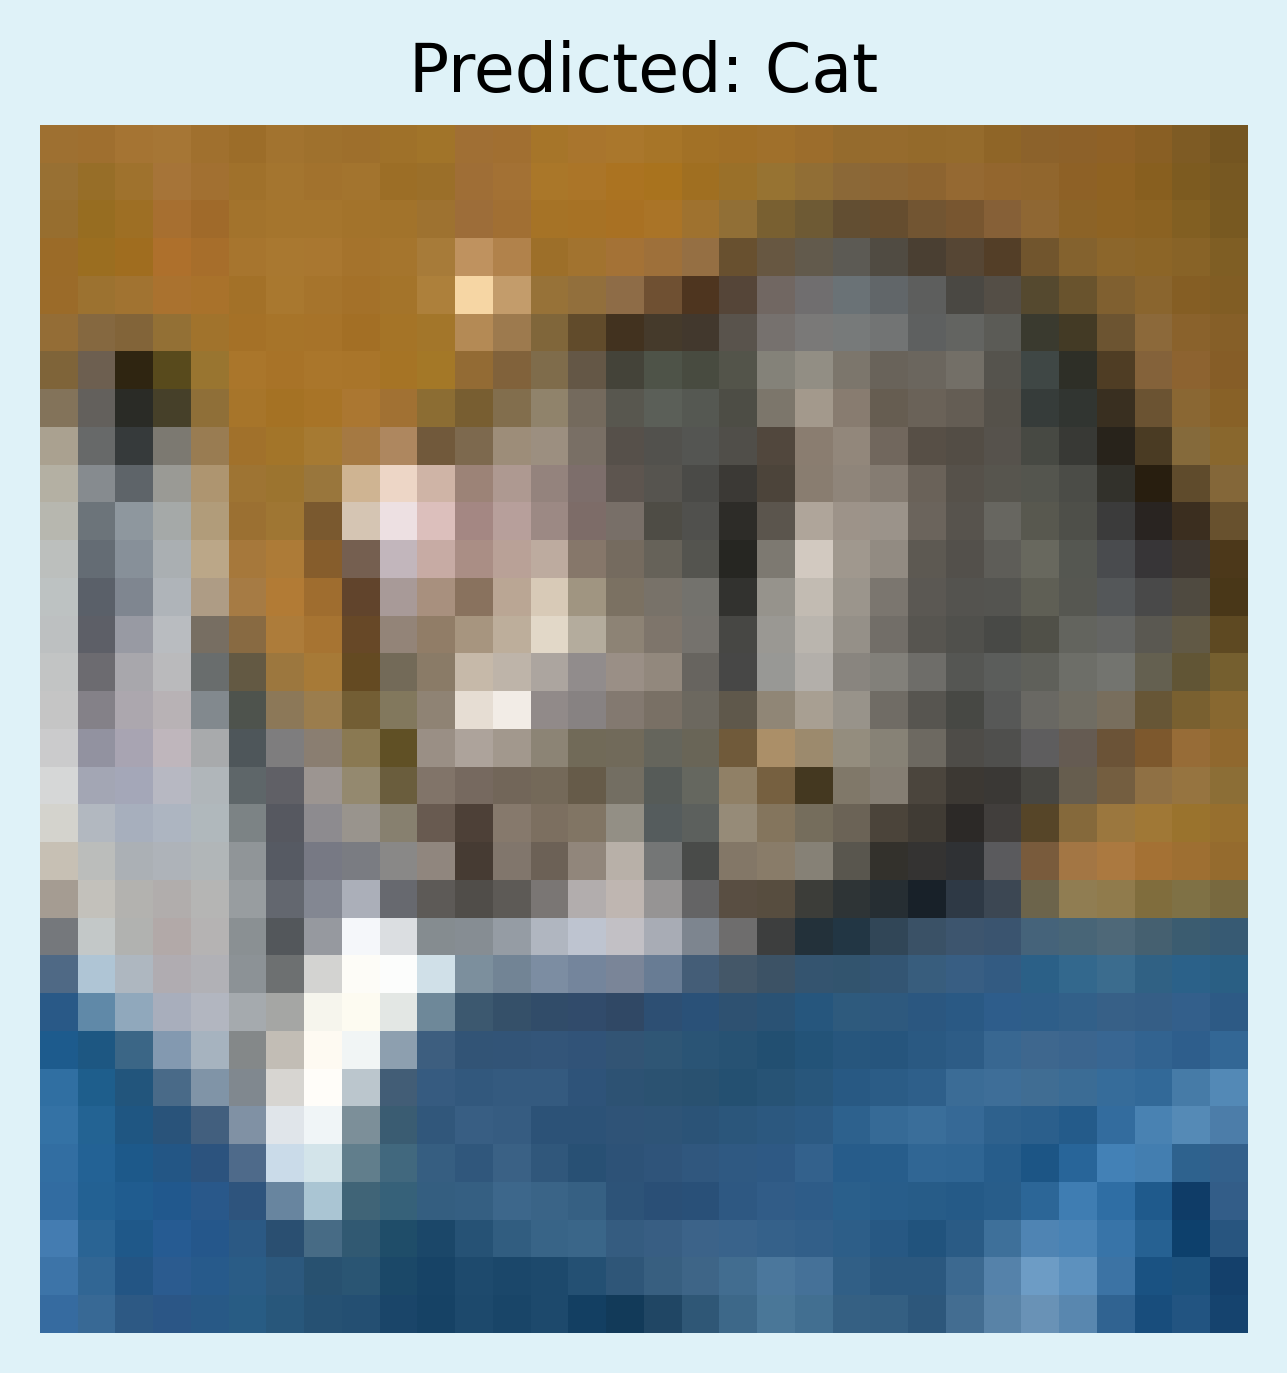

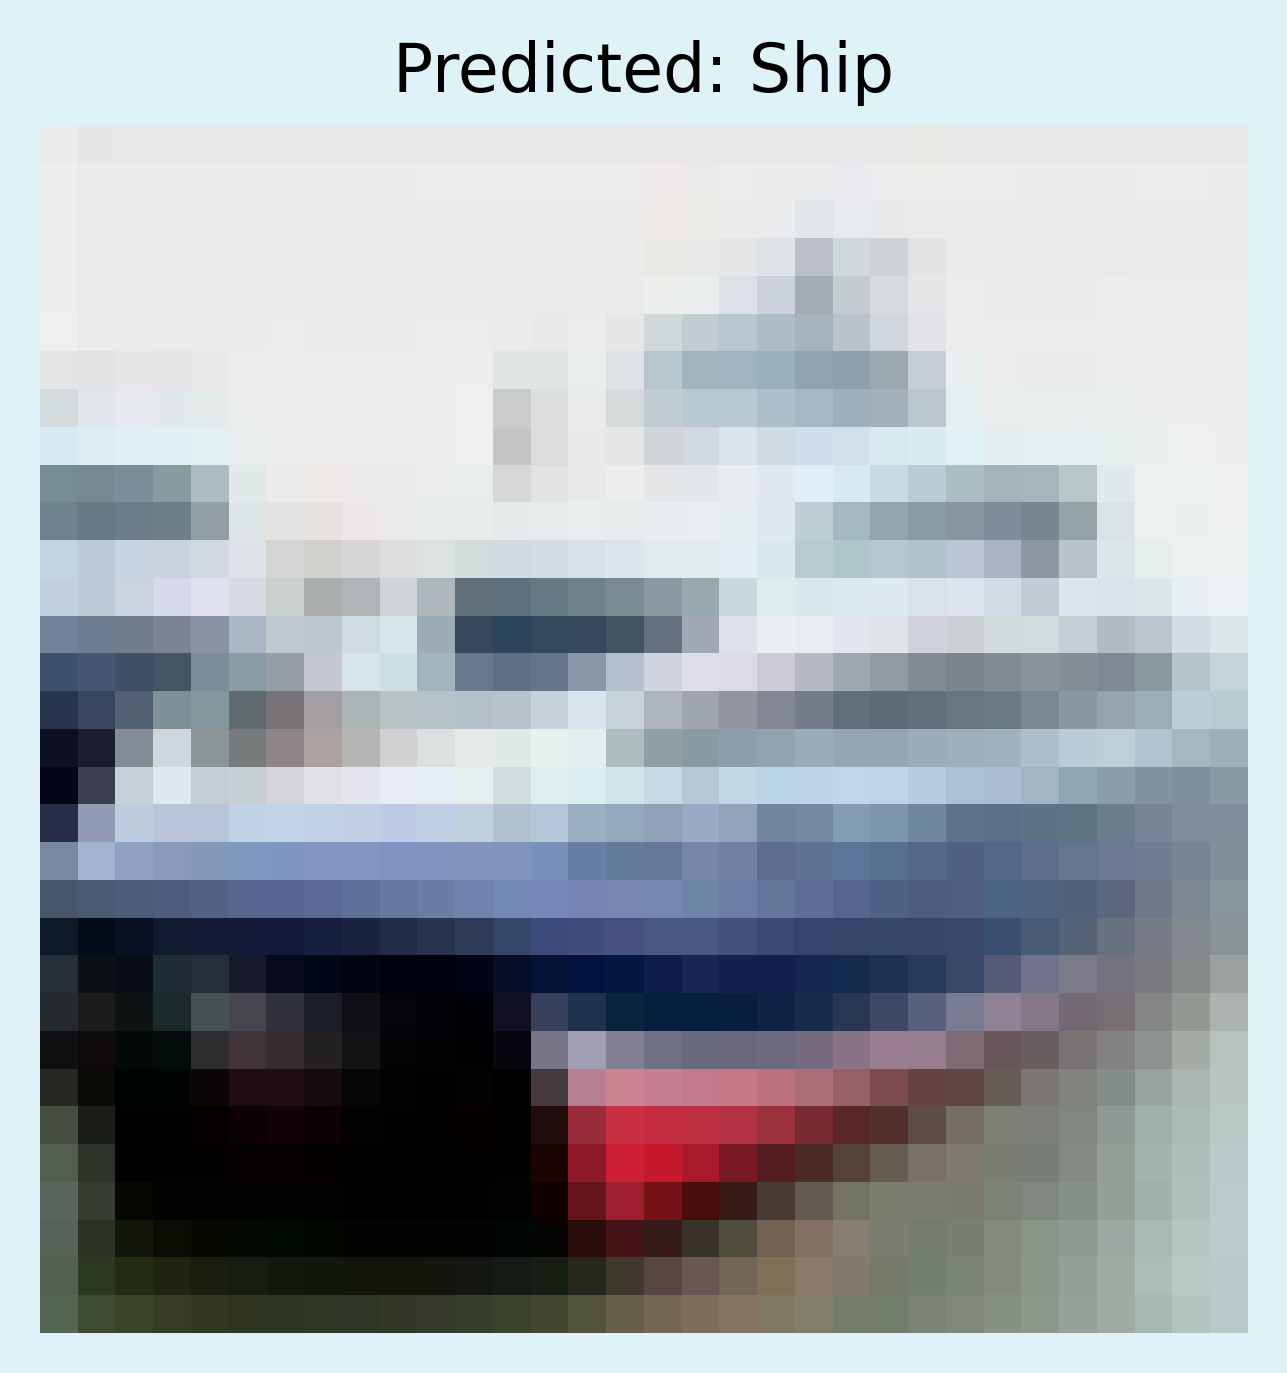

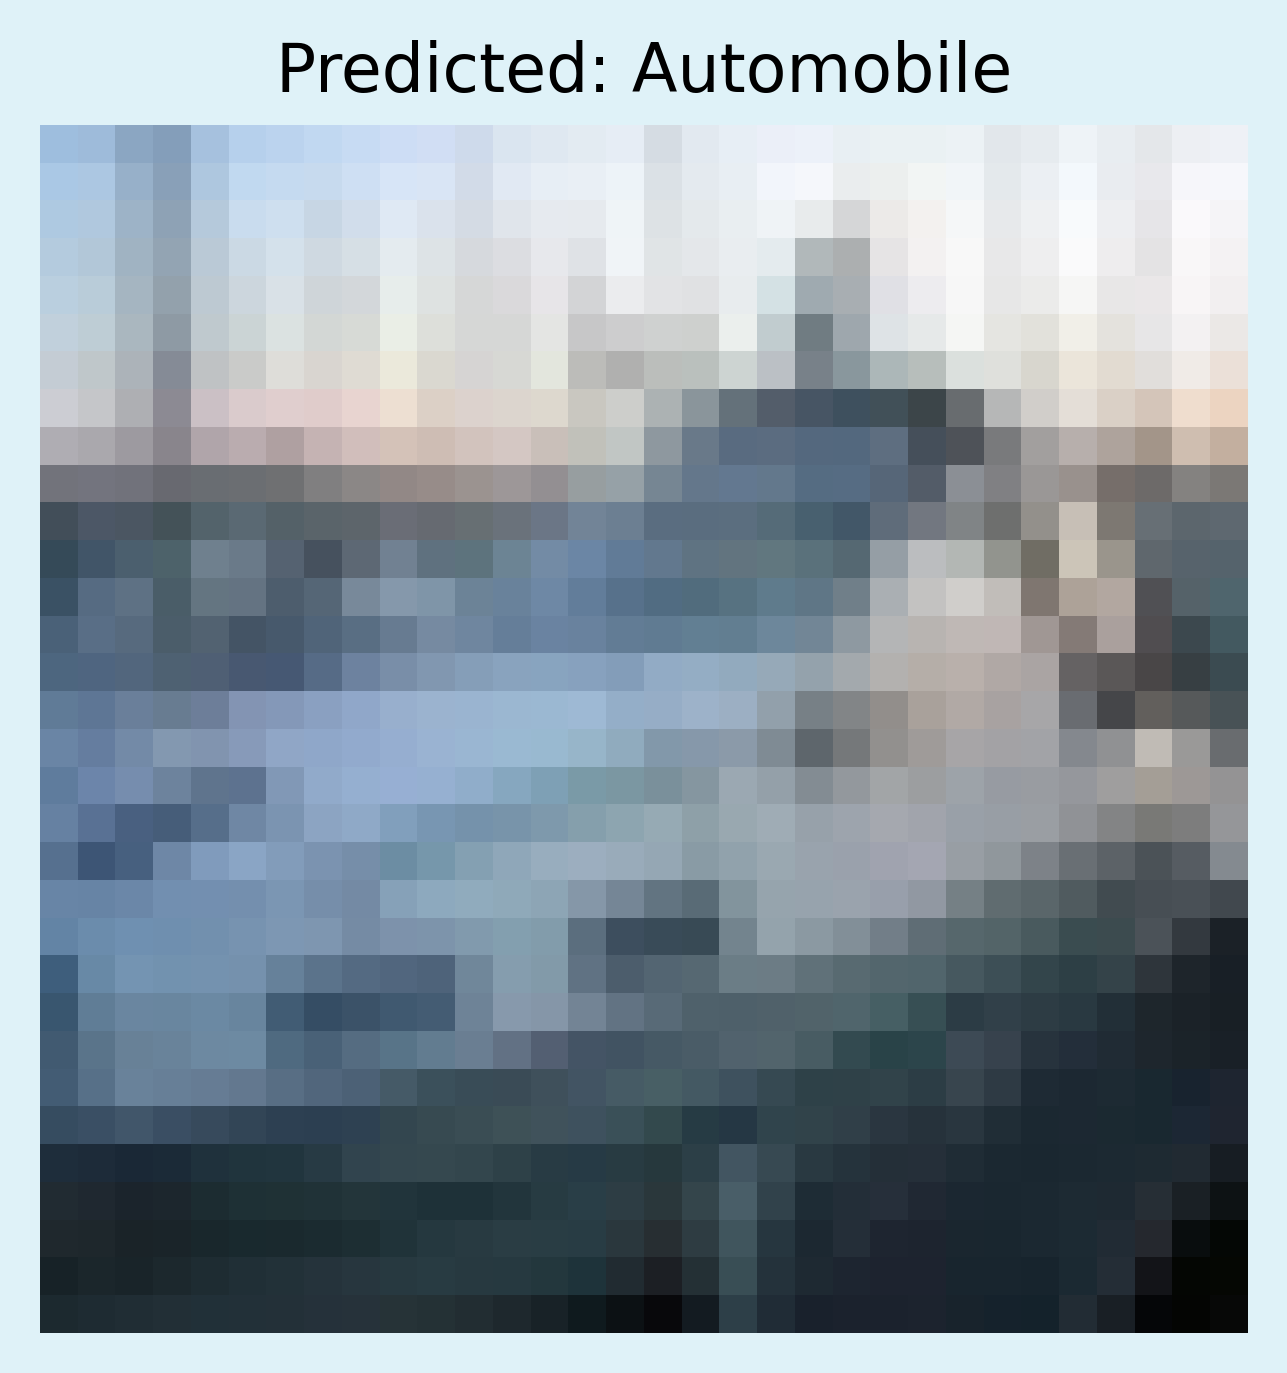

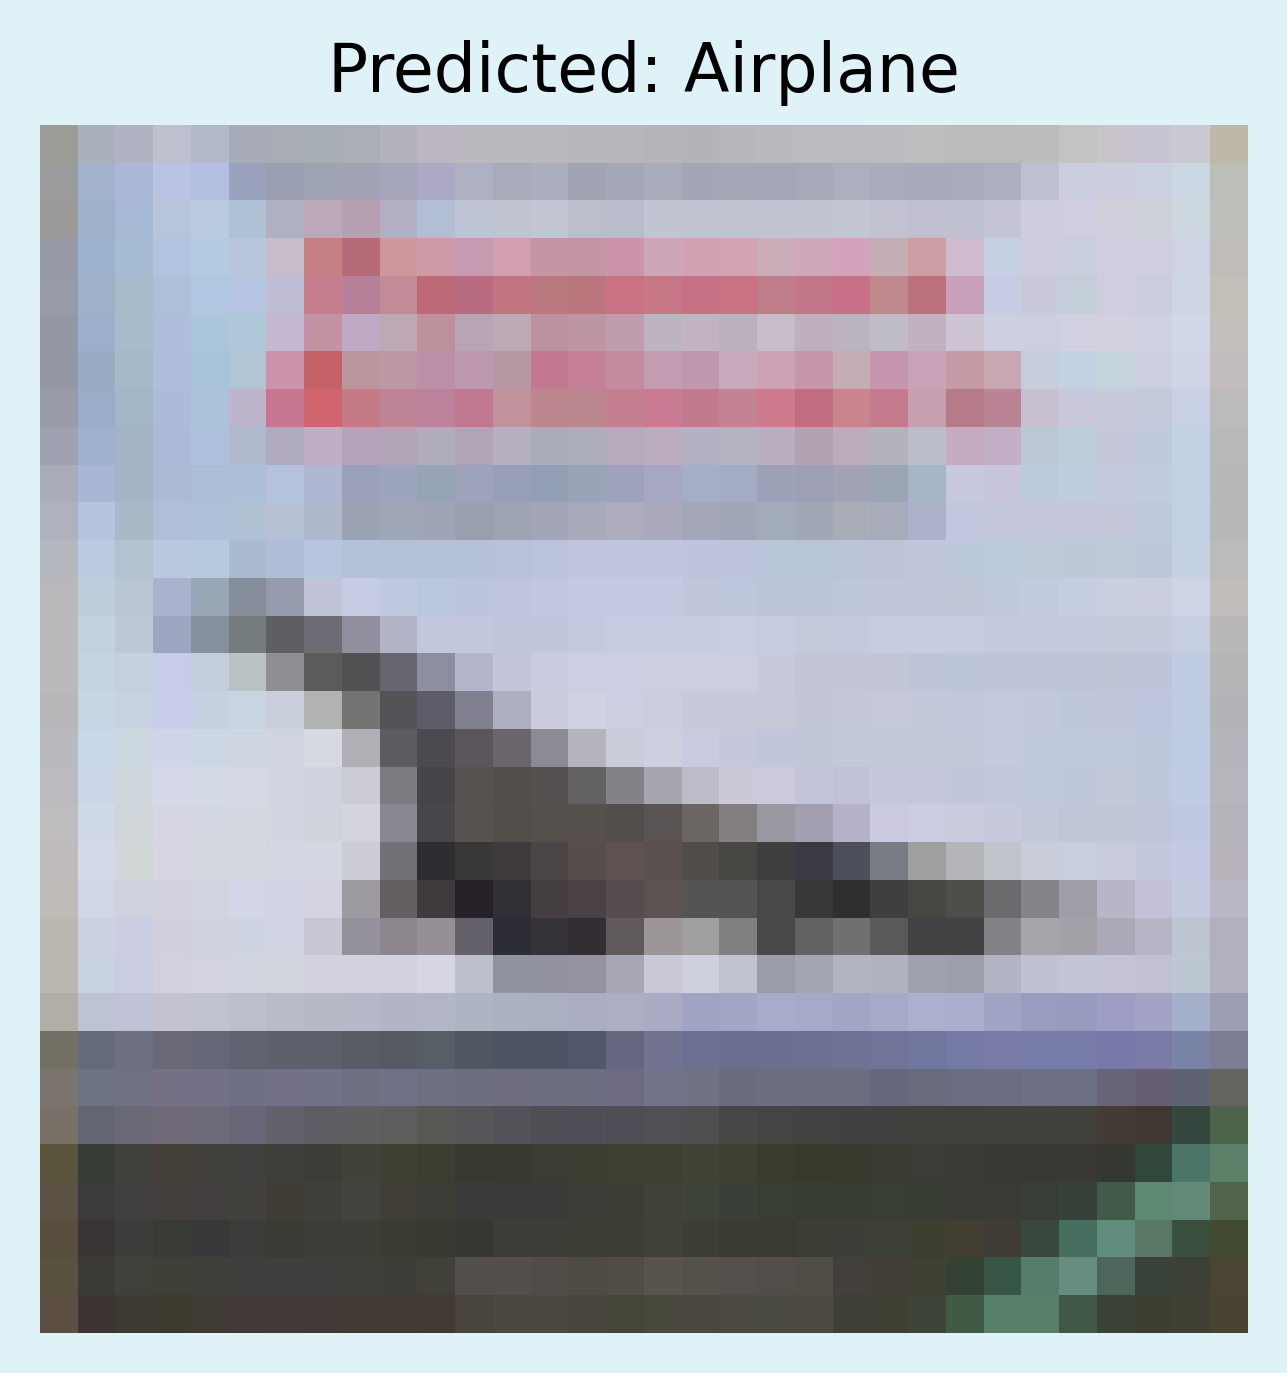

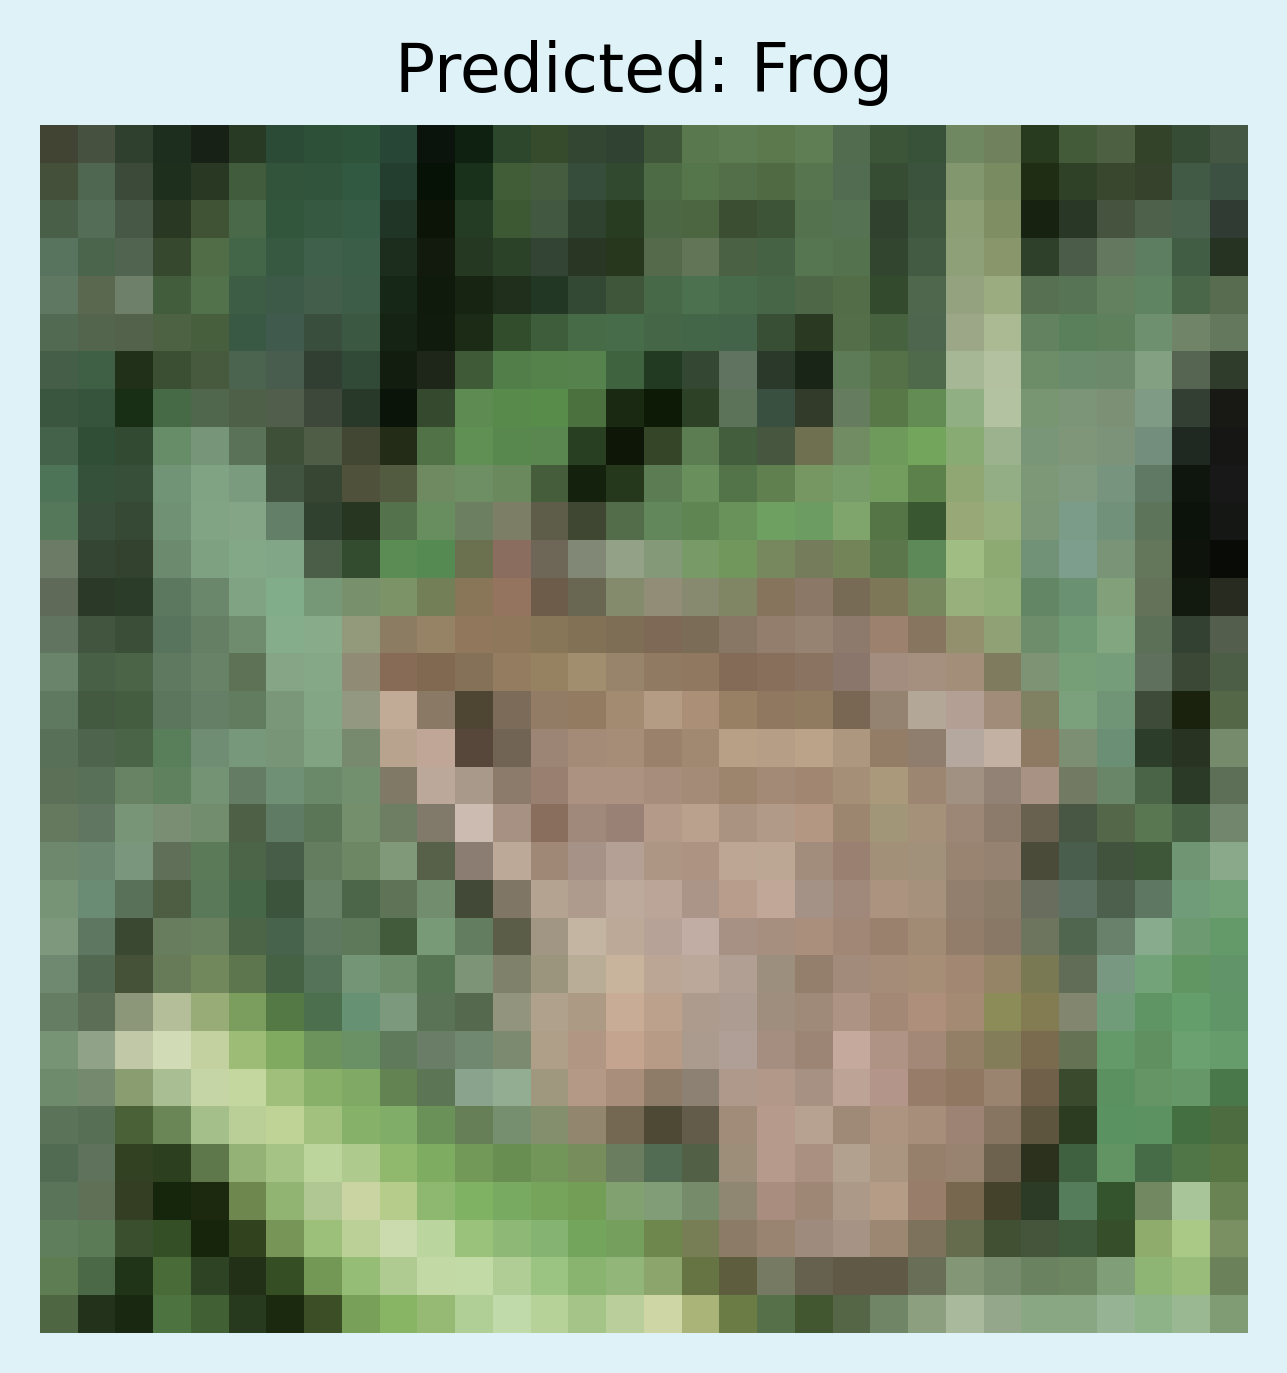

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[3 8 1 0 6]


In [27]:
loaded_model = load_model('/Users/reecelance/Desktop/cifar10_model.keras')

# Test on new data
test_sample = x_test[:5]  # Some sample images
predictions = loaded_model.predict(test_sample)

for i in range(len(test_sample)):
    plt.imshow(test_sample[i])
    predicted_label = np.argmax(predictions[i])  # Convert prediction to label index
    plt.title(f"Predicted: {class_labels[predicted_label].title()}")
    plt.axis('off')
    plt.show()

predictions = loaded_model.predict(test_sample)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)